# Resting state fMRI preprocessing
This notebook contains preprocessing tailored precision mapping in children. 

### 1. Unwarping 
* Measure distortion with the fieldmap
* Eliminate variance (motion, deformations,interactions)

### 2. General fMRI processing
* Slice-time correction
* Rigid realignment (also extract DVARS, FD, motion params)
* Co-registration to the sMRI (T1-weighted structural MRI resampled to 2x2x2mm voxels)

### 3. Resting state processing
* Derive temporal mask based on FD and DVARS
* De-noise to remove:
    - Noise associated with white matter and CSF- delete the GM and smooth what is left
    - Noise associated with background signal - delete brain and smooth what's left
    - Global signal
    - motion regressors
    - Motion derivatives (lagged 8 times)
    - Motion spikes (FD>0.2mm, DVARS>2 SDs from mean)
* Bandpass filter
* delete high motion timepoints and concatenate runs

In [1]:
#import packages
import graphviz
from os import listdir, makedirs
from os.path import isdir
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber, FreeSurferSource # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from nipype.interfaces.nipy.preprocess import Trim
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.fsl import SliceTimer, MCFLIRT, FLIRT, BET, Merge, ExtractROI, TOPUP, ApplyTOPUP
from nipype.interfaces.fsl.utils import Reorient2Std, MotionOutliers
from nipype.interfaces.fsl.maths import ApplyMask, MeanImage
from nipype.interfaces.freesurfer import Resample, Binarize, BBRegister, MRIConvert
from nipype.algorithms.confounds import CompCor
from nipype.interfaces.afni.preprocess import Bandpass
from nipype.interfaces.afni.utils import AFNItoNIFTI
from pandas import DataFrame, read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
study_home = '/Users/SEAlab/Documents/PPM'
raw_data =  '/Users/SEAlab/Documents/PPM/Data'
output_dir = study_home + '/fMRIproc/preprocessing'

workflow_dir = study_home + '/Workflows'
custom_timings = study_home + '/Misc/slice_timing.txt'
phase_encoding_file = study_home + '/Misc/SEA_rest_encoding.txt'
subject_ids = ['1196_PP1', '1196_PP2','1196_Preg1', '1196_Preg2', '1196_Preg3', '1196_Preg4', '1196_Preg5']
#subject_ids = ['1196_Preg1', '1196_Preg2', '1196_Preg3', '1196_Preg4', '1196_Preg5']

#reduce to 2 if other people are using the Mac

proc_cores = 4 # number of cores of processing for the workflows

interleave = True
TR = 2 # in seconds
slice_dir = 3 # 1=x, 2=y, 3=z
resampled_voxel_size = (2,2,2)

fd_threshold = 0.2 #in mm
dvars_threshold = 2 # in standard units

highpass_freq = 0.008 #in Hz
lowpass_freq = 0.09 #in Hz

In [11]:
## File handling Nodes

# Identity node for each subject
subinfosource = Node(IdentityInterface(fields=['subject_id']),
                     name='subinfosource')
subinfosource.iterables = [('subject_id', subject_ids)]

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

# Unwarping 


In [12]:
def sort_pes(pes):
    from nipype import config, logging
    from nipype.interfaces.fsl import Merge
    from os.path import abspath
    config.enable_debug_mode()
    logging.update_logging(config)
    
    print(pes)
    pe1s = []
    pe0s = []
    for file in pes:
        if '300d.01' in file:
            pe0s.append(file)
        elif '300d_revPE' in file:
            pe1s.append(file)
    
    if len(pe1s) < len(pe0s):
        for a in range(len(pe1s),len(pe0s)):
            pe1s.append(pe1s[0])
    
    pe1s = sorted(pe1s)
    pe0s = sorted(pe0s)

    me = Merge()
    merged_pes = []
    
    for i in range(0,len(pe1s)):
        num=pe1s[i][-12:-11]
        me.inputs.in_files = [pe1s[i],pe0s[i]]
        me.inputs.dimension='t'
        me.inputs.merged_file = 'merged_pes%s.nii.gz' % num
        me.run()
        file = abspath('merged_pes%s.nii.gz' % num)
        merged_pes.append(file)
        
    return(merged_pes)

In [13]:
pes_template = {'pes': raw_data + '/%s/NIFTI/FMRI_rest*.01.nii'}
select_pes = Node(DataGrabber(sort_filelist=True,
                              template = raw_data + '/%s/NIFTI/FMRI_rest*.01.nii',
                              field_template = pes_template,
                              base_directory=raw_data,
                              infields=['subject_id'], 
                              template_args={'pes':[['subject_id']]}), 
                  name='select_pes')

func_template = {'func': raw_data + '/%s/NIFTI/FMRI_rest*_300d.01.nii'}
select_func = Node(DataGrabber(sort_filelist=True,
                               template = raw_data + '/%s/NIFTI/FMRI_rest*_300d.01.nii',
                               field_template = func_template,
                               base_directory=raw_data,
                               infields=['subject_id'], 
                               template_args={'func':[['subject_id']]}), 
                   name='select_func')

# include only the first volume of each PE volume
trim_PEs = MapNode(ExtractROI(t_min=0, t_size=5),name='trim_PEs', 
                   iterfield=['in_file'])

sort_pe_list = Node(Function(input_names=['pes'],
                             output_names=['merged_pes'],
                             function=sort_pes), 
                    name='sort_pe_list')

topup = MapNode(TOPUP(encoding_file=phase_encoding_file), name='topup',iterfield=['in_file'])

apply_topup = MapNode(ApplyTOPUP(in_index=[6], encoding_file=phase_encoding_file,
                                 method='jac', out_corrected='func_unwarped.nii.gz'),
                      name='apply_topup',iterfield=['in_topup_fieldcoef','in_topup_movpar','in_files'])

In [ ]:
prepreprocflow = Workflow(name='unwarpflow')
prepreprocflow.connect([(subinfosource,select_pes, [('subject_id','subject_id')]),
                        (subinfosource,select_func, [('subject_id','subject_id')]),
                        (select_pes,trim_PEs, [('pes','in_file')]), 
                        (trim_PEs,sort_pe_list, [('roi_file','pes')]),
                        (sort_pe_list,topup, [('merged_pes','in_file')]),
                        (topup, apply_topup, [('out_fieldcoef','in_topup_fieldcoef'), 
                                              ('out_movpar','in_topup_movpar')]),
                        (select_func, apply_topup, [('func','in_files')]),
                        (apply_topup, datasink, [('out_corrected','unwarped_funcs')])
                       ])

prepreprocflow.base_dir = workflow_dir
prepreprocflow.write_graph(graph2use='flat')
prepreprocflow.run('MultiProc', plugin_args={'n_procs': proc_cores, 'memory_gb':8})

## Process T1 anat for fMRI processing
1. Resample skullstripped T1w anat
2. Resample segmentation 
3. Create tissue masks:
    - GM only
    - Non-GM only
    - Full brain (no ventricles)
    - Full brain (with ventricles and dilated)
    - Extra-cerebral space
4. Resample surfaces

In [14]:
def make_masks_freesurfer(aseg_nifti):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nibabel import load, save, Nifti1Image
    from numpy import zeros
    from nipype.interfaces.freesurfer import Binarize
    from os.path import abspath
    
    # load the subject's segmentation volumes
    aseg_img = load(aseg_nifti)
    aseg_data = aseg_img.get_data()
    
    # list indices for each tissue type (from freesurfer aseg)
    wm = [2, 7, 41, 46, 60, 28, 16, 77, 251, 252, 253, 254, 255]
    gm = [3, 6, 8, 9, 10, 11, 12, 13, 17, 18, 26, 42, 47, 49, 50, 51, 52, 53, 54, 58]
    csf = [4, 5, 14, 15, 24, 63]
    non_gm = wm + csf
    whole_brain = wm + gm + csf
    
    # preallocate zeros for the tissue masks
    wm_combined = zeros(aseg_data.shape)
    gm_combined = zeros(aseg_data.shape)
    csf_combined = zeros(aseg_data.shape)
    non_gm_combined = zeros(aseg_data.shape)
    whole_brain_combined = zeros(aseg_data.shape)
    
    # put labels into lists to make looping easier
    tissues_idx = [wm, gm, csf, non_gm, whole_brain]
    tissues_data = [wm_combined, gm_combined, csf_combined, non_gm_combined, whole_brain_combined]
    tissue_name = ['wm','gm','csf','non_gm','whole_brain']
    
    # initialize the binarize class
    binarize = Binarize()
    binarize.inputs.min = 0.5
    binarize.inputs.dilate = 1
    binarize.inputs.erode = 1
    
    # isolate labels for specific regions
    for x in range(0,5):
        if 'wm' in tissue_name[x] or 'non_gm' in tissue_name[x]:
            binarize.inputs.erode = 2
        else:
            binarize.inputs.erode = 1
        for label in tissues_idx[x]:
            tissues_data[x][aseg_data==label] = 1
        tmp_img = Nifti1Image(tissues_data[x],header=aseg_img.header, affine=aseg_img.affine)
        save(tmp_img, tissue_name[x] + '_mask.nii.gz')
         
        binarize.inputs.in_file = abspath(tissue_name[x] + '_mask.nii.gz')
        binarize.inputs.binary_file = tissue_name[x] + '_mask.nii.gz'
        binarize.run()
    
    # make dilated brain mask
    binarize.inputs.in_file = abspath('whole_brain_mask.nii.gz')
    binarize.inputs.binary_file = 'whole_brain_D1_mask.nii.gz'
    binarize.inputs.dilate = 1
    binarize.inputs.erode = 0
    binarize.run()
    
    # gather up the mask filepaths to return
    wm_csf_mask = abspath('non_gm_mask.nii.gz')
    brain_mask = abspath('whole_brain_mask.nii.gz')
    gm_only_mask = abspath('gm_mask.nii.gz')
    brain_mask_dilated = abspath('whole_brain_D1_mask.nii.gz')
    
    return(wm_csf_mask, brain_mask, gm_only_mask, brain_mask_dilated)

def invert_masks(mask_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nibabel import load, save, Nifti1Image
    from os.path import abspath, basename
    from numpy import zeros
    
    # load mask data
    mask_img = load(mask_file)
    mask_data = mask_img.get_data()
    
    # preallocate new mask data
    inv_data = zeros(mask_data.shape)
    
    # invert the 1s and 0s
    inv_data[mask_data==0] = 1
    
    #save as a new file
    inv_img = Nifti1Image(inv_data, header = mask_img.header, affine = mask_img.affine)
    save(inv_img, 'inverted_' + basename(mask_file))
    inverted_mask = abspath('inverted_' + basename(mask_file))
    
    return(inverted_mask)

#Function get FS Dir
def get_subject_fs_dir(datadir, subject_id):
    fs_dir = datadir + "/" + subject_id + "/T1w"
    return(fs_dir)


In [15]:
#Choose FS Directory 
get_fsdir = Node(Function(input_names=['datadir', 'subject_id'], 
                                        output_names=['fs_dir'],
                         function=get_subject_fs_dir), name='get_fsdir')
get_fsdir.inputs.datadir=raw_data

# FreeSurferSource node to grab processed T1w data from freesurfer
t1w_source = Node(FreeSurferSource(), name='t1w_source')

# resample brain file
resample_anat = Node(MRIConvert(vox_size=resampled_voxel_size, 
                                out_type='niigz', out_file='resampled_anat.nii.gz'), name='resample_anat')

# resample segmentation file
resample_seg = Node(MRIConvert(vox_size=resampled_voxel_size, 
                               resample_type='nearest', 
                               out_type='niigz'), name='resample_seg')

# make masks
make_masks = Node(Function(input_names=['aseg_nifti'], 
                           output_names=['wm_csf_mask', 'brain_mask', 'gm_only_mask', 'brain_mask_dilated'], 
                           function=make_masks_freesurfer), name='make_masks')

#invert the brain mask
invert_mask = Node(Function(input_names=['mask_file'], 
                            output_names=['inverted_mask'], 
                            function=invert_masks), name='invert_mask')

In [ ]:
anatpreproc = Workflow(name='fmri_anat_preprocflow')
anatpreproc.connect([(subinfosource, t1w_source, [('subject_id','subject_id')]),
                     (subinfosource, get_fsdir, [('subject_id', 'subject_id')]),
                     (get_fsdir, t1w_source, [('fs_dir', 'subjects_dir')]),
                     (t1w_source, resample_anat, [('brain','in_file')]),
                     (t1w_source, resample_seg, [('aseg','in_file')]),
                     (resample_seg, make_masks, [('out_file','aseg_nifti')]),
                     (make_masks, invert_mask, [('brain_mask','mask_file')]),
                     
                     (make_masks, datasink, [('wm_csf_mask','wm_csf_mask'),
                                             ('brain_mask','brain_mask'),
                                             ('gm_only_mask','gm_mask'),
                                             ('brain_mask_dilated','brain_mask_dilated')]),
                     (resample_anat, datasink, [('out_file','resampled_t1w_anat')]),
                     (invert_mask, datasink, [('inverted_mask','background_mask')])
                    ])
anatpreproc.base_dir = workflow_dir
#anatpreproc.write_graph(graph2use='flat')
anatpreproc.run('MultiProc', plugin_args={'n_procs': proc_cores})

## Preprocess fMRI resting state data
These nodes and workflow (preprocflow) perform basic preprocessing to align the functional volumes into a common space.
1. Reorient images to standard space
2. Reslice the structural image to 2mm isotropic
3. Functional image slice time correction
4. Rigid realignment to middle volume of functional image
5. Coregistration of functional images to structural image

In [16]:
## File handling Nodes
substitutions = [('_subject_id_', '_'),('_filename_','')]
datasink.inputs.substitutions = substitutions

# Select anat
anat_template = {'brain_mask': output_dir + '/brain_mask_dilated/{subject_id}/whole_brain_D1_mask.nii.gz',
                 'resliced_anat': output_dir + '/resampled_t1w_anat/{subject_id}/resampled_anat.nii.gz'}
selectanat = Node(SelectFiles(anat_template), name='selectanat')

# Data grabber- select fMRI
func_template = {'func':output_dir + '/unwarped_funcs/{subject_id}/_apply_topup{run_num}/func_unwarped.nii.gz'}
selectfunc = Node(SelectFiles(func_template), name='selectfunc')
selectfunc.iterables=('run_num', ['0','1'])

In [17]:
def list_func(template,subject_id,session_info):
    func = []
    filelist=session_info[session_info['subject_id']==int(subject_id)]['run_name'].to_list()
    for f in filelist:
        func.append(template.format(subject_id, f))
        
    print(func)
    return(func)

def norm_timeseries(in_file, mask_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.masking import apply_mask, unmask
    from sklearn.preprocessing import StandardScaler
    
    raw_data = apply_mask(in_file, mask_file)
    scaler = StandardScaler(with_mean=True)
    norm_data = scaler.fit_transform(raw_data)
    norm_data = norm_data + 1000
    img = unmask(norm_data, mask_file)
    img.to_filename('norm_func.nii.gz')
    out_file = abspath('norm_func.nii.gz')
    return(out_file)

#Function get FS Dir
def get_subject_fs_dir(datadir, subject_id):
    fs_dir = datadir + "/" + subject_id + "/T1w"
    return(fs_dir)

In [18]:
## Nodes for preprocessing

#Slice timing correction based on interleaved acquisition using FSL
slicetime_correct = Node(SliceTimer(interleaved=interleave, 
                                    time_repetition=TR, 
                                    out_file='st_func.nii.gz'),
                         name='slicetime_correct')
# Rigid realignment
realign = Node(MCFLIRT(out_file='rest_moco.nii.gz',save_plots=True), 
               name='realign')

# compute DVARS and FD
calc_dvars = Node(MotionOutliers(threshold=0.5, out_metric_values='out_mot_metric.txt',
                                 out_metric_plot='plot.png', metric='dvars'),
                     name='calc_dvars')

calc_fd = Node(MotionOutliers(threshold=0.01, out_metric_values='out_mot_metric.txt',
                              out_metric_plot='plot.png', metric='fd'),
               name='calc_fd')

# Registration- using bbregister
coreg = Node(BBRegister(contrast_type='bold', out_fsl_file=True,
                        registered_file='warped_func.nii.gz'), 
             name='coreg', iterfield=['source_file'])

apply_registration = Node(FLIRT(apply_xfm=True, out_file='reg_func.nii.gz'), 
                          name='apply_registration')

# Resample functional
resample_func = Node(MRIConvert(vox_size=resampled_voxel_size, 
                                out_type='niigz', out_file='func.nii.gz'), 
                     name='resample_func', iterfield=['in_file'])

# normalize data within each run
normalize = Node(Function(input_names=['in_file','mask_file'], 
                          output_names=['out_file'], 
                          function=norm_timeseries), 
                 name='normalize')

In [8]:
## Preprocessing Workflow
fmripreproc = Workflow(name='fmri_preprocflow')
fmripreproc.connect([(subinfosource,selectanat,[('subject_id','subject_id')]), 
                     (subinfosource,selectfunc,[('subject_id','subject_id')]), 
                     (subinfosource,coreg,[('subject_id','subject_id')]), 
                     (subinfosource, get_fsdir,[('subject_id', 'subject_id')]),
                     (get_fsdir, coreg,[('fs_dir','subjects_dir')]),
                     (selectfunc,slicetime_correct,[('func','in_file')]),
                     (slicetime_correct,realign,[('slice_time_corrected_file','in_file')]),
                     (slicetime_correct,calc_dvars,[('slice_time_corrected_file','in_file')]),
                     (slicetime_correct,calc_fd,[('slice_time_corrected_file','in_file')]),
                     (realign,apply_registration,[('out_file','in_file')]),
                     (realign,coreg, [('out_file','source_file')]),
                     (selectanat, apply_registration, [('resliced_anat','reference')]),
                     (coreg, apply_registration, [('out_fsl_file','in_matrix_file')]),
                     
                     (apply_registration, normalize,[('out_file','in_file')]),
                     (selectanat,normalize,[('brain_mask','mask_file')]),
                   
                     (realign, datasink,[('par_file','motion_parameters')]),
                     (calc_dvars, datasink,[('out_metric_plot','dvars_plot'),
                                            ('out_metric_values','dvars_values')]),
                     (calc_fd, datasink, [('out_metric_plot','fd_plot'),
                                          ('out_metric_values','fd_values')]),
                     (normalize, datasink, [('out_file','registered_func')])
                    ])
fmripreproc.base_dir = workflow_dir
#fmripreproc.write_graph(graph2use='flat')
fmripreproc.run('MultiProc', plugin_args={'n_procs': proc_cores})

210416-16:49:34,18 nipype.workflow INFO:
	 Workflow fmri_preprocflow settings: ['check', 'execution', 'logging', 'monitoring']
210416-16:49:35,516 nipype.workflow INFO:
	 Running in parallel.
210416-16:49:35,524 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 28 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
210416-16:49:35,600 nipype.workflow INFO:
	 [Job 10] Cached (fmri_preprocflow.get_fsdir).
210416-16:49:35,600 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.selectfunc" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_1/selectfunc".210416-16:49:35,601 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.selectfunc" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/selectfunc".

210416-16:49:35,605 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.selectanat" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/sel

	 [Node] Finished "fmri_preprocflow.selectanat".
210416-16:49:53,663 nipype.workflow INFO:
	 [Node] Finished "fmri_preprocflow.selectfunc".
210416-16:49:55,545 nipype.workflow INFO:
	 [Job 33] Completed (fmri_preprocflow.selectanat).
210416-16:49:55,547 nipype.workflow INFO:
	 [Job 40] Completed (fmri_preprocflow.selectfunc).
210416-16:49:55,551 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 22 jobs ready. Free memory (GB): 14.00/14.40, Free processors: 2/4.
                     Currently running:
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
210416-16:49:55,769 nipype.workflow INFO:
	 [Job 34] Cached (fmri_preprocflow.apply_registration).
210416-16:49:56,6 nipype.workflow INFO:
	 [Job 37] Cached (fmri_preprocflow.apply_registration).
210416-16:49:57,861 nipype.workflow INFO:
	 [Node] Outdated cache found for "fmri_preprocflow.normalize".
210416-16:49:57,864 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.n

            * substitutions: [('_subject_id_', '_'), ('_filename_', '')] != [['_subject_id_', '_'], ['_filename_', '']]
210416-16:52:32,710 nipype.workflow INFO:
	 [Node] Outdated cache found for "fmri_preprocflow.datasink".
210416-16:52:32,715 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.datasink" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/datasink".
210416-16:52:32,718 nipype.workflow DEBUG:
	 [Node] Hashes: [('_outputs', [('dvars_plot', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/calc_dvars/plot.png', '473da8e2757383f02bfa11990d76ae5b')), ('dvars_values', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/calc_dvars/out_mot_metric.txt', '017577555585bb190fbcf6281b349a69')), ('fd_plot', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/calc_fd/plot.png', '941a578d2a3ff8f55d95daeb74cb7aab')), ('

	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_subject_id_1196_Preg5/_run_num_0/rest_moco.nii.gz.par -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_1196_Preg5/_run_num_0/rest_moco.nii.gz.par210416-16:52:32,818 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_plot/_subject_id_1196_Preg5/_run_num_1/plot.png -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_plot/_1196_Preg5/_run_num_1/plot.png using '_subject_id_' -> '_'

210416-16:52:32,821 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/realign/rest_moco.nii.gz.par /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_1196_Preg5/_run_num_0/rest_moco.nii.gz.par210416-16:52:32,820 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_plot/_subject_id_1196_Preg5/_run_num_1/plot.png -> /Users/SEAlab/Documents/

	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_subject_id_1196_Preg5/_run_num_0/norm_func.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_1196_Preg5/_run_num_0/norm_func.nii.gz using '_subject_id_' -> '_'
210416-16:52:32,946 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_subject_id_1196_Preg5/_run_num_0/norm_func.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_1196_Preg5/_run_num_0/norm_func.nii.gz
210416-16:52:32,951 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_1/normalize/norm_func.nii.gz /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_1196_Preg5/_run_num_1/norm_func.nii.gz210416-16:52:32,951 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg5/_run_num_0/normalize/norm_func.nii.gz /User

	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask_dilated/1196_Preg3/whole_brain_D1_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/resampled_t1w_anat/1196_Preg3/resampled_anat.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/selectanat/_0xb196d54f1b19f83514bcd196c83c0008_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/selectanat/_inputs.pklz;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/selectanat/_node.pklz
210416-16:52:46,499 nipype.workflow DEBUG:
	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/selectanat/_report
210416-16:52:46,502 nipype.workflow DEBUG:
	 Removing files: 
210416-16:52:46,505 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/selectanat/result_selectanat.pklz'
210416-16:52:46,509 nipype.workfl

            * substitutions: [('_subject_id_', '_'), ('_filename_', '')] != [['_subject_id_', '_'], ['_filename_', '']]
210416-16:52:52,321 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_1/datasink
210416-16:52:52,326 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_1/datasink/_report/report.rst"
210416-16:52:52,355 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210416-16:52:52,362 nipype.interface DEBUG:
	 key: motion_parameters files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_1/realign/rest_moco.nii.gz.par
210416-16:52:52,368 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_subject_id_1196_Preg4/_run_num_1/rest_moco.nii.gz.par -> /Users/SEAlab/Documents/PPM/fMRIproc/prep

	 [Node] Hashes: [('_outputs', [('dvars_plot', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0/calc_dvars/plot.png', '20e1f554bbebeb733e45ed3e2d71621b')), ('dvars_values', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0/calc_dvars/out_mot_metric.txt', '97d3381e129a41bad8fb62e1012fb187')), ('fd_plot', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0/calc_fd/plot.png', 'adfc31d6d9827f14cd004ae06835a3f9')), ('fd_values', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0/calc_fd/out_mot_metric.txt', '09b6ccfd3f5b08af47a725b87545cfec')), ('motion_parameters', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0/realign/rest_moco.nii.gz.par', '17839582e7d9497a5aa3c6088f55ae21')), ('registered_func', ('/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0

	 File: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_plot/_1196_Preg4/_run_num_0/plot.png already exists, not overwriting, copy:1
210416-16:52:57,217 nipype.interface DEBUG:
	 key: dvars_values files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg4/_run_num_0/calc_dvars/out_mot_metric.txt
210416-16:52:57,221 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_values/_subject_id_1196_Preg4/_run_num_0/out_mot_metric.txt -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_values/_1196_Preg4/_run_num_0/out_mot_metric.txt using '_subject_id_' -> '_'
210416-16:52:57,225 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_values/_subject_id_1196_Preg4/_run_num_0/out_mot_metric.txt -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/dvars_values/_1196_Preg4/_run_num_0/out_mot_metric.txt
210416-16:52:57,228 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM

	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask_dilated/1196_Preg2/whole_brain_D1_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/resampled_t1w_anat/1196_Preg2/resampled_anat.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/selectanat/_0x3490ecaa46968cd6f698d1951aaaa590_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/selectanat/_inputs.pklz;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/selectanat/_node.pklz
210416-16:53:06,164 nipype.workflow DEBUG:
	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/selectanat/_report
210416-16:53:06,167 nipype.workflow DEBUG:
	 Removing files: 
210416-16:53:06,170 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/selectanat/result_selectanat.pklz'
210416-16:53:06,174 nipype.workfl

            * substitutions: [('_subject_id_', '_'), ('_filename_', '')] != [['_subject_id_', '_'], ['_filename_', '']]
210416-16:54:51,66 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/_run_num_1/datasink
210416-16:54:51,147 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/_run_num_1/datasink/_report/report.rst"
210416-16:54:51,184 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210416-16:54:51,191 nipype.interface DEBUG:
	 key: motion_parameters files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/_run_num_1/realign/rest_moco.nii.gz.par
210416-16:54:51,203 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_subject_id_1196_Preg3/_run_num_1/rest_moco.nii.gz.par -> /Users/SEAlab/Documents/PPM/fMRIproc/prepr

210416-16:55:05,102 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
210416-16:55:05,206 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 13.60/14.40, Free processors: 0/4.
                     Currently running:
                       * fmri_preprocflow.selectfunc
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
210416-16:55:05,207 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.selectfunc" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg1/_run_num_0/selectfunc".
210416-16:55:05,211 nipype.workflow DEBUG:
	 [Node] Hashes: [('forc

	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/_run_num_0/normalize/_report/report.rst"
210416-16:55:19,559 nipype.workflow INFO:
	 [Node] Finished "fmri_preprocflow.normalize".210416-16:55:19,559 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg1/selectanat/_report/report.rst"
210416-16:55:19,564 nipype.workflow INFO:
	 [Node] Running "selectanat" ("nipype.interfaces.io.SelectFiles")

210416-16:55:19,713 nipype.workflow DEBUG:
	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask_dilated/1196_Preg1/whole_brain_D1_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/resampled_t1w_anat/1196_Preg1/resampled_anat.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg1/selectanat/_0x8732d8b966cb3a718018e451a663cbb7_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/fmri_p

	 File: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_1196_Preg3/_run_num_0/out_mot_metric.txt already exists, not overwriting, copy:1
210416-16:55:21,956 nipype.interface DEBUG:
	 key: registered_func files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg3/_run_num_0/normalize/norm_func.nii.gz
210416-16:55:21,959 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_subject_id_1196_Preg3/_run_num_0/norm_func.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_1196_Preg3/_run_num_0/norm_func.nii.gz using '_subject_id_' -> '_'
210416-16:55:21,962 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_subject_id_1196_Preg3/_run_num_0/norm_func.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_1196_Preg3/_run_num_0/norm_func.nii.gz
210416-16:55:21,965 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/

210416-16:55:39,312 nipype.workflow INFO:
	 [Job 108] Cached (fmri_preprocflow.calc_dvars).
210416-16:55:41,245 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
210416-16:55:41,478 nipype.workflow INFO:
	 [Job 109] Cached (fmri_preprocflow.realign).
210416-16:55:43,246 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 6 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
210416-16:55:43,287 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.get_fsdir" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_p

            * substitutions: [('_subject_id_', '_'), ('_filename_', '')] != [['_subject_id_', '_'], ['_filename_', '']]
210416-16:56:04,504 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/_run_num_0/datasink
210416-16:56:05,223 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/_run_num_0/datasink/_report/report.rst"
210416-16:56:05,232 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210416-16:56:05,236 nipype.interface DEBUG:
	 key: motion_parameters files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/_run_num_0/realign/rest_moco.nii.gz.par
210416-16:56:05,239 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_subject_id_1196_Preg2/_run_num_0/rest_moco.nii.gz.par -> /Users/SEAlab/Documents/PPM/fMRIproc/prep

            * function_str: "def norm_timeseries(in_file, mask_file):\n    from nipype import config, logging\n    config.enable_debug_mode()\n    logging.update_logging(config)\n    from os.path import abspath\n    from nilearn.masking import apply_mask, unmask\n    from sklearn.preprocessing import StandardScaler\n\n    raw_data = apply_mask(in_file, mask_file)\n    scaler = StandardScaler(with_mean=True)\n    norm_data = scaler.fit_transform(raw_data)\n    norm_data = norm_data + 1000\n    img = unmask(norm_data, mask_file)\n    img.to_filename('norm_func.nii.gz')\n    out_file = abspath('norm_func.nii.gz')\n    return(out_file)\n" != "def norm_timeseries(in_file, mask_file):\n    from nipype import config, logging\n    config.enable_debug_mode()\n    logging.update_logging(config)\n    from os.path import abspath\n    from nilearn.masking import apply_mask, unmask\n    from sklearn.preprocessing import StandardScaler\n\n    raw_data = apply_mask(in_file, mask_file)\n    scaler = St

            * substitutions: [('_subject_id_', '_'), ('_filename_', '')] != [['_subject_id_', '_'], ['_filename_', '']]
210416-16:56:15,334 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/_run_num_1/datasink
210416-16:56:15,728 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 4 jobs ready. Free memory (GB): 13.60/14.40, Free processors: 0/4.
                     Currently running:
                       * fmri_preprocflow.datasink
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
                       * fmri_preprocflow.normalize
210416-16:56:16,873 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg2/_run_num_1/datasink/_report/report.rst"
210416-16:56:17,464 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210416-16:56:17,471 nipype

	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_1/selectfunc/_report
210416-16:56:19,746 nipype.workflow DEBUG:
	 Removing files: 
210416-16:56:19,749 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_1/selectfunc/result_selectfunc.pklz'
210416-16:56:19,754 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_1/selectfunc/_report/report.rst"
210416-16:56:19,758 nipype.workflow INFO:
	 [Node] Finished "fmri_preprocflow.selectfunc".
210416-16:56:21,735 nipype.workflow INFO:
	 [Job 120] Completed (fmri_preprocflow.selectfunc).
210416-16:56:21,738 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * fmri_preprocflow.normalize
       

            * function_str: "def norm_timeseries(in_file, mask_file):\n    from nipype import config, logging\n    config.enable_debug_mode()\n    logging.update_logging(config)\n    from os.path import abspath\n    from nilearn.masking import apply_mask, unmask\n    from sklearn.preprocessing import StandardScaler\n\n    raw_data = apply_mask(in_file, mask_file)\n    scaler = StandardScaler(with_mean=True)\n    norm_data = scaler.fit_transform(raw_data)\n    norm_data = norm_data + 1000\n    img = unmask(norm_data, mask_file)\n    img.to_filename('norm_func.nii.gz')\n    out_file = abspath('norm_func.nii.gz')\n    return(out_file)\n" != "def norm_timeseries(in_file, mask_file):\n    from nipype import config, logging\n    config.enable_debug_mode()\n    logging.update_logging(config)\n    from os.path import abspath\n    from nilearn.masking import apply_mask, unmask\n    from sklearn.preprocessing import StandardScaler\n\n    raw_data = apply_mask(in_file, mask_file)\n    scaler = St

            * substitutions: [('_subject_id_', '_'), ('_filename_', '')] != [['_subject_id_', '_'], ['_filename_', '']]
210416-16:57:14,37 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg1/_run_num_0/datasink
210416-16:57:15,204 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg1/_run_num_0/datasink/_report/report.rst"
210416-16:57:15,212 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210416-16:57:15,216 nipype.interface DEBUG:
	 key: motion_parameters files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_Preg1/_run_num_0/realign/rest_moco.nii.gz.par
210416-16:57:15,219 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/_subject_id_1196_Preg1/_run_num_0/rest_moco.nii.gz.par -> /Users/SEAlab/Documents/PPM/fMRIproc/prepr

            * function_str: "def norm_timeseries(in_file, mask_file):\n    from nipype import config, logging\n    config.enable_debug_mode()\n    logging.update_logging(config)\n    from os.path import abspath\n    from nilearn.masking import apply_mask, unmask\n    from sklearn.preprocessing import StandardScaler\n\n    raw_data = apply_mask(in_file, mask_file)\n    scaler = StandardScaler(with_mean=True)\n    norm_data = scaler.fit_transform(raw_data)\n    norm_data = norm_data + 1000\n    img = unmask(norm_data, mask_file)\n    img.to_filename('norm_func.nii.gz')\n    out_file = abspath('norm_func.nii.gz')\n    return(out_file)\n" != "def norm_timeseries(in_file, mask_file):\n    from nipype import config, logging\n    config.enable_debug_mode()\n    logging.update_logging(config)\n    from os.path import abspath\n    from nilearn.masking import apply_mask, unmask\n    from sklearn.preprocessing import StandardScaler\n\n    raw_data = apply_mask(in_file, mask_file)\n    scaler = St

	 /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_1196_PP2/_run_num_1/out_mot_metric.txt
210416-16:58:18,21 nipype.utils DEBUG:
	 File: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_1196_PP2/_run_num_1/out_mot_metric.txt already exists, not overwriting, copy:1
210416-16:58:18,23 nipype.interface DEBUG:
	 key: registered_func files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP2/_run_num_1/normalize/norm_func.nii.gz
210416-16:58:18,26 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_subject_id_1196_PP2/_run_num_1/norm_func.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_1196_PP2/_run_num_1/norm_func.nii.gz using '_subject_id_' -> '_'
210416-16:58:18,28 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/_subject_id_1196_PP2/_run_num_1/norm_func.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessi

	 /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_plot/_1196_PP2/_run_num_0/plot.png
210416-16:58:35,670 nipype.utils DEBUG:
	 File: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_plot/_1196_PP2/_run_num_0/plot.png already exists, not overwriting, copy:1
210416-16:58:35,673 nipype.interface DEBUG:
	 key: fd_values files: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP2/_run_num_0/calc_fd/out_mot_metric.txt
210416-16:58:35,676 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_subject_id_1196_PP2/_run_num_0/out_mot_metric.txt -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_1196_PP2/_run_num_0/out_mot_metric.txt using '_subject_id_' -> '_'
210416-16:58:35,678 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_subject_id_1196_PP2/_run_num_0/out_mot_metric.txt -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/fd_values/_1196_PP2/_run_num_0/out_

	 Resolving paths in outputs loaded from results file.
210416-16:58:46,745 nipype.workflow DEBUG:
	 output: par_file
210416-16:58:46,748 nipype.workflow DEBUG:
	 [Node] datasink - setting input motion_parameters = /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_1/realign/rest_moco.nii.gz.par
210416-16:58:46,751 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_1/calc_dvars/result_calc_dvars.pklz
210416-16:58:46,771 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210416-16:58:46,774 nipype.workflow DEBUG:
	 output: out_metric_plot
210416-16:58:46,777 nipype.workflow DEBUG:
	 [Node] datasink - setting input dvars_plot = /Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_1/calc_dvars/plot.png
210416-16:58:46,780 nipype.workflow DEBUG:
	 output: out_metric_values
210416-16:58:46,783 nipype.workflow DEBUG:
	 [Node] datasin

	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_0/normalize/result_normalize.pklz'
210416-16:59:03,32 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_0/normalize/_report/report.rst"
210416-16:59:03,36 nipype.workflow INFO:
	 [Node] Finished "fmri_preprocflow.normalize".
210416-16:59:04,290 nipype.workflow INFO:
	 [Job 138] Completed (fmri_preprocflow.normalize).
210416-16:59:04,293 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
210416-16:59:04,336 nipype.workflow INFO:
	 [Node] Setting-up "fmri_preprocflow.datasink" in "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_0/datasink".
210416-16:59:04,339 nipype.workflow DEBUG:
	 [Node] Not cached "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/

	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_0/datasink/result_datasink.pklz'
210416-16:59:04,743 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/fmri_preprocflow/_subject_id_1196_PP1/_run_num_0/datasink/_report/report.rst"
210416-16:59:04,747 nipype.workflow INFO:
	 [Node] Finished "fmri_preprocflow.datasink".
210416-16:59:06,292 nipype.workflow INFO:
	 [Job 139] Completed (fmri_preprocflow.datasink).
210416-16:59:06,294 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
210416-16:59:08,292 nipype.workflow INFO:
	 ***********************************
210416-16:59:08,293 nipype.workflow ERROR:
	 could not run node: fmri_preprocflow.selectfunc.aI.a1.b2
210416-16:59:08,294 nipype.workflow INFO:
	 crashfile: /Users/SEAlab/Documents/PPM/connectivity_analysis_PPM/crash-20210416-165502-SEAlab-selectfunc.aI.a

RuntimeError: Workflow did not execute cleanly. Check log for details

## Create Nuissance Regressors
These nodes and workflow creates both the subject specific and general nuissance regressors needed for preprocessing the rest data

In [19]:
# Data grabber
selectfiles_template = {'brain_mask':output_dir + '/brain_mask/{subject_id}/whole_brain_mask.nii.gz',
                        'nonbrain_mask': output_dir + '/background_mask/{subject_id}/inverted_whole_brain_mask.nii.gz', 
                        'nongm_mask':output_dir + '/wm_csf_mask/{subject_id}/non_gm_mask.nii.gz', 
                        'func': output_dir + '/registered_func/{subject_id}/_run_num_{run_num}/norm_func.nii.gz', 
                        'motion': output_dir + '/motion_parameters/{subject_id}/_run_num_{run_num}/rest_moco.nii.gz.par',
                        'fd': output_dir + '/fd_values/{subject_id}/_run_num_{run_num}/out_mot_metric.txt',
                        'dvars': output_dir + '/dvars_values/{subject_id}/_run_num_{run_num}/out_mot_metric.txt'}
selectfiles = Node(SelectFiles(selectfiles_template), name='selectmask')
selectfiles.iterables=('run_num', ['0','1'])

In [20]:
def mask_blur_func(mask, in_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from numpy import median, where
    from nipype.interfaces.fsl import ApplyMask
    from glob import glob
    from subprocess import check_call

    applymask = ApplyMask()
    applymask.inputs.mask_file = mask
    applymask.inputs.in_file = in_file
    applymask.inputs.out_file = 'masked_file.nii.gz'
    applymask.inputs.nan2zeros = True
    applymask.run()

    masked_file = abspath('masked_file.nii.gz')
    
    
    if 'nonbrain' in mask:
        check_call(['gunzip',masked_file])
        
        from nipype.interfaces.spm import Smooth
        smooth = Smooth()
        smooth.inputs.in_files = 'masked_file.nii'
        smooth.inputs.fwhm = [22,4,4]
        smooth.inputs.out_prefix = 'blurred_'
        smooth.run()
        check_call(['gzip','blurred_masked_file.nii'])
        
    else:
        from nipype.interfaces.fsl import Smooth
        smooth = Smooth()
        smooth.inputs.in_file = masked_file
        smooth.inputs.smoothed_file = 'blurred_masked_file.nii.gz'
        smooth.inputs.fwhm = 4
        smooth.run()

    blurred_masked_file = abspath('blurred_masked_file.nii.gz')

    return(blurred_masked_file)

def leadlagmatrix(motion_file):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    import numpy as np

    motion_params = np.loadtxt(motion_file, dtype=float)
    trs = motion_params.shape[0]
    params = motion_params.shape[1]
    num_lags = 6
    derivatives = np.gradient(motion_params, axis=0)
    leadlagderivs = np.zeros((trs,params*num_lags))
    derivativessq = derivatives**2
    leadlagderivssq = np.zeros((trs,params*num_lags))

    for i in range(0,params):
        for j in range(0,num_lags):
            leadlagderivs[:,j+num_lags*i] =  np.roll(derivatives[:,i],shift=j, axis=0)
            leadlagderivs[:j,j+num_lags*i] = 0

    for i in range(0,params):
        for j in range(0,num_lags):
            leadlagderivssq[:,j+num_lags*i] =  np.roll(derivativessq[:,i],shift=j, axis=0)
            leadlagderivssq[:j,j+num_lags*i] = 0

    np.savetxt('derivsleadlag.txt', leadlagderivs)
    np.savetxt('derivssqleadlag.txt', leadlagderivssq)

    leadlagderivsmot = abspath('derivsleadlag.txt')
    leadlagderivssqmot = abspath('derivssqleadlag.txt')
    
    return(leadlagderivsmot, leadlagderivssqmot)

# create timeseries of high motion volumes for spike regression
def make_spike_reg_matrix(fd,dvars,fd_threshold, dvars_threshold):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    from os.path import abspath

    fd = np.genfromtxt(fd)
    dvars = np.genfromtxt(dvars)
    dvars = (dvars - np.mean(dvars))/np.std(dvars) # convert to standard units
    dvars[0]=0
    spike_ts_mat = ((fd>=fd_threshold) | (dvars>=dvars_threshold)).astype(int)
    n_spikes = sum(spike_ts_mat)
    spike_mat_mat = np.zeros((len(spike_ts_mat),n_spikes))

    y=0
    for x in range(0,len(spike_ts_mat)):
        if spike_ts_mat[x]==1:
            spike_mat_mat[x,y] = 1
            y=y+1

    np.savetxt('spike_matrix.txt',spike_mat_mat)
    np.savetxt('spike_timeseries.txt',spike_ts_mat)

    spike_matrix = abspath('spike_matrix.txt')
    spike_timeseries = abspath('spike_timeseries.txt')
    
    return(spike_matrix, spike_timeseries)

def calc_global_signal(func,mask):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    from os.path import abspath
    from nilearn.masking import apply_mask
    
    func_data = apply_mask(func,mask)
    func_data[func_data==0]=np.nan
    globsig = np.nanmean(func_data,axis=1) 
    np.savetxt('global_signal.txt',globsig)
    global_signal = abspath('global_signal.txt')
    
    return(global_signal)

In [21]:
# get scanner noise
session_noise = Node(Function(input_names=['mask','in_file'], 
                              output_names=['blurred_masked_file'],
                              function=mask_blur_func), name='session_noise')

# get noise associated with WM and CSF
wmcsf_noise = Node(Function(input_names=['mask','in_file'], 
                            output_names=['blurred_masked_file'],
                            function=mask_blur_func), name='wmcsf_noise')

# extract components from session nifti
comp_session_noise = Node(CompCor(repetition_time=TR,
                                  num_components=9,
                                  components_file='components.txt'), name='comp_session_noise')

# extract components from WM-CSF nifti 
comp_wmcsf_noise = Node(CompCor(repetition_time=TR, 
                                num_components=9,
                                components_file='components.txt'), name='comp_wmcsf_noise')

# prepare leadlag motion and derivatives
prep_motion = Node(Function(input_names=['motion_file'], 
                            output_names=['leadlagderivsmot','leadlagderivssqmot'],
                            function=leadlagmatrix), name='prep_motion')

# create the despiking matrix and the censor timeseries files
identify_spikes = Node(Function(input_names=['fd','dvars','fd_threshold', 'dvars_threshold'], 
                                output_names=['spike_matrix','spike_timeseries'],
                                function=make_spike_reg_matrix), name='identify_spikes')
identify_spikes.inputs.fd_threshold=fd_threshold
identify_spikes.inputs.dvars_threshold=dvars_threshold

# calculate global signal regressor
calc_globalsignal = Node(Function(input_names=['func','mask'], 
                                  output_names=['global_signal'], 
                                  function=calc_global_signal),name='calc_globalsignal')

In [ ]:
create_noise_flow = Workflow(name='create_noise_flow')
create_noise_flow.connect([(subinfosource,selectfiles,[('subject_id','subject_id')]),
                           (selectfiles, wmcsf_noise, [('func','in_file')]),
                           (selectfiles, session_noise, [('func','in_file')]),
                           (selectfiles, wmcsf_noise, [('nongm_mask','mask')]),
                           (selectfiles, comp_session_noise, [('brain_mask','mask_files')]),
                           (selectfiles, session_noise, [('nonbrain_mask','mask')]),
                           (selectfiles, comp_wmcsf_noise, [('brain_mask','mask_files')]),
                           
                           (wmcsf_noise, comp_wmcsf_noise, [('blurred_masked_file','realigned_file')]),
                           (session_noise, comp_session_noise, [('blurred_masked_file','realigned_file')]),
                           (wmcsf_noise, datasink, [('blurred_masked_file','wmcsf_noise_file')]),
                           (session_noise, datasink, [('blurred_masked_file','session_noise_file')]),
                           (comp_wmcsf_noise, datasink, [('components_file','subject_wmcsf_comp_noise')]),
                           (comp_session_noise, datasink, [('components_file','subject_session_comp_noise')]),
                           
                           (selectfiles, prep_motion, [('motion','motion_file')]),
                           (selectfiles, identify_spikes,[('fd','fd'),('dvars','dvars')]),
                           (prep_motion, datasink, [('leadlagderivsmot','leadlagderivsmotion'),
                                                    ('leadlagderivssqmot','leadlagderivs_squaremotion')]),
                           (identify_spikes, datasink, [('spike_matrix','motion_spike_matrix'), 
                                                        ('spike_timeseries','motion_spike_timeseries')]),
                           (selectfiles, calc_globalsignal, [('func','func'),('brain_mask','mask')]),
                           (calc_globalsignal,datasink,[('global_signal','global_signal')])
                          ])
create_noise_flow.base_dir = workflow_dir
#create_noise_flow.write_graph(graph2use='flat')
create_noise_flow.run('MultiProc', plugin_args={'n_procs': 6})

## Create mean volume and extract the first 9 principle components

In [9]:
from glob import glob
from nipype import config, logging
config.enable_debug_mode()
logging.update_logging(config)
from os import mkdir, remove
from nipype.interfaces.fsl import FLIRT
from os.path import abspath
from nibabel import load, save, Nifti1Image
import numpy as np
from subprocess import check_call

#mkdir(output_dir + '/mean_func')
mf_output_dir = output_dir + '/mean_func'

in_files = sorted(glob(output_dir + '/registered_func/*/*/norm_func.nii.gz'))
maxt = 300

bbreg = BBRegister(subject_id='1196_Preg1',subjects_dir='/Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w',
                   contrast_type='bold')
applyflr = FLIRT(reference=output_dir + '/resampled_t1w_anat/1196_Preg1/resampled_anat.nii.gz',
                 apply_xfm=True)
files_to_avg = []

for a in range(0,len(in_files)):
    # register to first session
    bbreg.inputs.out_fsl_file = in_files[a].replace('.nii.gz','_reg.mat')
    bbreg.inputs.source_file = in_files[a]
    bbreg.run()
    applyflr.inputs.in_matrix_file = in_files[a].replace('.nii.gz','_reg.mat')
    applyflr.inputs.in_file = in_files[a]
    applyflr.inputs.out_file = in_files[a].replace('.nii.gz','_reg.nii.gz')
    applyflr.run()
    out_file = in_files[a].replace('.nii.gz','_reg.nii.gz')
    
    #check if it needs padding
    tempimg = load(out_file)
    tempdata = tempimg.get_data()
    if tempdata.shape[3] < maxt:
        print(out_file)
        padn=maxt-tempdata.shape[3]
        tempdata=np.pad(tempdata,pad_width=((0,0),(0,0),(0,0),(0,padn)),
                        mode='constant',constant_values=0)
        new_img = Nifti1Image(tempdata, affine=tempimg.affine, header=tempimg.header)
        save(new_img, 'realigned_func_pad_{0}.nii.gz'.format(a))
        files_to_avg.append(abspath('realigned_func_pad_{0}.nii.gz'.format(a)))
    elif tempdata.shape[3] == maxt:
        files_to_avg.append(out_file)

mean_file = mf_output_dir+'/mean_funcs.nii.gz'

check_call(['3dMean','-prefix',mean_file,'-non_zero'] + files_to_avg)

210418-13:46:19,52 nipype.interface DEBUG:
	 contrast_type_bold
210418-13:46:19,53 nipype.interface DEBUG:
	 out_fsl_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func_reg.mat
210418-13:46:19,54 nipype.interface DEBUG:
	 out_reg_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func_bbreg_1196_Preg1.dat
210418-13:46:19,55 nipype.interface DEBUG:
	 source_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func.nii.gz
210418-13:46:19,56 nipype.interface DEBUG:
	 subject_id_1196_Preg1
210418-13:46:20,498 nipype.interface INFO:
	 stdout 2021-04-18T13:46:20.498088:tmp /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/tmp.bbregister.41461
210418-13:46:20,505 nipype.interface INFO:
	 stdout 2021-04-18T13:46:20.505895:Log file is /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/

210418-13:47:42,688 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:Initial parameters  0.5000 -0.5000  0.5000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000 
210418-13:47:42,689 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:Separation list (1):  4   min = 4
210418-13:47:42,689 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:DoSmoothing 1
210418-13:47:42,690 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:DoCoordDither 1
210418-13:47:42,691 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:DoIntensityDither 1
210418-13:47:42,692 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:nitersmax 4
210418-13:47:42,692 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:ftol 1.000e-04
210418-13:47:42,693 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:linmintol 1.000e-02
210418-13:47:42,694 nipype.interface INFO:
	 stdout 2021-04-18T13:47:42.688475:SatPct 99.990000
210418-13:47:42,694 nipyp

210418-13:48:34,431 nipype.interface INFO:
	 stdout 2021-04-18T13:48:34.431814:#@#  4  256  0.22437 0.01505 0.73108 1.49990 -0.29026 -0.20819   -1.0591729
210418-13:48:34,558 nipype.interface INFO:
	 stdout 2021-04-18T13:48:34.558300:#@#  4  257  0.22437 0.01505 0.73108 1.49990 -0.29026 -0.19819   -1.0591732
210418-13:48:35,638 nipype.interface INFO:
	 stdout 2021-04-18T13:48:35.638271:  powell nthiter 1: fret = -1.059173
210418-13:48:35,639 nipype.interface INFO:
	 stdout 2021-04-18T13:48:35.638271:#@#  4  266  0.12905 0.01505 0.73108 1.49990 -0.29026 -0.19819   -1.0591859
210418-13:48:35,886 nipype.interface INFO:
	 stdout 2021-04-18T13:48:35.886049:#@#  4  268  0.15044 0.01505 0.73108 1.49990 -0.29026 -0.19819   -1.0591862
210418-13:48:36,966 nipype.interface INFO:
	 stdout 2021-04-18T13:48:36.966403:#@#  4  277  0.15044 -0.01675 0.73108 1.49990 -0.29026 -0.19819   -1.0591882
210418-13:48:37,90 nipype.interface INFO:
	 stdout 2021-04-18T13:48:37.090895:#@#  4  278  0.15044 -0.02675 

210418-13:48:42,49 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:UseRH 1
210418-13:48:42,49 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:nsubsamp 100
210418-13:48:42,52 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:PenaltySign  -1
210418-13:48:42,53 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:PenaltySlope 0.500000
210418-13:48:42,54 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:PenaltyCenter 0.000000
210418-13:48:42,55 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:surfname white
210418-13:48:42,55 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:GMProjFrac 0.500000
210418-13:48:42,56 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:WMProjAbs 2.000000
210418-13:48:42,57 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:lhcostfile (null)
210418-13:48:42,57 nipype.interface INFO:
	 stdout 2021-04-18T13:48:42.035193:rhcostfile (null)
210418-13:48:42,58 nipype.interface INFO:
	 stdo

210418-13:49:03,680 nipype.interface INFO:
	 stdout 2021-04-18T13:49:03.680833:   349   0.0000   0.0000  -4.0000   4.0000   4.0000   0.0000      1.0047   1.0047  0.0
210418-13:49:03,706 nipype.interface INFO:
	 stdout 2021-04-18T13:49:03.706613:   361   0.0000   0.0000   0.0000   0.0000  -4.0000   0.0000      0.9999   0.9999  0.0
210418-13:49:03,712 nipype.interface INFO:
	 stdout 2021-04-18T13:49:03.712136:   364   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000      0.9976   0.9976  0.0
210418-13:49:04,218 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.218070:Brute Force --------------------------
210418-13:49:04,218 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.218070:Min cost was 0.997623
210418-13:49:04,219 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.218070:Number of iterations   729
210418-13:49:04,220 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.218070:Search time 1.066228 sec
210418-13:49:04,221 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.2

210418-13:49:04,724 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206:Powell done niters = 2
210418-13:49:04,725 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206:Computing relative cost
210418-13:49:04,726 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 0  -25.0 -25.0 -25.0   1.023089
210418-13:49:04,726 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 1  -25.0 -25.0  25.0   1.012231
210418-13:49:04,727 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 2  -25.0  25.0 -25.0   1.022377
210418-13:49:04,728 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 3  -25.0  25.0  25.0   1.020571
210418-13:49:04,729 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 4   25.0 -25.0 -25.0   1.013334
210418-13:49:04,729 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 5   25.0 -25.0  25.0   1.021851
210418-13:49:04,730 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.724206: 6   25.0  25.0 -25.0   1.025904
210418-13:4

210418-13:49:04,938 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:machine  x86_64
210418-13:49:04,939 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:user     SEAlab
210418-13:49:04,939 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:movvol /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/tmp.bbregister.41461/template.nii
210418-13:49:04,940 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:regfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/tmp.bbregister.41461/bbr.pass1.dat
210418-13:49:04,941 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:subject 1196_Preg1
210418-13:49:04,942 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:dof 6
210418-13:49:04,944 nipype.interface INFO:
	 stdout 2021-04-18T13:49:04.928153:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func_bbreg_1196_Preg1.dat
210

210418-13:49:25,593 nipype.interface INFO:
	 stdout 2021-04-18T13:49:25.593098:     0  -0.1000  -0.1000  -0.1000  -0.1000  -0.1000  -0.1000      0.9914   0.9914  0.0
210418-13:49:25,595 nipype.interface INFO:
	 stdout 2021-04-18T13:49:25.593098:     9  -0.1000  -0.1000  -0.1000   0.0000  -0.1000  -0.1000      0.9913   0.9913  0.0
210418-13:49:25,629 nipype.interface INFO:
	 stdout 2021-04-18T13:49:25.629100:    27  -0.1000  -0.1000   0.0000  -0.1000  -0.1000  -0.1000      0.9913   0.9913  0.0
210418-13:49:25,653 nipype.interface INFO:
	 stdout 2021-04-18T13:49:25.653178:    39  -0.1000  -0.1000   0.0000   0.0000   0.0000  -0.1000      0.9913   0.9913  0.0
210418-13:49:25,761 nipype.interface INFO:
	 stdout 2021-04-18T13:49:25.761217:   108  -0.1000   0.0000   0.0000  -0.1000  -0.1000  -0.1000      0.9913   0.9913  0.0
210418-13:49:26,989 nipype.interface INFO:
	 stdout 2021-04-18T13:49:26.989570:Brute Force --------------------------
210418-13:49:26,990 nipype.interface INFO:
	 stdout 

210418-13:49:33,419 nipype.interface INFO:
	 stdout 2021-04-18T13:49:33.419875: 133 -0.079 -0.303  0.238 -0.107  0.049  0.300   0.9928052938
210418-13:49:33,525 nipype.interface INFO:
	 stdout 2021-04-18T13:49:33.525660: 135 -0.079 -0.303  0.243 -0.107  0.049  0.300   0.9928051080
210418-13:49:33,580 nipype.interface INFO:
	 stdout 2021-04-18T13:49:33.580647: 136 -0.079 -0.303  0.244 -0.107  0.049  0.300   0.9928050759
210418-13:49:33,684 nipype.interface INFO:
	 stdout 2021-04-18T13:49:33.684686: 138 -0.079 -0.303  0.247 -0.107  0.049  0.300   0.9928050231
210418-13:49:33,738 nipype.interface INFO:
	 stdout 2021-04-18T13:49:33.738796: 139 -0.079 -0.303  0.246 -0.107  0.049  0.300   0.9928050226
210418-13:49:34,91 nipype.interface INFO:
	 stdout 2021-04-18T13:49:34.091189: 146 -0.079 -0.303  0.246 -0.099  0.049  0.300   0.9928037866
210418-13:49:34,687 nipype.interface INFO:
	 stdout 2021-04-18T13:49:34.687027: 158 -0.079 -0.303  0.246 -0.098  0.043  0.300   0.9928034872
210418-13:49:3

210418-13:49:43,651 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.648222:
210418-13:49:43,652 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.648222:WARNING: initial G-W contrast was negative, but expected positive.
210418-13:49:43,653 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.648222:If the mov data has a T1 contrast, re-run with --T1
210418-13:49:43,653 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.648222:
210418-13:49:43,654 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.648222:
210418-13:49:43,655 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.648222:mri_segreg done
210418-13:49:43,743 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.743209:MinCost: 0.992803 1000.271888 1000.358889 0.008145 
210418-13:49:43,746 nipype.interface INFO:
	 stdout 2021-04-18T13:49:43.745965:tkregister2_cmdl --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func.nii.gz --reg /Users/SEAlab/Documents/PPM/fMRIproc/preproce

210418-13:49:44,57 nipype.interface DEBUG:
	 apply_xfm_True
210418-13:49:44,59 nipype.interface DEBUG:
	 in_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func.nii.gz
210418-13:49:44,59 nipype.interface DEBUG:
	 in_matrix_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func_reg.mat
210418-13:49:44,60 nipype.interface DEBUG:
	 out_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func_reg.nii.gz
210418-13:49:44,61 nipype.interface DEBUG:
	 out_matrix_file_norm_func_flirt.mat
210418-13:49:44,62 nipype.interface DEBUG:
	 reference_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/resampled_t1w_anat/1196_Preg1/resampled_anat.nii.gz
210418-13:57:49,771 nipype.interface DEBUG:
	 contrast_type_bold
210418-13:57:49,772 nipype.interface DEBUG:
	 out_fsl_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_1/norm_f

210418-13:59:10,809 nipype.interface INFO:
	 stdout 2021-04-18T13:59:10.788989:Reading in ref /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w/1196_Preg1/mri/brainmask.mgz
210418-13:59:10,812 nipype.interface INFO:
	 stdout 2021-04-18T13:59:10.788989:Reading in and applying refmask /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w/1196_Preg1/mri/aparc+aseg.mgz
210418-13:59:10,813 nipype.interface INFO:
	 stdout 2021-04-18T13:59:10.788989:Setting cras translation parameters to align volume centers
210418-13:59:10,813 nipype.interface INFO:
	 stdout 2021-04-18T13:59:10.788989:Creating random numbers for coordinate dithering
210418-13:59:10,818 nipype.interface INFO:
	 stdout 2021-04-18T13:59:10.788989:Performing intensity dithering
210418-13:59:12,274 nipype.interface INFO:
	 stdout 2021-04-18T13:59:12.274738:Initial parameters  0.5000 -0.5000  0.5000  0.0000  0.0000  0.0000  1.0000  1.0000  1.0000  0.0000  0.0000  0.0000 
210418-13:59:12,275 nipype.interface INFO:
	 stdout 2021-04-18T13:59

210418-14:00:00,998 nipype.interface INFO:
	 stdout 2021-04-18T14:00:00.998426:#@#  4  241  0.21579 0.02623 0.73069 1.51146 -0.26314 0.00000   -1.0591409
210418-14:00:01,347 nipype.interface INFO:
	 stdout 2021-04-18T14:00:01.347709:#@#  4  244  0.21579 0.02623 0.73069 1.51146 -0.28712 0.00000   -1.0591440
210418-14:00:02,393 nipype.interface INFO:
	 stdout 2021-04-18T14:00:02.393085:#@#  4  253  0.21579 0.02623 0.73069 1.51146 -0.28712 -0.21026   -1.0591712
210418-14:00:02,518 nipype.interface INFO:
	 stdout 2021-04-18T14:00:02.518489:#@#  4  254  0.21579 0.02623 0.73069 1.51146 -0.28712 -0.20026   -1.0591722
210418-14:00:02,752 nipype.interface INFO:
	 stdout 2021-04-18T14:00:02.751966:#@#  4  256  0.21579 0.02623 0.73069 1.51146 -0.28712 -0.18593   -1.0591729
210418-14:00:02,875 nipype.interface INFO:
	 stdout 2021-04-18T14:00:02.875130:#@#  4  257  0.21579 0.02623 0.73069 1.51146 -0.28712 -0.17593   -1.0591741
210418-14:00:03,807 nipype.interface INFO:
	 stdout 2021-04-18T14:00:03.

210418-14:00:10,640 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:regfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_1/tmp.bbregister.41747/reg.init.dat
210418-14:00:10,643 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:subject 1196_Preg1
210418-14:00:10,647 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:dof 6
210418-14:00:10,649 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_1/tmp.bbregister.41747/bbr.pass1.dat
210418-14:00:10,650 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:UseMask 0
210418-14:00:10,653 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:UseLH 1
210418-14:00:10,655 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:UseRH 1
210418-14:00:10,655 nipype.interface INFO:
	 stdout 2021-04-18T14:00:10.613111:nsubsamp 100
210418-14:00:10,656 nipype.interface INFO:

210418-14:00:31,419 nipype.interface INFO:
	 stdout 2021-04-18T14:00:31.414104:     6  -4.0000  -4.0000  -4.0000  -4.0000   4.0000  -4.0000      1.0176   1.0176  0.0
210418-14:00:31,431 nipype.interface INFO:
	 stdout 2021-04-18T14:00:31.431747:    18  -4.0000  -4.0000  -4.0000   4.0000  -4.0000  -4.0000      1.0151   1.0151  0.0
210418-14:00:31,437 nipype.interface INFO:
	 stdout 2021-04-18T14:00:31.437133:    19  -4.0000  -4.0000  -4.0000   4.0000  -4.0000   0.0000      1.0127   1.0127  0.0
210418-14:00:31,550 nipype.interface INFO:
	 stdout 2021-04-18T14:00:31.549975:    83  -4.0000   0.0000  -4.0000  -4.0000  -4.0000   4.0000      1.0109   1.0109  0.0
210418-14:00:31,577 nipype.interface INFO:
	 stdout 2021-04-18T14:00:31.577799:    99  -4.0000   0.0000  -4.0000   4.0000  -4.0000  -4.0000      1.0104   1.0104  0.0
210418-14:00:31,915 nipype.interface INFO:
	 stdout 2021-04-18T14:00:31.914977:   343   0.0000   0.0000  -4.0000   4.0000  -4.0000   0.0000      1.0093   1.0093  0.0
2104

210418-14:00:32,709 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.709273: 130 -0.354 -0.757  0.109  0.194 -4.000  0.190   1.0011660511
210418-14:00:32,711 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.711734: 131 -0.354 -0.759  0.109  0.194 -4.000  0.190   1.0011642003
210418-14:00:32,716 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.716025: 132 -0.354 -0.760  0.109  0.194 -4.000  0.190   1.0011630023
210418-14:00:32,781 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.781260: 167 -0.354 -0.760  0.109  0.194 -3.618  0.190   1.0009525557
210418-14:00:32,787 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.787634: 170 -0.354 -0.760  0.109  0.194 -3.533  0.190   1.0009503790
210418-14:00:32,789 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.789953: 171 -0.354 -0.760  0.109  0.194 -3.571  0.190   1.0009249325
210418-14:00:32,793 nipype.interface INFO:
	 stdout 2021-04-18T14:00:32.793154: 172 -0.354 -0.760  0.109  0.194 -3.575  0.190   1.0009223616
210418-14:00:

210418-14:00:33,214 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:Computing change in lh position
210418-14:00:33,214 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:LH rmsDiffMean 2.367749
210418-14:00:33,215 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:Computing change in rh position
210418-14:00:33,216 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:Surface-RMS-Diff-mm 2.481950 0.848148 4.338116
210418-14:00:33,217 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:
210418-14:00:33,217 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:
210418-14:00:33,218 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:WARNING: initial G-W contrast was negative, but expected positive.
210418-14:00:33,219 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:If the mov data has a T1 contrast, re-run with --T1
210418-14:00:33,219 nipype.interface INFO:
	 stdout 2021-04-18T14:00:33.214182:
210418-14:00:33,220 nipype.inter

210418-14:00:51,881 nipype.interface INFO:
	 stdout 2021-04-18T14:00:51.878545:Loading lh.thickness for GM
210418-14:00:53,7 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.007196:GM Proj: 1 0.500000 2.000000
210418-14:00:53,8 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.007196:WM Proj: 0 0.500000 2.000000
210418-14:00:53,8 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.007196:Projecting RH Surfs
210418-14:00:53,9 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.007196:Loading rh.white surf
210418-14:00:53,9 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.007196:Loading rh.thickness for GM
210418-14:00:53,736 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.736584:Projecting RH Surfs
210418-14:00:53,737 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.736584:Using lh.cortex.label
210418-14:00:53,737 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.736584:Using rh.cortex.label
210418-14:00:53,738 nipype.interface INFO:
	 stdout 2021-04-18T14:00:53.736584:

210418-14:00:56,16 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.016951:  24 -0.088  0.285  0.000  0.000  0.000  0.000   1.0025105064
210418-14:00:56,70 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.070868:  25 -0.088  0.319  0.000  0.000  0.000  0.000   1.0025088714
210418-14:00:56,221 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.221387:  28 -0.088  0.330  0.000  0.000  0.000  0.000   1.0025084775
210418-14:00:56,276 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.276481:  29 -0.088  0.327  0.000  0.000  0.000  0.000   1.0025083578
210418-14:00:56,329 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.329483:  30 -0.088  0.326  0.000  0.000  0.000  0.000   1.0025083267
210418-14:00:56,672 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.672119:  37 -0.088  0.326 -0.618  0.000  0.000  0.000   1.0024697813
210418-14:00:56,775 nipype.interface INFO:
	 stdout 2021-04-18T14:00:56.775881:  39 -0.088  0.326 -0.334  0.000  0.000  0.000   1.0023895011
210418-14:00:56

210418-14:01:04,654 nipype.interface INFO:
	 stdout 2021-04-18T14:01:04.654227: 196 -0.459  0.181 -0.727  0.580  1.580  0.255   1.0008668350
210418-14:01:04,706 nipype.interface INFO:
	 stdout 2021-04-18T14:01:04.706799: 197 -0.459  0.181 -0.727  0.580  1.580  0.254   1.0008667779
210418-14:01:04,810 nipype.interface INFO:
	 stdout 2021-04-18T14:01:04.810491: 199 -0.547  0.506 -1.137  0.838  3.143  0.457   1.0002683205
210418-14:01:05,153 nipype.interface INFO:
	 stdout 2021-04-18T14:01:05.153614: 206 -0.550  0.519 -1.153  0.849  3.206  0.465   1.0002587082
210418-14:01:05,255 nipype.interface INFO:
	 stdout 2021-04-18T14:01:05.255085: 208 -0.552  0.526 -1.162  0.854  3.239  0.470   1.0002571901
210418-14:01:05,454 nipype.interface INFO:
	 stdout 2021-04-18T14:01:05.454087: 212 -0.552  0.526 -1.161  0.854  3.238  0.469   1.0002571605
210418-14:01:05,847 nipype.interface INFO:
	 stdout 2021-04-18T14:01:05.847186:  powell nthiter 2: fret = 1.000257
210418-14:01:05,848 nipype.interface IN

210418-14:01:14,797 nipype.interface INFO:
	 stdout 2021-04-18T14:01:14.797295: 399 -0.637  0.662 -1.487  1.219  3.129  0.628   0.9999410125
210418-14:01:15,240 nipype.interface INFO:
	 stdout 2021-04-18T14:01:15.240363:  powell nthiter 4: fret = 0.999941
210418-14:01:15,241 nipype.interface INFO:
	 stdout 2021-04-18T14:01:15.240363: 408 -0.647  0.662 -1.487  1.219  3.129  0.628   0.9999396340
210418-14:01:15,443 nipype.interface INFO:
	 stdout 2021-04-18T14:01:15.443143: 412 -0.661  0.662 -1.487  1.219  3.129  0.628   0.9999393240
210418-14:01:15,594 nipype.interface INFO:
	 stdout 2021-04-18T14:01:15.594025: 415 -0.662  0.662 -1.487  1.219  3.129  0.628   0.9999392976
210418-14:01:15,646 nipype.interface INFO:
	 stdout 2021-04-18T14:01:15.646873: 416 -0.663  0.662 -1.487  1.219  3.129  0.628   0.9999392662
210418-14:01:15,750 nipype.interface INFO:
	 stdout 2021-04-18T14:01:15.750001: 418 -0.664  0.662 -1.487  1.219  3.129  0.628   0.9999392643
210418-14:01:16,92 nipype.interface INF

210418-14:01:28,453 nipype.interface INFO:
	 stdout 2021-04-18T14:01:28.453451: 675 -0.691  0.945 -1.546  1.169  3.045  0.619   0.9998893847
210418-14:01:28,508 nipype.interface INFO:
	 stdout 2021-04-18T14:01:28.508081: 676 -0.690  0.941 -1.545  1.169  3.046  0.620   0.9998893565
210418-14:01:28,658 nipype.interface INFO:
	 stdout 2021-04-18T14:01:28.658274: 679 -0.690  0.940 -1.545  1.170  3.046  0.620   0.9998893563
210418-14:01:28,857 nipype.interface INFO:
	 stdout 2021-04-18T14:01:28.857180: 683 -0.690  0.941 -1.545  1.169  3.046  0.620   0.9998893507
210418-14:01:29,587 nipype.interface INFO:
	 stdout 2021-04-18T14:01:29.587567:  powell nthiter 7: fret = 0.999889
210418-14:01:29,588 nipype.interface INFO:
	 stdout 2021-04-18T14:01:29.587567: 698 -0.693  0.941 -1.545  1.169  3.046  0.620   0.9998892428
210418-14:01:30,220 nipype.interface INFO:
	 stdout 2021-04-18T14:01:30.220431: 711 -0.691  0.939 -1.544  1.168  3.038  0.619   0.9998887711
210418-14:01:30,324 nipype.interface IN

210418-14:01:37,274 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:INFO: no target volume specified, assuming FreeSurfer orig volume.
210418-14:01:37,274 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:target  volume orig
210418-14:01:37,275 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:movable volume /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_1/norm_func.nii.gz
210418-14:01:37,276 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:reg file       /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_1/norm_func_bbreg_1196_Preg1.dat
210418-14:01:37,277 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:LoadVol        0
210418-14:01:37,278 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:ZeroCRAS       0
210418-14:01:37,279 nipype.interface INFO:
	 stdout 2021-04-18T14:01:37.274069:7.1.0
210418-14:01:37,280 nipype.interface INFO:
	 stdout 2021-04-18T14:01

210418-14:09:51,230 nipype.interface DEBUG:
	 source_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_0/norm_func.nii.gz
210418-14:09:51,231 nipype.interface DEBUG:
	 subject_id_1196_Preg1
210418-14:09:53,734 nipype.interface INFO:
	 stdout 2021-04-18T14:09:53.734422:tmp /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_0/tmp.bbregister.42091
210418-14:09:53,775 nipype.interface INFO:
	 stdout 2021-04-18T14:09:53.775558:Log file is /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_0/norm_func_bbreg_1196_Preg1.log
210418-14:09:53,821 nipype.interface INFO:
	 stdout 2021-04-18T14:09:53.821031:Sun Apr 18 14:09:53 CDT 2021
210418-14:09:53,823 nipype.interface INFO:
	 stdout 2021-04-18T14:09:53.823189:
210418-14:09:53,826 nipype.interface INFO:
	 stdout 2021-04-18T14:09:53.826041:setenv SUBJECTS_DIR /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w
210418-14:09:53,858 nipype.interfac

210418-14:11:30,171 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:DoCoordDither 1
210418-14:11:30,172 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:DoIntensityDither 1
210418-14:11:30,172 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:nitersmax 4
210418-14:11:30,173 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:ftol 1.000e-04
210418-14:11:30,174 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:linmintol 1.000e-02
210418-14:11:30,174 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:SatPct 99.990000
210418-14:11:30,175 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:Hist FWHM 7.000000 7.000000
210418-14:11:30,175 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:nthreads 1
210418-14:11:30,176 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:movsat = 1003.7776
210418-14:11:30,177 nipype.interface INFO:
	 stdout 2021-04-18T14:11:30.169293:mov gstd 1.6917 1.6917 1.6917
210418-14:11:30,177 ni

210418-14:12:24,572 nipype.interface INFO:
	 stdout 2021-04-18T14:12:24.572195:#@#  4  292  0.00034 -0.05115 0.01670 0.44636 -0.30697 0.00000   -1.0591637
210418-14:12:25,844 nipype.interface INFO:
	 stdout 2021-04-18T14:12:25.844251:#@#  4  303  0.00034 -0.05115 0.01670 0.44636 -0.37085 0.00000   -1.0591645
210418-14:12:26,889 nipype.interface INFO:
	 stdout 2021-04-18T14:12:26.889460:#@#  4  312  0.00034 -0.05115 0.01670 0.44636 -0.37085 0.03468   -1.0591648
210418-14:12:27,4 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.004284:#@#  4  313  0.00034 -0.05115 0.01670 0.44636 -0.37085 0.02213   -1.0591654
210418-14:12:27,124 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.124303:Powell done niters total = 1
210418-14:12:27,125 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.124303:OptTimeSec 14.7 sec
210418-14:12:27,125 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.124303:OptTimeMin  0.25 min
210418-14:12:27,126 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.124

210418-14:12:27,494 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:n1dmin  3
210418-14:12:27,495 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:Profile   0
210418-14:12:27,495 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:Gdiag_no  -1
210418-14:12:27,496 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:AddNoise  0 (0)
210418-14:12:27,497 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:SynthSeed 1619241826
210418-14:12:27,498 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:TransRandMax 0.000000
210418-14:12:27,498 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:RotRandMax 0.000000
210418-14:12:27,500 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:Translations 0.000000 0.000000 0.000000
210418-14:12:27,503 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:Rotations   0.000000 0.000000 0.000000
210418-14:12:27,504 nipype.interface INFO:
	 stdout 2021-04-18T14:12:27.469014:Input reg
210418-

210418-14:12:48,658 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:3 0
210418-14:12:48,658 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:4 4
210418-14:12:48,659 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:5 0
210418-14:12:48,659 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:fs_powell::minimize
210418-14:12:48,660 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:  nparams 6
210418-14:12:48,661 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:  maxfev 36
210418-14:12:48,661 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:  ftol   0.000100
210418-14:12:48,662 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:  linmin_xtol_   0.001000
210418-14:12:48,663 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:  powell nthiter 0: fret = 0.998179
210418-14:12:48,664 nipype.interface INFO:
	 stdout 2021-04-18T14:12:48.649092:   8  0.013  0.000  0.000  0.000  4.000  0.000   0.9981777963
210418-14:12

210418-14:12:49,1 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.001906: 177  0.140 -0.156 -0.676 -0.703  2.382 -0.433   0.9945724018
210418-14:12:49,10 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.010499: 181  0.140 -0.156 -0.676 -0.703  1.382 -0.433   0.9939327742
210418-14:12:49,15 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.014993: 183  0.140 -0.156 -0.676 -0.703  1.389 -0.433   0.9939290152
210418-14:12:49,17 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.017391: 184  0.140 -0.156 -0.676 -0.703  1.768 -0.433   0.9938685016
210418-14:12:49,19 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.019835: 185  0.140 -0.156 -0.676 -0.703  1.660 -0.433   0.9937852839
210418-14:12:49,24 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.024159: 187  0.140 -0.156 -0.676 -0.703  1.667 -0.433   0.9937812567
210418-14:12:49,26 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.026299: 188  0.140 -0.156 -0.676 -0.703  1.705 -0.433   0.9937558838
210418-14:12:49,28 ni

210418-14:12:49,444 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174:Original Reg 
210418-14:12:49,444 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174: 0.99998   0.00039  -0.00647  -0.12920;
210418-14:12:49,446 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174:-0.00034   0.99997   0.00779   0.09772;
210418-14:12:49,448 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174: 0.00648  -0.00779   0.99995   0.14163;
210418-14:12:49,449 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174: 0.00000   0.00000   0.00000   1.00000;
210418-14:12:49,450 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174:
210418-14:12:49,451 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174:Original Reg - Optimal Reg
210418-14:12:49,452 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174: 0.00021  -0.01338  -0.02317  -0.58233;
210418-14:12:49,452 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.444174: 0.01380   0.00032  -0.01442  -0.55038;
210418-

210418-14:12:49,677 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.627560:-0.01638  -0.02244   0.99961  -0.54475;
210418-14:12:49,678 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.627560: 0.00000   0.00000   0.00000   1.00000;
210418-14:12:49,679 nipype.interface INFO:
	 stdout 2021-04-18T14:12:49.679005:
210418-14:13:08,591 nipype.interface INFO:
	 stdout 2021-04-18T14:13:08.591935:Loading mov
210418-14:13:08,592 nipype.interface INFO:
	 stdout 2021-04-18T14:13:08.591935:Extracting frame 0
210418-14:13:08,593 nipype.interface INFO:
	 stdout 2021-04-18T14:13:08.591935:Projecting LH Surfs
210418-14:13:08,593 nipype.interface INFO:
	 stdout 2021-04-18T14:13:08.591935:Loading lh.white surf
210418-14:13:08,594 nipype.interface INFO:
	 stdout 2021-04-18T14:13:08.591935:Loading lh.thickness for GM
210418-14:13:09,730 nipype.interface INFO:
	 stdout 2021-04-18T14:13:09.730111:GM Proj: 1 0.500000 2.000000
210418-14:13:09,730 nipype.interface INFO:
	 stdout 2021-04-18T14:13:09.730111

210418-14:13:11,905 nipype.interface INFO:
	 stdout 2021-04-18T14:13:11.888171:   7 -0.210  0.000 -0.100  0.100  0.100 -0.100   0.9934255661
210418-14:13:11,946 nipype.interface INFO:
	 stdout 2021-04-18T14:13:11.946477:   8 -0.166  0.000 -0.100  0.100  0.100 -0.100   0.9934232744
210418-14:13:12,2 nipype.interface INFO:
	 stdout 2021-04-18T14:13:12.002544:   9 -0.164  0.000 -0.100  0.100  0.100 -0.100   0.9934232364
210418-14:13:12,650 nipype.interface INFO:
	 stdout 2021-04-18T14:13:12.650467:  22 -0.161 -0.150 -0.100  0.100  0.100 -0.100   0.9934056736
210418-14:13:13,343 nipype.interface INFO:
	 stdout 2021-04-18T14:13:13.343503:  36 -0.161 -0.160 -0.064  0.100  0.100 -0.100   0.9933926280
210418-14:13:13,398 nipype.interface INFO:
	 stdout 2021-04-18T14:13:13.398098:  37 -0.161 -0.160 -0.051  0.100  0.100 -0.100   0.9933886028
210418-14:13:13,503 nipype.interface INFO:
	 stdout 2021-04-18T14:13:13.503083:  39 -0.161 -0.160 -0.043  0.100  0.100 -0.100   0.9933884313
210418-14:13:13

210418-14:13:23,323 nipype.interface INFO:
	 stdout 2021-04-18T14:13:23.323683: 228 -0.014 -0.150 -0.073 -0.017 -0.088  0.479   0.9930102477
210418-14:13:23,379 nipype.interface INFO:
	 stdout 2021-04-18T14:13:23.379423: 229 -0.014 -0.150 -0.073 -0.019 -0.088  0.479   0.9930101778
210418-14:13:23,782 nipype.interface INFO:
	 stdout 2021-04-18T14:13:23.782891: 237 -0.014 -0.150 -0.073 -0.019 -0.214  0.479   0.9930075535
210418-14:13:24,132 nipype.interface INFO:
	 stdout 2021-04-18T14:13:24.132160: 244 -0.014 -0.150 -0.073 -0.019 -0.207  0.479   0.9930075308
210418-14:13:24,186 nipype.interface INFO:
	 stdout 2021-04-18T14:13:24.186736: 245 -0.014 -0.150 -0.073 -0.019 -0.211  0.479   0.9930074076
210418-14:13:24,241 nipype.interface INFO:
	 stdout 2021-04-18T14:13:24.240997: 246 -0.014 -0.150 -0.073 -0.019 -0.212  0.479   0.9930073778
210418-14:13:24,297 nipype.interface INFO:
	 stdout 2021-04-18T14:13:24.297541: 247 -0.014 -0.150 -0.073 -0.019 -0.213  0.479   0.9930073564
210418-14:13:

210418-14:13:37,257 nipype.interface INFO:
	 stdout 2021-04-18T14:13:37.257103: 503 -0.022 -0.165 -0.020 -0.047 -0.163  0.497   0.9929959167
210418-14:13:38,69 nipype.interface INFO:
	 stdout 2021-04-18T14:13:38.069865: 519 -0.020 -0.175 -0.020 -0.052 -0.160  0.501   0.9929954888
210418-14:13:38,223 nipype.interface INFO:
	 stdout 2021-04-18T14:13:38.222974: 522 -0.017 -0.171  0.006 -0.070 -0.135  0.493   0.9929947554
210418-14:13:38,477 nipype.interface INFO:
	 stdout 2021-04-18T14:13:38.477210: 527 -0.017 -0.172  0.005 -0.069 -0.136  0.494   0.9929947540
210418-14:13:38,534 nipype.interface INFO:
	 stdout 2021-04-18T14:13:38.534269: 528 -0.017 -0.171  0.005 -0.069 -0.135  0.494   0.9929947467
210418-14:13:38,588 nipype.interface INFO:
	 stdout 2021-04-18T14:13:38.588934: 529 -0.017 -0.171  0.005 -0.069 -0.135  0.494   0.9929947422
210418-14:13:39,532 nipype.interface INFO:
	 stdout 2021-04-18T14:13:39.532272:  powell nthiter 6: fret = 0.992995
210418-14:13:39,533 nipype.interface INF

210418-14:13:59,230 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:OptimizationTime 47.129853 sec
210418-14:13:59,231 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:Parameters at optimum (transmm) -0.03368 -0.16329  0.01155
210418-14:13:59,231 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:Parameters at optimum (rotdeg) -0.06827 -0.05491  0.49568 
210418-14:13:59,232 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:Final costs ----------------
210418-14:13:59,233 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:Number of surface hits 244905
210418-14:13:59,233 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:WM  Intensity  1000.1843 +/-   1.2916
210418-14:13:59,234 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:Ctx Intensity  1000.2432 +/-   4.7021
210418-14:13:59,235 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.202605:Pct Contrast      0.0047 +/-   0.5527
210418-14:13:59,235 nipype.interface INFO:
	 s

210418-14:13:59,660 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670: 0.00000   0.00000   2.00000  -128.00000;
210418-14:13:59,661 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670: 0.00000  -2.00000   0.00000   128.00000;
210418-14:13:59,662 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670: 0.00000   0.00000   0.00000   1.00000;
210418-14:13:59,663 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670:mkheaderreg = 0, float2int = 0
210418-14:13:59,663 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670:---- Input registration matrix --------
210418-14:13:59,664 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670: 0.99987   0.00514   0.01554   0.41436;
210418-14:13:59,665 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670:-0.00550   0.99971   0.02354   0.48805;
210418-14:13:59,666 nipype.interface INFO:
	 stdout 2021-04-18T14:13:59.656670:-0.01541  -0.02362   0.99960  -0.53354;
210418-14:13:59,667 nipype.interface INFO:
	 stdout 2

210418-14:23:47,565 nipype.interface INFO:
	 stdout 2021-04-18T14:23:47.565740:mri_coreg --s 1196_Preg1 --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/tmp.bbregister.42443/template.nii --regdat /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/tmp.bbregister.42443/reg.init.dat --reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/tmp.bbregister.42443/mri_coreg.lta --nthreads 1 --dof 6 --sep 4 --ftol .0001 --linmintol .01
210418-14:24:15,328 nipype.interface INFO:
	 stdout 2021-04-18T14:24:15.328664:
210418-14:24:15,329 nipype.interface INFO:
	 stdout 2021-04-18T14:24:15.328664:$Id: mri_coreg.c,v 1.27 2016/04/30 15:11:49 greve Exp $
210418-14:24:15,330 nipype.interface INFO:
	 stdout 2021-04-18T14:24:15.328664:cwd /Users/SEAlab/Documents/PPM/connectivity_analysis_PPM
210418-14:24:15,331 nipype.interface INFO:
	 stdout 2021-04-18T14:24:15.328664:cmdline mri_coreg --s 

210418-14:24:59,370 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.367442:Init Powel Params dof = 6
210418-14:24:59,371 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.367442:Starting OpenPowel2(), sep = 4
210418-14:24:59,372 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.367442:InitialCost        -1.0580556393 
210418-14:24:59,373 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.367442:#@#  4  188  0.50000 -0.50000 0.50000 0.00000 0.00000 0.00000   -1.0580556
210418-14:24:59,949 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.949519:fs_powell::minimize
210418-14:24:59,950 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.949519:  nparams 6
210418-14:24:59,951 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.949519:  maxfev 4
210418-14:24:59,951 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.949519:  ftol   0.000100
210418-14:24:59,952 nipype.interface INFO:
	 stdout 2021-04-18T14:24:59.949519:  linmin_xtol_   0.010000
210418-14:24:59,953 nipype.interface

210418-14:25:14,261 nipype.interface INFO:
	 stdout 2021-04-18T14:25:14.257202:
210418-14:25:14,262 nipype.interface INFO:
	 stdout 2021-04-18T14:25:14.257202:mri_coreg done
210418-14:25:14,263 nipype.interface INFO:
	 stdout 2021-04-18T14:25:14.257202:
210418-14:25:14,361 nipype.interface INFO:
	 stdout 2021-04-18T14:25:14.361287:mri_segreg --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/tmp.bbregister.42443/template.nii --init-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/tmp.bbregister.42443/reg.init.dat --out-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/tmp.bbregister.42443/bbr.pass1.dat --subsamp-brute 100 --subsamp 100 --tol 1e-4 --tol1d 1e-3 --brute -4 4 4 --surf white --gm-proj-frac 0.5 --gm-gt-wm 0.5
210418-14:25:14,446 nipype.interface INFO:
	 stdout 2021-04-18T14:25:14.446441:7.1.0
210418-14:25:14,447 nipype.interface INFO:
	 stdout 2021-04-

210418-14:25:36,335 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973: 6   25.0  25.0 -25.0   1.026668
210418-14:25:36,335 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973: 7   25.0  25.0  25.0   1.016308
210418-14:25:36,336 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973:REL:  8  1.006921    8.173631  1.021704 rel = 0.985531 
210418-14:25:36,337 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973:Initial costs ----------------
210418-14:25:36,339 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973:Number of surface hits 2442
210418-14:25:36,340 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973:WM  Intensity  1000.1271 +/-   1.0000
210418-14:25:36,341 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973:Ctx Intensity   999.9881 +/-   0.9297
210418-14:25:36,341 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.327973:Pct Contrast     -0.0139 +/-   0.0891
210418-14:25:36,342 nipype.interface INFO:
	 stdout 2021-04-18T14:25:36.3

210418-14:25:37,524 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.524941:  67  1.008  1.158 -0.252 -0.098  4.000  0.000   0.9985307380
210418-14:25:37,527 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.527273:  68  1.008  1.158 -0.252 -0.095  4.000  0.000   0.9985296873
210418-14:25:37,529 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.529353:  69  1.008  1.158 -0.252 -0.096  4.000  0.000   0.9985267634
210418-14:25:37,536 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.536672:  73  1.008  1.158 -0.252 -0.096  2.382  0.000   0.9964946220
210418-14:25:37,539 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.539007:  74  1.008  1.158 -0.252 -0.096  2.195  0.000   0.9962715682
210418-14:25:37,550 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.550534:  81  1.008  1.158 -0.252 -0.096  2.059  0.000   0.9960786065
210418-14:25:37,574 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.574396:  97  1.008  1.158 -0.252 -0.096  2.059 -0.033   0.9960575712
210418-14:25:

210418-14:25:37,854 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.854904: 253  1.529  2.079 -0.779 -0.496  1.973  0.096   0.9942387018
210418-14:25:37,864 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.864876: 259  1.529  2.079 -0.397 -0.496  1.973  0.096   0.9939166762
210418-14:25:37,866 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.866815: 260  1.529  2.079 -0.466 -0.496  1.973  0.096   0.9937593391
210418-14:25:37,872 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.872653: 263  1.529  2.079 -0.440 -0.496  1.973  0.096   0.9936812185
210418-14:25:37,880 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.880095: 267  1.529  2.079 -0.441 -0.496  1.973  0.096   0.9936799708
210418-14:25:37,894 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.894758: 276  1.529  2.079 -0.441 -0.504  1.973  0.096   0.9936725118
210418-14:25:37,896 nipype.interface INFO:
	 stdout 2021-04-18T14:25:37.896525: 277  1.529  2.079 -0.441 -0.518  1.973  0.096   0.9936620298
210418-14:25:

210418-14:25:38,156 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500: 0.00000   0.00000   0.00000   1.00000;
210418-14:25:38,156 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500:
210418-14:25:38,157 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500:Original Reg - Optimal Reg
210418-14:25:38,158 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500: 0.00038   0.00252  -0.03451  -1.53379;
210418-14:25:38,159 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500:-0.00198   0.00012  -0.00913  -2.08554;
210418-14:25:38,159 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500: 0.03454   0.00909   0.00049   0.43748;
210418-14:25:38,160 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500: 0.00000   0.00000   0.00000   0.00000;
210418-14:25:38,161 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.153500:
210418-14:25:38,284 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.284268:Computing change in lh position
210418-14:25:38,285 nipype.i

210418-14:25:38,364 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.329603: 0.00133   0.99985   0.01736   2.19921;
210418-14:25:38,365 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.329603:-0.02814  -0.01731   0.99945  -0.30207;
210418-14:25:38,366 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.329603: 0.00000   0.00000   0.00000   1.00000;
210418-14:25:38,366 nipype.interface INFO:
	 stdout 2021-04-18T14:25:38.366874:
210418-14:25:58,838 nipype.interface INFO:
	 stdout 2021-04-18T14:25:58.838206:Loading mov
210418-14:25:58,839 nipype.interface INFO:
	 stdout 2021-04-18T14:25:58.838206:Extracting frame 0
210418-14:25:58,839 nipype.interface INFO:
	 stdout 2021-04-18T14:25:58.838206:Projecting LH Surfs
210418-14:25:58,840 nipype.interface INFO:
	 stdout 2021-04-18T14:25:58.838206:Loading lh.white surf
210418-14:25:58,841 nipype.interface INFO:
	 stdout 2021-04-18T14:25:58.838206:Loading lh.thickness for GM
210418-14:25:59,977 nipype.interface INFO:
	 stdout 2021-04-18T14:2

210418-14:26:02,491 nipype.interface INFO:
	 stdout 2021-04-18T14:26:02.491687:  13 -0.472  0.000 -0.100 -0.100 -0.100  0.100   0.9964407816
210418-14:26:02,593 nipype.interface INFO:
	 stdout 2021-04-18T14:26:02.593390:  15 -0.473  0.000 -0.100 -0.100 -0.100  0.100   0.9964407496
210418-14:26:02,847 nipype.interface INFO:
	 stdout 2021-04-18T14:26:02.847792:  20 -0.473 -0.618 -0.100 -0.100 -0.100  0.100   0.9959074345
210418-14:26:02,950 nipype.interface INFO:
	 stdout 2021-04-18T14:26:02.950789:  22 -0.473 -0.562 -0.100 -0.100 -0.100  0.100   0.9958954985
210418-14:26:03,2 nipype.interface INFO:
	 stdout 2021-04-18T14:26:03.002141:  23 -0.473 -0.517 -0.100 -0.100 -0.100  0.100   0.9958874890
210418-14:26:03,205 nipype.interface INFO:
	 stdout 2021-04-18T14:26:03.205390:  27 -0.473 -0.518 -0.100 -0.100 -0.100  0.100   0.9958874889
210418-14:26:03,814 nipype.interface INFO:
	 stdout 2021-04-18T14:26:03.814765:  39 -0.473 -0.519  0.018 -0.100 -0.100  0.100   0.9958577214
210418-14:26:03

210418-14:26:15,513 nipype.interface INFO:
	 stdout 2021-04-18T14:26:15.513303: 269 -0.417 -0.533  0.155 -0.470 -0.508 -0.505   0.9950169675
210418-14:26:16,323 nipype.interface INFO:
	 stdout 2021-04-18T14:26:16.323673:  powell nthiter 3: fret = 0.995017
210418-14:26:16,324 nipype.interface INFO:
	 stdout 2021-04-18T14:26:16.323673: 285 -0.414 -0.533  0.155 -0.470 -0.508 -0.502   0.9950169647
210418-14:26:17,83 nipype.interface INFO:
	 stdout 2021-04-18T14:26:17.083512: 300 -0.411 -0.538  0.155 -0.470 -0.508 -0.502   0.9950166127
210418-14:26:17,641 nipype.interface INFO:
	 stdout 2021-04-18T14:26:17.641958: 311 -0.411 -0.539  0.153 -0.470 -0.508 -0.502   0.9950165039
210418-14:26:18,96 nipype.interface INFO:
	 stdout 2021-04-18T14:26:18.096724: 320 -0.411 -0.539  0.154 -0.483 -0.508 -0.502   0.9950155458
210418-14:26:18,148 nipype.interface INFO:
	 stdout 2021-04-18T14:26:18.148112: 321 -0.411 -0.539  0.154 -0.494 -0.508 -0.502   0.9950129272
210418-14:26:18,300 nipype.interface INFO

210418-14:26:36,745 nipype.interface INFO:
	 stdout 2021-04-18T14:26:36.745145: 683 -0.419 -0.545  0.174 -0.522 -0.479 -0.495   0.9950056772
210418-14:26:36,848 nipype.interface INFO:
	 stdout 2021-04-18T14:26:36.848184: 685 -0.419 -0.545  0.174 -0.522 -0.479 -0.495   0.9950056757
210418-14:26:36,899 nipype.interface INFO:
	 stdout 2021-04-18T14:26:36.899275: 686 -0.419 -0.545  0.174 -0.522 -0.479 -0.495   0.9950056714
210418-14:26:38,329 nipype.interface INFO:
	 stdout 2021-04-18T14:26:38.329350:  powell nthiter 8: fret = 0.995006
210418-14:26:38,330 nipype.interface INFO:
	 stdout 2021-04-18T14:26:38.329350: 714 -0.419 -0.544  0.174 -0.522 -0.479 -0.495   0.9950056305
210418-14:26:40,251 nipype.interface INFO:
	 stdout 2021-04-18T14:26:40.251132: 752 -0.419 -0.544  0.174 -0.522 -0.478 -0.495   0.9950056207
210418-14:26:40,656 nipype.interface INFO:
	 stdout 2021-04-18T14:26:40.656418: 760 -0.419 -0.544  0.174 -0.522 -0.478 -0.495   0.9950056098
210418-14:26:40,707 nipype.interface IN

210418-14:26:46,102 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:movable volume /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/norm_func.nii.gz
210418-14:26:46,103 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:reg file       /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP2/_run_num_1/norm_func_bbreg_1196_Preg1.dat
210418-14:26:46,104 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:LoadVol        0
210418-14:26:46,104 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:ZeroCRAS       0
210418-14:26:46,105 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:7.1.0
210418-14:26:46,106 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:Diagnostic Level -1
210418-14:26:46,107 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130:---- Input registration matrix --------
210418-14:26:46,107 nipype.interface INFO:
	 stdout 2021-04-18T14:26:46.101130: 0.99978   0.007

210418-14:35:13,717 nipype.interface INFO:
	 stdout 2021-04-18T14:35:13.717956:Log file is /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg1/_run_num_0/norm_func_bbreg_1196_Preg1.log
210418-14:35:13,761 nipype.interface INFO:
	 stdout 2021-04-18T14:35:13.761528:Sun Apr 18 14:35:13 CDT 2021
210418-14:35:13,763 nipype.interface INFO:
	 stdout 2021-04-18T14:35:13.763741:
210418-14:35:13,766 nipype.interface INFO:
	 stdout 2021-04-18T14:35:13.766123:setenv SUBJECTS_DIR /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w
210418-14:35:13,796 nipype.interface INFO:
	 stdout 2021-04-18T14:35:13.796087:cd /Users/SEAlab/Documents/PPM/connectivity_analysis_PPM
210418-14:35:13,798 nipype.interface INFO:
	 stdout 2021-04-18T14:35:13.798561:/Applications/freesurfer/bin/bbregister --bold --fslmat /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg1/_run_num_0/norm_func_reg.mat --reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/119

210418-14:36:37,352 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:linmintol 1.000e-02
210418-14:36:37,352 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:SatPct 99.990000
210418-14:36:37,353 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:Hist FWHM 7.000000 7.000000
210418-14:36:37,353 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:nthreads 1
210418-14:36:37,355 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:movsat = 1003.9378
210418-14:36:37,355 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:mov gstd 1.6917 1.6917 1.6917
210418-14:36:37,356 nipype.interface INFO:
	 stdout 2021-04-18T14:36:37.347219:Smoothing mov
210418-14:36:58,875 nipype.interface INFO:
	 stdout 2021-04-18T14:36:58.875011:refsat = 115.0000
210418-14:36:58,875 nipype.interface INFO:
	 stdout 2021-04-18T14:36:58.875011:ref gstd 1.8914 1.8914 1.8914
210418-14:36:58,876 nipype.interface INFO:
	 stdout 2021-04-18T14:36:58.875011:Smoothing ref
210418-14

210418-14:37:35,285 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453:Final cost   -1.059213357269305
210418-14:37:35,285 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453: 
210418-14:37:35,286 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453:
210418-14:37:35,287 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453:---------------------------------
210418-14:37:35,288 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453:Final  RefRAS-to-MovRAS
210418-14:37:35,288 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453: 0.99999   0.00000  -0.00347   0.02023;
210418-14:37:35,289 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453: 0.00000   1.00000   0.00119   0.07258;
210418-14:37:35,290 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453: 0.00347  -0.00119   0.99999   0.05770;
210418-14:37:35,291 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.284453: 0.00000   0.00000   0.00000   1.00000;
210418-14:37:35,291 nipype.interface

210418-14:37:35,521 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.484719: 0.00347  -0.00119   0.99999   0.07433;
210418-14:37:35,522 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.484719: 0.00000   0.00000   0.00000   1.00000;
210418-14:37:35,523 nipype.interface INFO:
	 stdout 2021-04-18T14:37:35.523275:
210418-14:37:55,997 nipype.interface INFO:
	 stdout 2021-04-18T14:37:55.997195:Loading mov
210418-14:37:55,998 nipype.interface INFO:
	 stdout 2021-04-18T14:37:55.997195:Extracting frame 0
210418-14:37:55,998 nipype.interface INFO:
	 stdout 2021-04-18T14:37:55.997195:Projecting LH Surfs
210418-14:37:55,999 nipype.interface INFO:
	 stdout 2021-04-18T14:37:55.997195:Loading lh.white surf
210418-14:37:56,0 nipype.interface INFO:
	 stdout 2021-04-18T14:37:55.997195:Loading lh.thickness for GM
210418-14:37:57,167 nipype.interface INFO:
	 stdout 2021-04-18T14:37:57.167470:GM Proj: 1 0.500000 2.000000
210418-14:37:57,168 nipype.interface INFO:
	 stdout 2021-04-18T14:37:57.167470:W

210418-14:37:58,598 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.597600:   9  0.922  4.000  0.000  0.000  0.000  0.000   0.9957484370
210418-14:37:58,599 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.599268:  10  0.925  4.000  0.000  0.000  0.000  0.000   0.9957434113
210418-14:37:58,601 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.601265:  11  0.954  4.000  0.000  0.000  0.000  0.000   0.9957116275
210418-14:37:58,608 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.608187:  14  0.949  4.000  0.000  0.000  0.000  0.000   0.9957010235
210418-14:37:58,612 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.612967:  16  0.950  4.000  0.000  0.000  0.000  0.000   0.9956991723
210418-14:37:58,621 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.621282:  20  0.950  2.382  0.000  0.000  0.000  0.000   0.9955480050
210418-14:37:58,623 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.623518:  21  0.950  3.182  0.000  0.000  0.000  0.000   0.9930050166
210418-14:37:

210418-14:37:58,936 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.936819: 197  0.808  2.709 -1.143 -1.403  0.521 -0.084   0.9837304130
210418-14:37:58,941 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.941055: 199  0.808  2.709 -1.143 -1.403  0.521 -0.091   0.9837274444
210418-14:37:58,945 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.945087: 201  0.808  2.709 -1.143 -1.403  0.521 -0.090   0.9837267321
210418-14:37:58,961 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.961691:  powell nthiter 2: fret = 0.983727
210418-14:37:58,962 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.961691: 212  0.806  2.709 -1.143 -1.403  0.521 -0.090   0.9837238800
210418-14:37:58,963 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.963886: 213  0.777  2.709 -1.143 -1.403  0.521 -0.090   0.9836988213
210418-14:37:58,970 nipype.interface INFO:
	 stdout 2021-04-18T14:37:58.970123: 216  0.784  2.709 -1.143 -1.403  0.521 -0.090   0.9836929597
210418-14:37:58,974 nipype.interface IN

210418-14:37:59,296 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.296056: 399  0.853  2.701 -0.494 -1.961  0.862 -0.195   0.9825378428
210418-14:37:59,304 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.304055: 403  0.853  2.701 -0.494 -1.961  0.866 -0.195   0.9825375450
210418-14:37:59,321 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.321048: 413  0.854  2.701 -0.504 -1.952  0.860 -0.193   0.9825369451
210418-14:37:59,328 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.328263: 417  0.854  2.701 -0.502 -1.954  0.861 -0.193   0.9825369218
210418-14:37:59,332 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.331980: 419  0.854  2.701 -0.502 -1.954  0.861 -0.193   0.9825368916
210418-14:37:59,336 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.336167: 421  0.854  2.701 -0.503 -1.953  0.860 -0.193   0.9825368762
210418-14:37:59,353 nipype.interface INFO:
	 stdout 2021-04-18T14:37:59.353414:  powell nthiter 4: fret = 0.982537
210418-14:37:59,354 nipype.interface IN

210418-14:38:21,165 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.164584:WM Proj: 0 0.500000 2.000000
210418-14:38:21,166 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.164584:Projecting RH Surfs
210418-14:38:21,166 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.164584:Loading rh.white surf
210418-14:38:21,167 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.164584:Loading rh.thickness for GM
210418-14:38:21,914 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.914542:Projecting RH Surfs
210418-14:38:21,915 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.914542:Using lh.cortex.label
210418-14:38:21,916 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.914542:Using rh.cortex.label
210418-14:38:21,916 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.914542:Computing relative cost
210418-14:38:21,917 nipype.interface INFO:
	 stdout 2021-04-18T14:38:21.914542: 0  -25.0 -25.0 -25.0   1.026170
210418-14:38:21,918 nipype.interface INFO:
	 stdout 2021-04-18T14:38:

210418-14:38:23,409 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:4 -0.1
210418-14:38:23,409 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:5 0.1
210418-14:38:23,410 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:fs_powell::minimize
210418-14:38:23,411 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:  nparams 6
210418-14:38:23,411 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:  maxfev 36
210418-14:38:23,412 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:  ftol   0.000000
210418-14:38:23,413 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:  linmin_xtol_   0.001000
210418-14:38:23,414 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:  powell nthiter 0: fret = 0.986814
210418-14:38:23,415 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.398697:   7  0.022  0.000  0.100 -0.100 -0.100  0.100   0.9868078841
210418-14:38:23,455 nipype.interface INFO:
	 stdout 2021-04-18T14:38:23.455422:   8  0.059

210418-14:38:33,543 nipype.interface INFO:
	 stdout 2021-04-18T14:38:33.543553:  powell nthiter 2: fret = 0.985856
210418-14:38:33,544 nipype.interface INFO:
	 stdout 2021-04-18T14:38:33.543553: 205  0.089 -0.135  0.441  0.140  0.197 -0.232   0.9858559223
210418-14:38:33,595 nipype.interface INFO:
	 stdout 2021-04-18T14:38:33.595616: 206  0.089 -0.134  0.441  0.140  0.197 -0.232   0.9858558439
210418-14:38:33,801 nipype.interface INFO:
	 stdout 2021-04-18T14:38:33.801093: 210  0.089 -0.126  0.441  0.140  0.197 -0.232   0.9858551333
210418-14:38:34,362 nipype.interface INFO:
	 stdout 2021-04-18T14:38:34.362184: 221  0.089 -0.127  0.414  0.140  0.197 -0.232   0.9858490141
210418-14:38:34,464 nipype.interface INFO:
	 stdout 2021-04-18T14:38:34.464346: 223  0.089 -0.127  0.417  0.140  0.197 -0.232   0.9858488250
210418-14:38:34,616 nipype.interface INFO:
	 stdout 2021-04-18T14:38:34.616835: 226  0.089 -0.127  0.418  0.140  0.197 -0.232   0.9858487098
210418-14:38:34,668 nipype.interface IN

210418-14:38:46,226 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.226158: 447  0.051 -0.140  0.327  0.228  0.267 -0.276   0.9858097664
210418-14:38:46,278 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.278534: 448  0.051 -0.140  0.327  0.228  0.256 -0.276   0.9858097133
210418-14:38:46,330 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.330181: 449  0.051 -0.140  0.327  0.228  0.261 -0.276   0.9858096880
210418-14:38:46,435 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.435541: 451  0.051 -0.140  0.327  0.228  0.257 -0.276   0.9858096875
210418-14:38:46,743 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.743885: 457  0.049 -0.133  0.318  0.237  0.261 -0.278   0.9858095771
210418-14:38:46,795 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.795828: 458  0.050 -0.136  0.322  0.233  0.259 -0.277   0.9858093080
210418-14:38:46,848 nipype.interface INFO:
	 stdout 2021-04-18T14:38:46.848560: 459  0.050 -0.136  0.322  0.233  0.259 -0.277   0.9858093057
210418-14:38:

210418-14:39:00,773 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.743537: 0.00000   0.00000   0.00000   1.00000;
210418-14:39:00,774 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.743537:
210418-14:39:00,775 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.743537:Writing optimal reg to /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg1/_run_num_0/norm_func_bbreg_1196_Preg1.dat, type = 14 
210418-14:39:00,775 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.775636:Original Reg 
210418-14:39:00,776 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.775636: 0.99993   0.00282   0.01154   0.81565;
210418-14:39:00,777 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.775636:-0.00323   0.99937   0.03523   2.81719;
210418-14:39:00,778 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.775636:-0.01143  -0.03526   0.99931  -0.43750;
210418-14:39:00,779 nipype.interface INFO:
	 stdout 2021-04-18T14:39:00.775636: 0.00000   0.00000   0.00000   1.00000

210418-14:39:01,192 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284:Determinant 1
210418-14:39:01,193 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284:subject = 1196_Preg1
210418-14:39:01,194 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284:RegMat ---------------------------
210418-14:39:01,195 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284: 0.99985   0.00763   0.01564   0.90686;
210418-14:39:01,195 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284:-0.00812   0.99948   0.03110   2.67330;
210418-14:39:01,196 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284:-0.01540  -0.03123   0.99939  -0.09620;
210418-14:39:01,197 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.182284: 0.00000   0.00000   0.00000   1.00000;
210418-14:39:01,198 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.198065:FSLOUTPUTTYPE NIFTI_GZ 
210418-14:39:01,198 nipype.interface INFO:
	 stdout 2021-04-18T14:39:01.198065:tkreg2FSL: mov det = -8, ref det = 

210418-14:48:51,242 nipype.interface INFO:
	 stdout 2021-04-18T14:48:51.240445:cmdline mri_coreg --s 1196_Preg1 --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/tmp.bbregister.43027/template.nii --regdat /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/tmp.bbregister.43027/reg.init.dat --reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/tmp.bbregister.43027/mri_coreg.lta --nthreads 1 --dof 6 --sep 4 --ftol .0001 --linmintol .01 
210418-14:48:51,243 nipype.interface INFO:
	 stdout 2021-04-18T14:48:51.240445:sysname  Darwin
210418-14:48:51,243 nipype.interface INFO:
	 stdout 2021-04-18T14:48:51.240445:hostname PSY-189J1G9.local
210418-14:48:51,244 nipype.interface INFO:
	 stdout 2021-04-18T14:48:51.240445:machine  x86_64
210418-14:48:51,245 nipype.interface INFO:
	 stdout 2021-04-18T14:48:51.240445:user     SEAlab
210418-14:48:51,246 nipype.interface INFO:
	 st

210418-14:49:36,978 nipype.interface INFO:
	 stdout 2021-04-18T14:49:36.975872:  linmin_xtol_   0.010000
210418-14:49:36,979 nipype.interface INFO:
	 stdout 2021-04-18T14:49:36.975872:  powell nthiter 0: fret = -1.050158
210418-14:49:36,980 nipype.interface INFO:
	 stdout 2021-04-18T14:49:36.975872:#@#  4  193  -1.95605 14.29623 0.71878 -16.00000 -2.00000 0.00000   -1.0501808
210418-14:49:37,194 nipype.interface INFO:
	 stdout 2021-04-18T14:49:37.194367:#@#  4  195  -1.82001 14.29623 0.71878 -16.00000 -2.00000 0.00000   -1.0501829
210418-14:49:37,303 nipype.interface INFO:
	 stdout 2021-04-18T14:49:37.303196:#@#  4  196  -1.81001 14.29623 0.71878 -16.00000 -2.00000 0.00000   -1.0501832
210418-14:49:37,523 nipype.interface INFO:
	 stdout 2021-04-18T14:49:37.523707:#@#  4  198  -1.74114 14.29623 0.71878 -16.00000 -2.00000 0.00000   -1.0501834
210418-14:49:37,633 nipype.interface INFO:
	 stdout 2021-04-18T14:49:37.633125:#@#  4  199  -1.76888 14.29623 0.71878 -16.00000 -2.00000 0.00000   

210418-14:49:52,830 nipype.interface INFO:
	 stdout 2021-04-18T14:49:52.829726:#@#  4  339  -2.43888 18.90698 6.76072 -19.04974 -0.81472 -1.40920   -1.0646710
210418-14:49:53,45 nipype.interface INFO:
	 stdout 2021-04-18T14:49:53.045451:#@#  4  341  -2.42888 18.90698 6.76072 -19.04974 -0.81472 -1.40920   -1.0646713
210418-14:49:54,125 nipype.interface INFO:
	 stdout 2021-04-18T14:49:54.125530:#@#  4  351  -2.42888 18.92702 6.76072 -19.04974 -0.81472 -1.40920   -1.0646724
210418-14:49:55,202 nipype.interface INFO:
	 stdout 2021-04-18T14:49:55.202846:#@#  4  361  -2.42888 18.92702 6.78157 -19.04974 -0.81472 -1.40920   -1.0646739
210418-14:49:55,311 nipype.interface INFO:
	 stdout 2021-04-18T14:49:55.311953:#@#  4  362  -2.42888 18.92702 6.79157 -19.04974 -0.81472 -1.40920   -1.0646745
210418-14:49:55,636 nipype.interface INFO:
	 stdout 2021-04-18T14:49:55.636049:#@#  4  365  -2.42888 18.92702 6.81350 -19.04974 -0.81472 -1.40920   -1.0646747
210418-14:49:55,745 nipype.interface INFO:
	 st

210418-14:49:59,758 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:PenaltySign  -1
210418-14:49:59,759 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:PenaltySlope 0.500000
210418-14:49:59,760 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:PenaltyCenter 0.000000
210418-14:49:59,760 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:surfname white
210418-14:49:59,761 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:GMProjFrac 0.500000
210418-14:49:59,762 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:WMProjAbs 2.000000
210418-14:49:59,763 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:lhcostfile (null)
210418-14:49:59,763 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:rhcostfile (null)
210418-14:49:59,764 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:interp  trilinear (1)
210418-14:49:59,765 nipype.interface INFO:
	 stdout 2021-04-18T14:49:59.747444:frame  0
210418-14:49:59,765 nipype.i

210418-14:50:22,638 nipype.interface INFO:
	 stdout 2021-04-18T14:50:22.638206:   347   0.0000   0.0000  -4.0000   4.0000   0.0000   4.0000      1.0053   1.0053  0.0
210418-14:50:22,651 nipype.interface INFO:
	 stdout 2021-04-18T14:50:22.651076:   355   0.0000   0.0000   0.0000  -4.0000   0.0000   0.0000      0.9970   0.9970  0.0
210418-14:50:22,780 nipype.interface INFO:
	 stdout 2021-04-18T14:50:22.780813:   445   0.0000   4.0000   0.0000   0.0000   0.0000   0.0000      0.9924   0.9924  0.0
210418-14:50:23,198 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.198735:Brute Force --------------------------
210418-14:50:23,199 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.198735:Min cost was 0.992360
210418-14:50:23,200 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.198735:Number of iterations   729
210418-14:50:23,201 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.198735:Search time 1.080676 sec
210418-14:50:23,201 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.1

210418-14:50:23,537 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.536608: 203  0.503  2.994 -0.502 -0.258  0.002  0.284   0.9864175767
210418-14:50:23,538 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.538629: 204  0.502  2.994 -0.502 -0.258  0.002  0.284   0.9864172396
210418-14:50:23,541 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.541041: 205  0.501  2.994 -0.502 -0.258  0.002  0.284   0.9864169083
210418-14:50:23,543 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.543468: 206  0.500  2.994 -0.502 -0.258  0.002  0.284   0.9864165236
210418-14:50:23,673 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.673810:Powell done niters = 2
210418-14:50:23,674 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.673810:Computing relative cost
210418-14:50:23,675 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.673810: 0  -25.0 -25.0 -25.0   1.022425
210418-14:50:23,675 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.673810: 1  -25.0 -25.0  25.0   1.021627
210418-

210418-14:50:23,866 nipype.interface INFO:
	 stdout 2021-04-18T14:50:23.864743:mri_segreg --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/tmp.bbregister.43027/template.nii --init-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/tmp.bbregister.43027/bbr.pass1.dat --out-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/norm_func_bbreg_1196_Preg1.dat --interp trilinear --wm-proj-abs 2 --tol 1e-8 --tol1d 1e-3 --c0 0 --mincost /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/norm_func_bbreg_1196_Preg1.dat.mincost --dof 6 --nmax 36 --param /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/norm_func_bbreg_1196_Preg1.dat.param --surf white --brute -0.1 0.1 0.1 --cur-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/tmp.bbregister.43027/reg.cu

210418-14:50:46,178 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:Pct Contrast     -0.0278 +/-   1.6632
210418-14:50:46,178 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:Cost   0.9906
210418-14:50:46,179 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:RelCost   0.9672
210418-14:50:46,180 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:
210418-14:50:46,180 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:
210418-14:50:46,181 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:WARNING: initial G-W contrast is negative, but expecting positive.
210418-14:50:46,182 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:If the mov data has a T1 contrast, re-run with --T1
210418-14:50:46,183 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:
210418-14:50:46,184 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:
210418-14:50:46,185 nipype.interface INFO:
	 stdout 2021-04-18T14:50:46.164793:
210418-14:50:46,1

210418-14:50:50,102 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.102069:  55 -0.142 -0.212 -0.017 -0.356  0.000  0.100   0.9900575054
210418-14:50:50,153 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.153289:  56 -0.142 -0.212 -0.017 -0.357  0.000  0.100   0.9900575019
210418-14:50:50,204 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.204623:  57 -0.142 -0.212 -0.017 -0.358  0.000  0.100   0.9900574648
210418-14:50:50,662 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.662136:  66 -0.142 -0.212 -0.017 -0.358  0.025  0.100   0.9900532793
210418-14:50:50,713 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.713506:  67 -0.142 -0.212 -0.017 -0.358  0.058  0.100   0.9900513454
210418-14:50:50,765 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.765379:  68 -0.142 -0.212 -0.017 -0.358  0.057  0.100   0.9900512584
210418-14:50:50,816 nipype.interface INFO:
	 stdout 2021-04-18T14:50:50.816468:  69 -0.142 -0.212 -0.017 -0.358  0.052  0.100   0.9900510174
210418-14:50:

210418-14:51:01,371 nipype.interface INFO:
	 stdout 2021-04-18T14:51:01.370903: 276 -0.167 -1.416  0.415 -1.511  0.163 -0.074   0.9883940848
210418-14:51:01,422 nipype.interface INFO:
	 stdout 2021-04-18T14:51:01.422395: 277 -0.183 -1.416  0.415 -1.511  0.163 -0.074   0.9883940365
210418-14:51:01,524 nipype.interface INFO:
	 stdout 2021-04-18T14:51:01.524339: 279 -0.175 -1.416  0.415 -1.511  0.163 -0.074   0.9883936328
210418-14:51:01,676 nipype.interface INFO:
	 stdout 2021-04-18T14:51:01.676890: 282 -0.174 -1.416  0.415 -1.511  0.163 -0.074   0.9883936302
210418-14:51:02,83 nipype.interface INFO:
	 stdout 2021-04-18T14:51:02.083639: 290 -0.173 -1.416  0.415 -1.511  0.163 -0.114   0.9883861302
210418-14:51:02,134 nipype.interface INFO:
	 stdout 2021-04-18T14:51:02.134883: 291 -0.173 -1.416  0.415 -1.511  0.163 -0.145   0.9883841917
210418-14:51:02,848 nipype.interface INFO:
	 stdout 2021-04-18T14:51:02.848714: 305 -0.173 -1.416  0.517 -1.511  0.163 -0.140   0.9883577238
210418-14:51:0

210418-14:51:13,776 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649:WM  Intensity   999.5924 +/-   1.7526
210418-14:51:13,777 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649:Ctx Intensity   999.6385 +/-   7.3909
210418-14:51:13,777 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649:Pct Contrast      0.0015 +/-   0.8985
210418-14:51:13,778 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649:Cost   0.9883
210418-14:51:13,779 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649:RelCost   0.9672
210418-14:51:13,779 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649:Reg at min cost was 
210418-14:51:13,780 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649: 0.99954  -0.02850  -0.01059  -0.01766;
210418-14:51:13,781 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649: 0.02406   0.95443  -0.29745  -12.78669;
210418-14:51:13,781 nipype.interface INFO:
	 stdout 2021-04-18T14:51:13.761649: 0.01858   0.29706   0.95468   26.40547;
2

210418-14:51:14,202 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019: 0.00000   0.00000   2.00000  -128.00000;
210418-14:51:14,203 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019: 0.00000  -2.00000   0.00000   128.00000;
210418-14:51:14,204 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019: 0.00000   0.00000   0.00000   1.00000;
210418-14:51:14,205 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019:mkheaderreg = 0, float2int = 0
210418-14:51:14,206 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019:---- Input registration matrix --------
210418-14:51:14,207 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019: 0.99954  -0.02850  -0.01059  -0.01766;
210418-14:51:14,208 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019: 0.02406   0.95443  -0.29745  -12.78669;
210418-14:51:14,209 nipype.interface INFO:
	 stdout 2021-04-18T14:51:14.199019: 0.01858   0.29706   0.95468   26.40547;
210418-14:51:14,209 nipype.interface INFO:
	 stdout

210418-15:00:44,338 nipype.interface INFO:
	 stdout 2021-04-18T15:00:44.333035:writing to /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/tmp.bbregister.43321/template.nii...
210418-15:00:44,432 nipype.interface INFO:
	 stdout 2021-04-18T15:00:44.432259:mri_coreg --s 1196_Preg1 --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/tmp.bbregister.43321/template.nii --regdat /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/tmp.bbregister.43321/reg.init.dat --reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/tmp.bbregister.43321/mri_coreg.lta --nthreads 1 --dof 6 --sep 4 --ftol .0001 --linmintol .01
210418-15:01:11,105 nipype.interface INFO:
	 stdout 2021-04-18T15:01:11.105693:
210418-15:01:11,106 nipype.interface INFO:
	 stdout 2021-04-18T15:01:11.105693:$Id: mri_coreg.c,v 1.27 2016/04/30 15:11:49 greve Exp $
210418-15:01:11,

210418-15:01:55,70 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.068843:
210418-15:01:55,71 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.068843:---------------------------------
210418-15:01:55,71 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.068843:Init Powel Params dof = 6
210418-15:01:55,72 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.068843:Starting OpenPowel2(), sep = 4
210418-15:01:55,73 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.068843:InitialCost        -1.0501624346 
210418-15:01:55,73 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.068843:#@#  4  188  -1.33801 14.29623 0.71878 -16.00000 -2.00000 0.00000   -1.0501624
210418-15:01:55,612 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.612251:fs_powell::minimize
210418-15:01:55,613 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.612251:  nparams 6
210418-15:01:55,614 nipype.interface INFO:
	 stdout 2021-04-18T15:01:55.612251:  maxfev 4
210418-15:01:55,614 nipype.interface INFO:
	 st

210418-15:02:09,728 nipype.interface INFO:
	 stdout 2021-04-18T15:02:09.728279:#@#  4  323  -2.33062 18.90365 6.75510 -19.04613 -0.81447 -1.72385   -1.0645877
210418-15:02:09,953 nipype.interface INFO:
	 stdout 2021-04-18T15:02:09.953827:#@#  4  325  -2.33062 18.90365 6.75510 -19.04613 -0.81447 -1.42180   -1.0646582
210418-15:02:11,185 nipype.interface INFO:
	 stdout 2021-04-18T15:02:11.185066:  powell nthiter 2: fret = -1.064658
210418-15:02:11,186 nipype.interface INFO:
	 stdout 2021-04-18T15:02:11.185066:#@#  4  336  -2.44358 18.90365 6.75510 -19.04613 -0.81447 -1.42180   -1.0646796
210418-15:02:11,296 nipype.interface INFO:
	 stdout 2021-04-18T15:02:11.296865:#@#  4  337  -2.43358 18.90365 6.75510 -19.04613 -0.81447 -1.42180   -1.0646808
210418-15:02:13,198 nipype.interface INFO:
	 stdout 2021-04-18T15:02:13.198925:#@#  4  354  -2.43358 18.90365 6.78364 -19.04613 -0.81447 -1.42180   -1.0646849
210418-15:02:13,312 nipype.interface INFO:
	 stdout 2021-04-18T15:02:13.312245:#@#  4  35

210418-15:02:17,375 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:PenaltySlope 0.500000
210418-15:02:17,376 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:PenaltyCenter 0.000000
210418-15:02:17,376 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:surfname white
210418-15:02:17,377 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:GMProjFrac 0.500000
210418-15:02:17,378 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:WMProjAbs 2.000000
210418-15:02:17,379 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:lhcostfile (null)
210418-15:02:17,380 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:rhcostfile (null)
210418-15:02:17,381 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:interp  trilinear (1)
210418-15:02:17,382 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:frame  0
210418-15:02:17,382 nipype.interface INFO:
	 stdout 2021-04-18T15:02:17.361641:TolPowell 0.000100
210418-15:02:17,383 nipyp

210418-15:02:39,632 nipype.interface INFO:
	 stdout 2021-04-18T15:02:39.632485:   168  -4.0000   4.0000  -4.0000  -4.0000   4.0000  -4.0000      1.0109   1.0109  0.0
210418-15:02:39,636 nipype.interface INFO:
	 stdout 2021-04-18T15:02:39.636294:   170  -4.0000   4.0000  -4.0000  -4.0000   4.0000   4.0000      1.0094   1.0094  0.0
210418-15:02:39,775 nipype.interface INFO:
	 stdout 2021-04-18T15:02:39.775597:   265   0.0000  -4.0000  -4.0000   4.0000   0.0000   0.0000      1.0092   1.0092  0.0
210418-15:02:39,777 nipype.interface INFO:
	 stdout 2021-04-18T15:02:39.777841:   266   0.0000  -4.0000  -4.0000   4.0000   0.0000   4.0000      1.0092   1.0092  0.0
210418-15:02:39,889 nipype.interface INFO:
	 stdout 2021-04-18T15:02:39.889839:   345   0.0000   0.0000  -4.0000   4.0000   0.0000  -4.0000      1.0058   1.0058  0.0
210418-15:02:39,906 nipype.interface INFO:
	 stdout 2021-04-18T15:02:39.906004:   355   0.0000   0.0000   0.0000  -4.0000   0.0000   0.0000      1.0032   1.0032  0.0
2104

210418-15:02:40,640 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.640962: 105  0.711  3.180 -0.493 -0.263  0.873  0.404   0.9937804435
210418-15:02:40,652 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.652075:  powell nthiter 1: fret = 0.993780
210418-15:02:40,652 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.652075: 111  0.093  3.180 -0.493 -0.263  0.873  0.404   0.9935320150
210418-15:02:40,656 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.656439: 113  0.358  3.180 -0.493 -0.263  0.873  0.404   0.9931299514
210418-15:02:40,660 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.660956: 115  0.338  3.180 -0.493 -0.263  0.873  0.404   0.9931220928
210418-15:02:40,666 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.666844: 118  0.325  3.180 -0.493 -0.263  0.873  0.404   0.9931148301
210418-15:02:40,672 nipype.interface INFO:
	 stdout 2021-04-18T15:02:40.672432: 121  0.323  3.180 -0.493 -0.263  0.873  0.404   0.9931138793
210418-15:02:40,674 nipype.interface IN

210418-15:02:41,119 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132: 5   25.0 -25.0  25.0   1.025637
210418-15:02:41,120 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132: 6   25.0  25.0 -25.0   1.014970
210418-15:02:41,120 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132: 7   25.0  25.0  25.0   1.017588
210418-15:02:41,121 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132:REL:  8  0.991714    8.171070  1.021384 rel = 0.970951 
210418-15:02:41,122 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132:Number of iterations     3
210418-15:02:41,122 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132:Min cost was 0.991714
210418-15:02:41,123 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132:Number of FunctionCalls   375
210418-15:02:41,124 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132:TolPowell 0.000100
210418-15:02:41,125 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.114132:nMaxItersPowell 36
210418-15:02:41,1

210418-15:02:41,317 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:user     SEAlab
210418-15:02:41,318 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:movvol /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/tmp.bbregister.43321/template.nii
210418-15:02:41,319 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:regfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/tmp.bbregister.43321/bbr.pass1.dat
210418-15:02:41,320 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:subject 1196_Preg1
210418-15:02:41,321 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:dof 6
210418-15:02:41,322 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/norm_func_bbreg_1196_Preg1.dat
210418-15:02:41,322 nipype.interface INFO:
	 stdout 2021-04-18T15:02:41.311812:UseMask 0
210

210418-15:03:03,866 nipype.interface INFO:
	 stdout 2021-04-18T15:03:03.865439:     1  -0.1000  -0.1000  -0.1000  -0.1000  -0.1000   0.0000      0.9933   0.9933  0.0
210418-15:03:03,866 nipype.interface INFO:
	 stdout 2021-04-18T15:03:03.865439:     6  -0.1000  -0.1000  -0.1000  -0.1000   0.1000  -0.1000      0.9933   0.9933  0.0
210418-15:03:03,867 nipype.interface INFO:
	 stdout 2021-04-18T15:03:03.865439:     7  -0.1000  -0.1000  -0.1000  -0.1000   0.1000   0.0000      0.9931   0.9931  0.0
210418-15:03:03,880 nipype.interface INFO:
	 stdout 2021-04-18T15:03:03.880807:    15  -0.1000  -0.1000  -0.1000   0.0000   0.1000  -0.1000      0.9930   0.9930  0.0
210418-15:03:03,883 nipype.interface INFO:
	 stdout 2021-04-18T15:03:03.883423:    16  -0.1000  -0.1000  -0.1000   0.0000   0.1000   0.0000      0.9929   0.9929  0.0
210418-15:03:03,888 nipype.interface INFO:
	 stdout 2021-04-18T15:03:03.888062:    18  -0.1000  -0.1000  -0.1000   0.1000  -0.1000  -0.1000      0.9928   0.9928  0.0
2104

210418-15:03:08,597 nipype.interface INFO:
	 stdout 2021-04-18T15:03:08.596988:  69  0.056 -0.469  0.264 -0.275  0.341  0.000   0.9940942774
210418-15:03:08,649 nipype.interface INFO:
	 stdout 2021-04-18T15:03:08.649519:  70  0.056 -0.469  0.264 -0.275  0.310  0.000   0.9940830067
210418-15:03:08,806 nipype.interface INFO:
	 stdout 2021-04-18T15:03:08.806113:  73  0.056 -0.469  0.264 -0.275  0.301  0.000   0.9940822759
210418-15:03:08,859 nipype.interface INFO:
	 stdout 2021-04-18T15:03:08.858990:  74  0.056 -0.469  0.264 -0.275  0.300  0.000   0.9940821834
210418-15:03:08,963 nipype.interface INFO:
	 stdout 2021-04-18T15:03:08.963550:  76  0.056 -0.469  0.264 -0.275  0.299  0.000   0.9940821221
210418-15:03:09,68 nipype.interface INFO:
	 stdout 2021-04-18T15:03:09.067994:  78  0.056 -0.469  0.264 -0.275  0.297  0.000   0.9940821112
210418-15:03:09,485 nipype.interface INFO:
	 stdout 2021-04-18T15:03:09.485111:  86  0.056 -0.469  0.264 -0.275  0.297 -0.018   0.9940793160
210418-15:03:0

210418-15:03:23,571 nipype.interface INFO:
	 stdout 2021-04-18T15:03:23.571409:  powell nthiter 4: fret = 0.993590
210418-15:03:23,572 nipype.interface INFO:
	 stdout 2021-04-18T15:03:23.571409: 356 -0.001 -0.996  0.486 -0.565  0.648  0.085   0.9935903156
210418-15:03:23,675 nipype.interface INFO:
	 stdout 2021-04-18T15:03:23.674986: 358 -0.000 -0.996  0.486 -0.565  0.648  0.085   0.9935903151
210418-15:03:25,692 nipype.interface INFO:
	 stdout 2021-04-18T15:03:25.692480: 397 -0.000 -0.996  0.486 -0.564  0.648  0.085   0.9935902662
210418-15:03:26,316 nipype.interface INFO:
	 stdout 2021-04-18T15:03:26.316276: 409 -0.000 -0.996  0.486 -0.564  0.646  0.085   0.9935902144
210418-15:03:26,837 nipype.interface INFO:
	 stdout 2021-04-18T15:03:26.837701: 419 -0.000 -0.998  0.487 -0.564  0.647  0.085   0.9935901220
210418-15:03:26,942 nipype.interface INFO:
	 stdout 2021-04-18T15:03:26.942290: 421 -0.000 -0.998  0.487 -0.565  0.647  0.085   0.9935901215
210418-15:03:28,132 nipype.interface IN

210418-15:03:54,740 nipype.interface INFO:
	 stdout 2021-04-18T15:03:54.740139: 956  0.005 -0.996  0.477 -0.559  0.641  0.088   0.9935884180
210418-15:04:00,340 nipype.interface INFO:
	 stdout 2021-04-18T15:04:00.340748:  powell nthiter 11: fret = 0.993588
210418-15:04:00,341 nipype.interface INFO:
	 stdout 2021-04-18T15:04:00.340748:1064  0.004 -0.997  0.478 -0.560  0.642  0.089   0.9935884179
210418-15:04:00,393 nipype.interface INFO:
	 stdout 2021-04-18T15:04:00.393878:1065  0.004 -0.997  0.478 -0.560  0.642  0.089   0.9935884113
210418-15:04:00,447 nipype.interface INFO:
	 stdout 2021-04-18T15:04:00.447186:1066  0.004 -0.997  0.478 -0.560  0.642  0.089   0.9935884087
210418-15:04:00,502 nipype.interface INFO:
	 stdout 2021-04-18T15:04:00.502123:1067  0.004 -0.997  0.478 -0.560  0.642  0.089   0.9935884082
210418-15:04:00,554 nipype.interface INFO:
	 stdout 2021-04-18T15:04:00.554935:1068  0.004 -0.997  0.478 -0.560  0.642  0.089   0.9935884068
210418-15:04:00,607 nipype.interface I

210418-15:04:16,557 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.544697:
210418-15:04:16,664 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:Computing change in lh position
210418-15:04:16,665 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:LH rmsDiffMean 1.298880
210418-15:04:16,666 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:Computing change in rh position
210418-15:04:16,667 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:Surface-RMS-Diff-mm 1.123397 0.305805 1.895715
210418-15:04:16,667 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:
210418-15:04:16,668 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:
210418-15:04:16,669 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:WARNING: initial G-W contrast was negative, but expected positive.
210418-15:04:16,669 nipype.interface INFO:
	 stdout 2021-04-18T15:04:16.664798:If the mov data has a T1 contrast, re-run with --T1
210418-15:04:16,670 nipype.inter

210418-15:04:17,87 nipype.interface INFO:
	 stdout 2021-04-18T15:04:17.087459:bbregister Done
210418-15:04:17,90 nipype.interface INFO:
	 stdout 2021-04-18T15:04:17.090111:To check results, run:
210418-15:04:17,92 nipype.interface INFO:
	 stdout 2021-04-18T15:04:17.092843:tkregisterfv --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/norm_func.nii.gz --reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/norm_func_bbreg_1196_Preg1.dat --surfs 
210418-15:04:17,93 nipype.interface INFO:
	 stdout 2021-04-18T15:04:17.093884: 
210418-15:04:17,150 nipype.interface DEBUG:
	 apply_xfm_True
210418-15:04:17,151 nipype.interface DEBUG:
	 in_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/norm_func.nii.gz
210418-15:04:17,152 nipype.interface DEBUG:
	 in_matrix_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/norm_func_reg.ma

210418-15:14:06,771 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:bfnsamp    30
210418-15:14:06,772 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:SmoothRef 0
210418-15:14:06,773 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:SatPct    99.990000
210418-15:14:06,774 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:MovOOB 0
210418-15:14:06,775 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:optschema 1
210418-15:14:06,776 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:Reading in mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_0/tmp.bbregister.43724/template.nii
210418-15:14:06,776 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:Reading in ref /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w/1196_Preg1/mri/brainmask.mgz
210418-15:14:06,777 nipype.interface INFO:
	 stdout 2021-04-18T15:14:06.761519:Reading in and applying refmask /Users/SEAlab/Documents/PPM/Data/1196_P

210418-15:14:57,236 nipype.interface INFO:
	 stdout 2021-04-18T15:14:57.235991:#@#  4  246  -0.11803 -0.50000 1.65194 2.81834 -0.16816 -0.21963   -1.0597484
210418-15:14:57,352 nipype.interface INFO:
	 stdout 2021-04-18T15:14:57.352146:#@#  4  247  -0.11803 -0.50000 1.65194 2.81834 -0.16816 -0.25306   -1.0597491
210418-15:14:57,580 nipype.interface INFO:
	 stdout 2021-04-18T15:14:57.580042:#@#  4  249  -0.11803 -0.50000 1.65194 2.81834 -0.16816 -0.24077   -1.0597494
210418-15:14:59,648 nipype.interface INFO:
	 stdout 2021-04-18T15:14:59.648480:  powell nthiter 1: fret = -1.059749
210418-15:14:59,649 nipype.interface INFO:
	 stdout 2021-04-18T15:14:59.648480:#@#  4  267  -0.11803 -0.46223 1.65194 2.81834 -0.16816 -0.24077   -1.0597522
210418-15:15:00,681 nipype.interface INFO:
	 stdout 2021-04-18T15:15:00.681348:#@#  4  276  -0.11803 -0.46223 1.42413 2.81834 -0.16816 -0.24077   -1.0598800
210418-15:15:00,798 nipype.interface INFO:
	 stdout 2021-04-18T15:15:00.798196:#@#  4  277  -0.1180

	 stdout 2021-04-18T15:15:13.321138:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_0/tmp.bbregister.43724/bbr.pass1.dat
210418-15:15:13,330 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:UseMask 0
210418-15:15:13,330 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:UseLH 1
210418-15:15:13,331 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:UseRH 1
210418-15:15:13,332 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:nsubsamp 100
210418-15:15:13,333 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:PenaltySign  -1
210418-15:15:13,333 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:PenaltySlope 0.500000
210418-15:15:13,334 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:PenaltyCenter 0.000000
210418-15:15:13,335 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:surfname white
210418-15:15:13,335 nipype.interface INFO:
	 stdout 2021-04-18T15:15:13.321138:GMP

210418-15:15:34,22 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.022291:   265   0.0000  -4.0000  -4.0000   4.0000   0.0000   0.0000      1.0104   1.0104  0.0
210418-15:15:34,55 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.055627:   289   0.0000  -4.0000   0.0000   4.0000  -4.0000   0.0000      1.0103   1.0103  0.0
210418-15:15:34,266 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.266697:   445   0.0000   4.0000   0.0000   0.0000   0.0000   0.0000      1.0089   1.0089  0.0
210418-15:15:34,649 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.649797:Brute Force --------------------------
210418-15:15:34,650 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.649797:Min cost was 1.008880
210418-15:15:34,651 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.649797:Number of iterations   729
210418-15:15:34,651 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.649797:Search time 0.995842 sec
210418-15:15:34,652 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.649

210418-15:15:34,866 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.866245: 124  0.300  2.896 -0.581 -1.286  0.004 -0.119   0.9997809854
210418-15:15:34,877 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.877301: 131  0.300  2.897 -0.581 -1.286  0.004 -0.119   0.9997792115
210418-15:15:34,889 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.889706: 139  0.300  2.897 -0.576 -1.286  0.004 -0.119   0.9997753943
210418-15:15:34,891 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.891379: 140  0.300  2.897 -0.565 -1.286  0.004 -0.119   0.9997667419
210418-15:15:34,895 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.895408: 142  0.300  2.897 -0.561 -1.286  0.004 -0.119   0.9997629645
210418-15:15:34,897 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.897390: 143  0.300  2.897 -0.560 -1.286  0.004 -0.119   0.9997622314
210418-15:15:34,912 nipype.interface INFO:
	 stdout 2021-04-18T15:15:34.912485: 153  0.300  2.897 -0.560 -1.315  0.004 -0.119   0.9997220781
210418-15:15:

210418-15:15:35,446 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:Number of surface hits 2442
210418-15:15:35,447 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:WM  Intensity  1000.2025 +/-   2.4277
210418-15:15:35,447 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:Ctx Intensity   999.3640 +/-  17.6070
210418-15:15:35,448 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:Pct Contrast     -0.1024 +/-   2.1583
210418-15:15:35,449 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:Cost   0.9992
210418-15:15:35,449 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:RelCost   1.0064
210418-15:15:35,450 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179:Reg at min cost was 
210418-15:15:35,451 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179: 1.00000  -0.00247  -0.00018   0.99824;
210418-15:15:35,451 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.431179: 0.00247   0.99719   0.07489   3.51991;
210418-15:15:35

210418-15:15:35,656 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:PenaltyCenter 0.000000
210418-15:15:35,657 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:surfname white
210418-15:15:35,658 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:GMProjFrac 0.500000
210418-15:15:35,659 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:WMProjAbs 2.000000
210418-15:15:35,660 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:lhcostfile (null)
210418-15:15:35,661 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:rhcostfile (null)
210418-15:15:35,662 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:interp  trilinear (1)
210418-15:15:35,663 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:frame  0
210418-15:15:35,664 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:TolPowell 0.000000
210418-15:15:35,665 nipype.interface INFO:
	 stdout 2021-04-18T15:15:35.640989:nMaxItersPowell 36
210418-15:15:35,665 nipype.i

210418-15:15:56,359 nipype.interface INFO:
	 stdout 2021-04-18T15:15:56.359231:   109  -0.1000   0.0000   0.0000  -0.1000  -0.1000   0.0000      0.9992   0.9992  0.0
210418-15:15:56,364 nipype.interface INFO:
	 stdout 2021-04-18T15:15:56.364765:   112  -0.1000   0.0000   0.0000  -0.1000   0.0000   0.0000      0.9992   0.9992  0.0
210418-15:15:56,370 nipype.interface INFO:
	 stdout 2021-04-18T15:15:56.370470:   115  -0.1000   0.0000   0.0000  -0.1000   0.1000   0.0000      0.9992   0.9992  0.0
210418-15:15:56,404 nipype.interface INFO:
	 stdout 2021-04-18T15:15:56.404898:   139  -0.1000   0.0000   0.1000  -0.1000   0.0000   0.0000      0.9991   0.9991  0.0
210418-15:15:56,410 nipype.interface INFO:
	 stdout 2021-04-18T15:15:56.410312:   142  -0.1000   0.0000   0.1000  -0.1000   0.1000   0.0000      0.9990   0.9990  0.0
210418-15:15:56,730 nipype.interface INFO:
	 stdout 2021-04-18T15:15:56.730611:   385   0.0000   0.0000   0.1000  -0.1000   0.1000   0.0000      0.9989   0.9989  0.0
2104

210418-15:16:02,840 nipype.interface INFO:
	 stdout 2021-04-18T15:16:02.840887: 113 -0.736  0.270  0.270 -0.528 -0.112  0.115   1.0018143680
210418-15:16:03,292 nipype.interface INFO:
	 stdout 2021-04-18T15:16:03.292526: 122 -0.737  0.123  0.270 -0.528 -0.112  0.115   1.0017514826
210418-15:16:03,344 nipype.interface INFO:
	 stdout 2021-04-18T15:16:03.344772: 123 -0.737  0.126  0.270 -0.528 -0.112  0.115   1.0017504092
210418-15:16:03,395 nipype.interface INFO:
	 stdout 2021-04-18T15:16:03.395392: 124 -0.737  0.157  0.270 -0.528 -0.112  0.115   1.0017332557
210418-15:16:03,494 nipype.interface INFO:
	 stdout 2021-04-18T15:16:03.494273: 126 -0.737  0.172  0.270 -0.528 -0.112  0.115   1.0017307001
210418-15:16:03,544 nipype.interface INFO:
	 stdout 2021-04-18T15:16:03.544728: 127 -0.737  0.173  0.270 -0.528 -0.112  0.115   1.0017305524
210418-15:16:03,594 nipype.interface INFO:
	 stdout 2021-04-18T15:16:03.594847: 128 -0.737  0.183  0.270 -0.528 -0.112  0.115   1.0017301011
210418-15:16:

210418-15:16:12,776 nipype.interface INFO:
	 stdout 2021-04-18T15:16:12.776628: 313 -0.835  0.035  0.629 -0.711  0.008  0.176   1.0014231300
210418-15:16:12,875 nipype.interface INFO:
	 stdout 2021-04-18T15:16:12.875431: 315 -0.835  0.038  0.629 -0.711  0.008  0.176   1.0014226987
210418-15:16:12,925 nipype.interface INFO:
	 stdout 2021-04-18T15:16:12.925733: 316 -0.835  0.039  0.629 -0.711  0.008  0.176   1.0014226247
210418-15:16:15,453 nipype.interface INFO:
	 stdout 2021-04-18T15:16:15.453840: 367 -0.835  0.040  0.629 -0.711  0.008  0.199   1.0014211453
210418-15:16:15,503 nipype.interface INFO:
	 stdout 2021-04-18T15:16:15.503948: 368 -0.835  0.040  0.629 -0.711  0.008  0.192   1.0014209929
210418-15:16:15,554 nipype.interface INFO:
	 stdout 2021-04-18T15:16:15.554048: 369 -0.835  0.040  0.629 -0.711  0.008  0.194   1.0014208926
210418-15:16:15,604 nipype.interface INFO:
	 stdout 2021-04-18T15:16:15.604190: 370 -0.835  0.040  0.629 -0.711  0.008  0.195   1.0014208533
210418-15:16:

210418-15:16:33,137 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:Computing change in rh position
210418-15:16:33,138 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:Surface-RMS-Diff-mm 1.170178 0.155898 1.668407
210418-15:16:33,138 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:
210418-15:16:33,139 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:
210418-15:16:33,140 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:WARNING: initial G-W contrast was negative, but expected positive.
210418-15:16:33,140 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:If the mov data has a T1 contrast, re-run with --T1
210418-15:16:33,141 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:
210418-15:16:33,142 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:
210418-15:16:33,143 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.135985:mri_segreg done
210418-15:16:33,221 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33

210418-15:16:33,564 nipype.interface INFO:
	 stdout 2021-04-18T15:16:33.564600: 
210418-15:16:33,618 nipype.interface DEBUG:
	 apply_xfm_True
210418-15:16:33,619 nipype.interface DEBUG:
	 in_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_0/norm_func.nii.gz
210418-15:16:33,620 nipype.interface DEBUG:
	 in_matrix_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_0/norm_func_reg.mat
210418-15:16:33,620 nipype.interface DEBUG:
	 out_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_0/norm_func_reg.nii.gz
210418-15:16:33,621 nipype.interface DEBUG:
	 out_matrix_file_norm_func_flirt.mat
210418-15:16:33,622 nipype.interface DEBUG:
	 reference_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/resampled_t1w_anat/1196_Preg1/resampled_anat.nii.gz
210418-15:24:45,496 nipype.interface DEBUG:
	 contrast_type_bold
210418-15:24:45,497 nipype.interface DEBUG:
	 out_fsl_file_

210418-15:25:45,346 nipype.interface INFO:
	 stdout 2021-04-18T15:25:45.332282:Reading in mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_1/tmp.bbregister.44008/template.nii
210418-15:25:45,346 nipype.interface INFO:
	 stdout 2021-04-18T15:25:45.332282:Reading in ref /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w/1196_Preg1/mri/brainmask.mgz
210418-15:25:45,347 nipype.interface INFO:
	 stdout 2021-04-18T15:25:45.332282:Reading in and applying refmask /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w/1196_Preg1/mri/aparc+aseg.mgz
210418-15:25:45,348 nipype.interface INFO:
	 stdout 2021-04-18T15:25:45.332282:Setting cras translation parameters to align volume centers
210418-15:25:45,348 nipype.interface INFO:
	 stdout 2021-04-18T15:25:45.332282:Creating random numbers for coordinate dithering
210418-15:25:45,349 nipype.interface INFO:
	 stdout 2021-04-18T15:25:45.332282:Performing intensity dithering
210418-15:25:46,796 nipype.interface INFO:
	 s

210418-15:26:36,791 nipype.interface INFO:
	 stdout 2021-04-18T15:26:36.790982:  powell nthiter 1: fret = -1.059729
210418-15:26:36,791 nipype.interface INFO:
	 stdout 2021-04-18T15:26:36.790982:#@#  4  255  -0.10803 -0.50000 1.64635 2.85378 -0.31549 -0.19950   -1.0597293
210418-15:26:38,182 nipype.interface INFO:
	 stdout 2021-04-18T15:26:38.182658:#@#  4  267  -0.08077 -0.46100 1.64635 2.85378 -0.31549 -0.19950   -1.0597322
210418-15:26:38,300 nipype.interface INFO:
	 stdout 2021-04-18T15:26:38.300471:#@#  4  268  -0.08077 -0.45100 1.64635 2.85378 -0.31549 -0.19950   -1.0597327
210418-15:26:39,460 nipype.interface INFO:
	 stdout 2021-04-18T15:26:39.460823:#@#  4  278  -0.08077 -0.45100 1.41814 2.85378 -0.31549 -0.19950   -1.0598556
210418-15:26:39,575 nipype.interface INFO:
	 stdout 2021-04-18T15:26:39.575782:#@#  4  279  -0.08077 -0.45100 1.40598 2.85378 -0.31549 -0.19950   -1.0598565
210418-15:26:40,502 nipype.interface INFO:
	 stdout 2021-04-18T15:26:40.502008:#@#  4  287  -0.0807

210418-15:26:52,534 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:subject 1196_Preg1
210418-15:26:52,535 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:dof 6
210418-15:26:52,535 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_1/tmp.bbregister.44008/bbr.pass1.dat
210418-15:26:52,536 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:UseMask 0
210418-15:26:52,537 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:UseLH 1
210418-15:26:52,537 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:UseRH 1
210418-15:26:52,538 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:nsubsamp 100
210418-15:26:52,539 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:PenaltySign  -1
210418-15:26:52,539 nipype.interface INFO:
	 stdout 2021-04-18T15:26:52.527382:PenaltySlope 0.500000
210418-15:26:52,540 nipype.interface INFO:
	 stdout 

210418-15:27:06,797 nipype.interface INFO:
	 stdout 2021-04-18T15:27:06.797585:    18  -4.0000  -4.0000  -4.0000   4.0000  -4.0000  -4.0000      1.0131   1.0131  0.0
210418-15:27:06,886 nipype.interface INFO:
	 stdout 2021-04-18T15:27:06.886400:    83  -4.0000   0.0000  -4.0000  -4.0000  -4.0000   4.0000      1.0112   1.0112  0.0
210418-15:27:07,128 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.128796:   265   0.0000  -4.0000  -4.0000   4.0000   0.0000   0.0000      1.0109   1.0109  0.0
210418-15:27:07,215 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.215551:   330   0.0000   0.0000  -4.0000  -4.0000   4.0000  -4.0000      1.0089   1.0089  0.0
210418-15:27:07,217 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.217367:   331   0.0000   0.0000  -4.0000  -4.0000   4.0000   0.0000      1.0080   1.0080  0.0
210418-15:27:07,233 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.233822:   342   0.0000   0.0000  -4.0000   4.0000  -4.0000  -4.0000      1.0072   1.0072  0.0
2104

210418-15:27:07,939 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.939414:  99  1.935  1.005  0.083  0.031  0.288  0.008   0.9992434861
210418-15:27:07,941 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.941290: 100  1.935  1.005  0.083  0.031  0.288  0.007   0.9992434858
210418-15:27:07,951 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.951466:  powell nthiter 1: fret = 0.999243
210418-15:27:07,952 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.951466: 106  1.317  1.005  0.083  0.031  0.288  0.007   0.9985791282
210418-15:27:07,955 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.955498: 108  1.384  1.005  0.083  0.031  0.288  0.007   0.9985068372
210418-15:27:07,959 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.959664: 110  1.397  1.005  0.083  0.031  0.288  0.007   0.9984922381
210418-15:27:07,963 nipype.interface INFO:
	 stdout 2021-04-18T15:27:07.963783: 112  1.426  1.005  0.083  0.031  0.288  0.007   0.9984603028
210418-15:27:07,977 nipype.interface IN

210418-15:27:08,416 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406: 7   25.0  25.0  25.0   1.017810
210418-15:27:08,416 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:REL:  8  0.996827    8.194016  1.024252 rel = 0.973224 
210418-15:27:08,417 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:Number of iterations     3
210418-15:27:08,418 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:Min cost was 0.996827
210418-15:27:08,418 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:Number of FunctionCalls   385
210418-15:27:08,419 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:TolPowell 0.000100
210418-15:27:08,420 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:nMaxItersPowell 36
210418-15:27:08,420 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:OptimizationTime 0.645380 sec
210418-15:27:08,421 nipype.interface INFO:
	 stdout 2021-04-18T15:27:08.409406:Parameters at optimum (transmm)  1.03887  1.81575  0.

210418-15:27:22,625 nipype.interface INFO:
	 stdout 2021-04-18T15:27:22.623907:     2  -0.1000  -0.1000  -0.1000  -0.1000  -0.1000   0.1000      0.9975   0.9975  0.0
210418-15:27:22,626 nipype.interface INFO:
	 stdout 2021-04-18T15:27:22.623907:     3  -0.1000  -0.1000  -0.1000  -0.1000   0.0000  -0.1000      0.9974   0.9974  0.0
210418-15:27:22,626 nipype.interface INFO:
	 stdout 2021-04-18T15:27:22.623907:     4  -0.1000  -0.1000  -0.1000  -0.1000   0.0000   0.0000      0.9974   0.9974  0.0
210418-15:27:22,627 nipype.interface INFO:
	 stdout 2021-04-18T15:27:22.623907:     5  -0.1000  -0.1000  -0.1000  -0.1000   0.0000   0.1000      0.9974   0.9974  0.0
210418-15:27:22,628 nipype.interface INFO:
	 stdout 2021-04-18T15:27:22.623907:     6  -0.1000  -0.1000  -0.1000  -0.1000   0.1000  -0.1000      0.9973   0.9973  0.0
210418-15:27:22,629 nipype.interface INFO:
	 stdout 2021-04-18T15:27:22.623907:     7  -0.1000  -0.1000  -0.1000  -0.1000   0.1000   0.0000      0.9973   0.9973  0.0
2104

210418-15:27:26,403 nipype.interface INFO:
	 stdout 2021-04-18T15:27:26.403046:  55 -0.092 -0.292 -0.110 -0.349  1.000  0.000   0.9978934777
210418-15:27:26,600 nipype.interface INFO:
	 stdout 2021-04-18T15:27:26.600570:  59 -0.092 -0.292 -0.110 -0.349  0.618  0.000   0.9978249132
210418-15:27:26,700 nipype.interface INFO:
	 stdout 2021-04-18T15:27:26.700404:  61 -0.092 -0.292 -0.110 -0.349  0.526  0.000   0.9978221169
210418-15:27:26,852 nipype.interface INFO:
	 stdout 2021-04-18T15:27:26.852831:  64 -0.092 -0.292 -0.110 -0.349  0.536  0.000   0.9978216411
210418-15:27:27,345 nipype.interface INFO:
	 stdout 2021-04-18T15:27:27.345152:  74 -0.092 -0.292 -0.110 -0.349  0.536 -0.147   0.9978084927
210418-15:27:27,396 nipype.interface INFO:
	 stdout 2021-04-18T15:27:27.396167:  75 -0.092 -0.292 -0.110 -0.349  0.536 -0.129   0.9978069250
210418-15:27:27,445 nipype.interface INFO:
	 stdout 2021-04-18T15:27:27.445884:  76 -0.092 -0.292 -0.110 -0.349  0.536 -0.105   0.9978062374
210418-15:27:

210418-15:27:47,608 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Parameters at optimum (rotdeg) -0.35527  0.54078 -0.09304 
210418-15:27:47,608 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Final costs ----------------
210418-15:27:47,609 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Number of surface hits 244905
210418-15:27:47,610 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:WM  Intensity  1000.2713 +/-   3.9718
210418-15:27:47,610 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Ctx Intensity  1000.2829 +/-   4.3836
210418-15:27:47,611 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Pct Contrast      0.0010 +/-   0.7290
210418-15:27:47,612 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Cost   0.9978
210418-15:27:47,613 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:RelCost   0.9757
210418-15:27:47,613 nipype.interface INFO:
	 stdout 2021-04-18T15:27:47.594083:Reg at min cost was 
21041

210418-15:27:48,71 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490:Tmov: --------------------
210418-15:27:48,71 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490:-2.00000   0.00000   0.00000   128.00000;
210418-15:27:48,72 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490: 0.00000   0.00000   2.00000  -128.00000;
210418-15:27:48,73 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490: 0.00000  -2.00000   0.00000   128.00000;
210418-15:27:48,73 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490: 0.00000   0.00000   0.00000   1.00000;
210418-15:27:48,74 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490:mkheaderreg = 0, float2int = 0
210418-15:27:48,75 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490:---- Input registration matrix --------
210418-15:27:48,75 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.068490: 0.99983  -0.00299   0.01835   0.98343;
210418-15:27:48,76 nipype.interface INFO:
	 stdout 2021-04-18T15:27:48.0

210418-15:33:03,463 nipype.interface INFO:
	 stdout 2021-04-18T15:33:03.460344:i_ras = (-1, 0, 0)
210418-15:33:03,464 nipype.interface INFO:
	 stdout 2021-04-18T15:33:03.460344:j_ras = (0, 0, -1)
210418-15:33:03,464 nipype.interface INFO:
	 stdout 2021-04-18T15:33:03.460344:k_ras = (0, 1, 0)
210418-15:33:03,465 nipype.interface INFO:
	 stdout 2021-04-18T15:33:03.460344:writing to /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/tmp.bbregister.44215/template.nii...
210418-15:33:04,138 nipype.interface INFO:
	 stdout 2021-04-18T15:33:04.138034:mri_coreg --s 1196_Preg1 --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/tmp.bbregister.44215/template.nii --regdat /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/tmp.bbregister.44215/reg.init.dat --reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/tmp.bbregister.44215/mri_coreg.

210418-15:34:13,39 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:Turning  MovOOB back off after brute force search
210418-15:34:13,40 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:
210418-15:34:13,40 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:
210418-15:34:13,41 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:---------------------------------
210418-15:34:13,42 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:Init Powel Params dof = 6
210418-15:34:13,42 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:Starting OpenPowel2(), sep = 4
210418-15:34:13,43 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:InitialCost        -1.0571318865 
210418-15:34:13,44 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.039209:#@#  4  188  0.50000 -0.50000 0.50000 0.00000 0.00000 0.00000   -1.0571319
210418-15:34:13,614 nipype.interface INFO:
	 stdout 2021-04-18T15:34:13.614326:fs_powell::minimize
210418-15:34:13,615 nipyp

210418-15:34:34,658 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990:-0.00194   0.99992   0.01237  -1.08911;
210418-15:34:34,659 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990: 0.00802  -0.01236   0.99989  -0.58776;
210418-15:34:34,660 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990: 0.00000   0.00000   0.00000   1.00000;
210418-15:34:34,660 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990:Final  RefVox-to-MovVox
210418-15:34:34,662 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990: 0.49998  -0.00400  -0.00102   0.79436;
210418-15:34:34,664 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990: 0.00401   0.49995   0.00618  -1.10329;
210418-15:34:34,665 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990: 0.00097  -0.00619   0.49996   0.24762;
210418-15:34:34,666 nipype.interface INFO:
	 stdout 2021-04-18T15:34:34.653990: 0.00000   0.00000   0.00000   1.00000;
210418-15:34:34,667 nipype.interface INFO:
	 stdout 2021-04-18T1

210418-15:34:53,781 nipype.interface INFO:
	 stdout 2021-04-18T15:34:53.779009:Loading lh.white surf
210418-15:34:53,782 nipype.interface INFO:
	 stdout 2021-04-18T15:34:53.779009:Loading lh.thickness for GM
210418-15:34:54,912 nipype.interface INFO:
	 stdout 2021-04-18T15:34:54.912047:GM Proj: 1 0.500000 2.000000
210418-15:34:54,912 nipype.interface INFO:
	 stdout 2021-04-18T15:34:54.912047:WM Proj: 0 0.500000 2.000000
210418-15:34:54,913 nipype.interface INFO:
	 stdout 2021-04-18T15:34:54.912047:Projecting RH Surfs
210418-15:34:54,914 nipype.interface INFO:
	 stdout 2021-04-18T15:34:54.912047:Loading rh.white surf
210418-15:34:54,915 nipype.interface INFO:
	 stdout 2021-04-18T15:34:54.912047:Loading rh.thickness for GM
210418-15:34:55,196 nipype.interface INFO:
	 stdout 2021-04-18T15:34:55.196311:Projecting RH Surfs
210418-15:34:55,197 nipype.interface INFO:
	 stdout 2021-04-18T15:34:55.196311:Using lh.cortex.label
210418-15:34:55,197 nipype.interface INFO:
	 stdout 2021-04-18T15:34:

210418-15:34:56,240 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.240577:  15 -0.541  0.000  0.000  0.000 -4.000  0.000   0.9987563813
210418-15:34:56,247 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.247688:  18 -0.541  1.000  0.000  0.000 -4.000  0.000   0.9965812271
210418-15:34:56,258 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.258162:  23 -0.541  0.962  0.000  0.000 -4.000  0.000   0.9965343590
210418-15:34:56,263 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.263844:  26 -0.541  0.966  0.000  0.000 -4.000  0.000   0.9965236553
210418-15:34:56,267 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.267638:  28 -0.541  0.968  0.000  0.000 -4.000  0.000   0.9965225606
210418-15:34:56,271 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.271711:  30 -0.541  0.967  0.000  0.000 -4.000  0.000   0.9965209098
210418-15:34:56,282 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.282837:  37 -0.541  0.967 -0.040  0.000 -4.000  0.000   0.9964871402
210418-15:34:

210418-15:34:56,713 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 1  -25.0 -25.0  25.0   1.017314
210418-15:34:56,714 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 2  -25.0  25.0 -25.0   1.022619
210418-15:34:56,715 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 3  -25.0  25.0  25.0   1.015260
210418-15:34:56,715 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 4   25.0 -25.0 -25.0   1.010372
210418-15:34:56,716 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 5   25.0 -25.0  25.0   1.026000
210418-15:34:56,717 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 6   25.0  25.0 -25.0   1.014175
210418-15:34:56,717 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628: 7   25.0  25.0  25.0   1.022098
210418-15:34:56,718 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628:REL:  8  0.993217    8.153238  1.019155 rel = 0.97455 
210418-15:34:56,719 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.711628:Num

210418-15:34:56,908 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:regfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/tmp.bbregister.44215/bbr.pass1.dat
210418-15:34:56,908 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:subject 1196_Preg1
210418-15:34:56,909 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:dof 6
210418-15:34:56,910 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/norm_func_bbreg_1196_Preg1.dat
210418-15:34:56,911 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:UseMask 0
210418-15:34:56,911 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:UseLH 1
210418-15:34:56,912 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:UseRH 1
210418-15:34:56,913 nipype.interface INFO:
	 stdout 2021-04-18T15:34:56.902471:nsubsamp 1
210418-15:34:56,913 nipype.interface INFO:


210418-15:35:17,781 nipype.interface INFO:
	 stdout 2021-04-18T15:35:17.781842:    30  -0.1000  -0.1000   0.0000  -0.1000   0.0000  -0.1000      0.9934   0.9934  0.0
210418-15:35:17,799 nipype.interface INFO:
	 stdout 2021-04-18T15:35:17.799497:    42  -0.1000  -0.1000   0.0000   0.0000   0.1000  -0.1000      0.9934   0.9934  0.0
210418-15:35:17,813 nipype.interface INFO:
	 stdout 2021-04-18T15:35:17.813909:    51  -0.1000  -0.1000   0.0000   0.1000   0.1000  -0.1000      0.9934   0.9934  0.0
210418-15:35:17,827 nipype.interface INFO:
	 stdout 2021-04-18T15:35:17.827464:    60  -0.1000  -0.1000   0.1000  -0.1000   0.1000  -0.1000      0.9934   0.9934  0.0
210418-15:35:17,857 nipype.interface INFO:
	 stdout 2021-04-18T15:35:17.857190:    81  -0.1000   0.0000  -0.1000  -0.1000  -0.1000  -0.1000      0.9934   0.9934  0.0
210418-15:35:17,859 nipype.interface INFO:
	 stdout 2021-04-18T15:35:17.859059:    82  -0.1000   0.0000  -0.1000  -0.1000  -0.1000   0.0000      0.9933   0.9933  0.0
2104

210418-15:35:23,732 nipype.interface INFO:
	 stdout 2021-04-18T15:35:23.732559:  powell nthiter 1: fret = 0.993609
210418-15:35:23,733 nipype.interface INFO:
	 stdout 2021-04-18T15:35:23.732559:  98 -0.220  0.080  0.032 -0.646  0.627  0.611   0.9935971501
210418-15:35:23,784 nipype.interface INFO:
	 stdout 2021-04-18T15:35:23.784559:  99 -0.209  0.080  0.032 -0.646  0.627  0.611   0.9935946196
210418-15:35:23,834 nipype.interface INFO:
	 stdout 2021-04-18T15:35:23.834612: 100 -0.187  0.080  0.032 -0.646  0.627  0.611   0.9935939515
210418-15:35:23,934 nipype.interface INFO:
	 stdout 2021-04-18T15:35:23.934162: 102 -0.193  0.080  0.032 -0.646  0.627  0.611   0.9935937118
210418-15:35:23,984 nipype.interface INFO:
	 stdout 2021-04-18T15:35:23.984925: 103 -0.194  0.080  0.032 -0.646  0.627  0.611   0.9935936583
210418-15:35:24,35 nipype.interface INFO:
	 stdout 2021-04-18T15:35:24.035206: 104 -0.200  0.080  0.032 -0.646  0.627  0.611   0.9935936311
210418-15:35:24,477 nipype.interface INF

210418-15:35:34,19 nipype.interface INFO:
	 stdout 2021-04-18T15:35:34.019192:  powell nthiter 3: fret = 0.993439
210418-15:35:34,20 nipype.interface INFO:
	 stdout 2021-04-18T15:35:34.019192: 307 -0.297  0.348 -0.068 -0.549  0.866  0.449   0.9934385378
210418-15:35:34,507 nipype.interface INFO:
	 stdout 2021-04-18T15:35:34.507289: 317 -0.297  0.336 -0.068 -0.549  0.866  0.450   0.9934381430
210418-15:35:34,654 nipype.interface INFO:
	 stdout 2021-04-18T15:35:34.654606: 320 -0.297  0.338 -0.068 -0.549  0.866  0.450   0.9934381217
210418-15:35:35,287 nipype.interface INFO:
	 stdout 2021-04-18T15:35:35.287863: 333 -0.297  0.339 -0.067 -0.549  0.866  0.450   0.9934380790
210418-15:35:35,387 nipype.interface INFO:
	 stdout 2021-04-18T15:35:35.387388: 335 -0.297  0.339 -0.066 -0.549  0.866  0.450   0.9934380357
210418-15:35:36,949 nipype.interface INFO:
	 stdout 2021-04-18T15:35:36.949290: 367 -0.310  0.345 -0.074 -0.539  0.871  0.450   0.9934377941
210418-15:35:36,999 nipype.interface INFO

210418-15:35:54,143 nipype.interface INFO:
	 stdout 2021-04-18T15:35:54.143316: 717 -0.350  0.309 -0.103 -0.517  0.925  0.401   0.9934299649
210418-15:35:54,290 nipype.interface INFO:
	 stdout 2021-04-18T15:35:54.290365: 720 -0.350  0.309 -0.103 -0.517  0.925  0.401   0.9934299621
210418-15:35:54,830 nipype.interface INFO:
	 stdout 2021-04-18T15:35:54.830537: 731 -0.351  0.307 -0.107 -0.516  0.928  0.398   0.9934298932
210418-15:35:54,929 nipype.interface INFO:
	 stdout 2021-04-18T15:35:54.929393: 733 -0.350  0.308 -0.105 -0.517  0.927  0.399   0.9934298782
210418-15:35:56,14 nipype.interface INFO:
	 stdout 2021-04-18T15:35:56.014522:  powell nthiter 8: fret = 0.993430
210418-15:35:56,15 nipype.interface INFO:
	 stdout 2021-04-18T15:35:56.014522: 755 -0.350  0.308 -0.105 -0.517  0.927  0.396   0.9934297455
210418-15:35:56,114 nipype.interface INFO:
	 stdout 2021-04-18T15:35:56.114408: 757 -0.350  0.308 -0.105 -0.517  0.927  0.397   0.9934297057
210418-15:35:56,603 nipype.interface INFO

210418-15:36:05,840 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:INFO: no target volume specified, assuming FreeSurfer orig volume.
210418-15:36:05,841 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:target  volume orig
210418-15:36:05,842 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:movable volume /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/norm_func.nii.gz
210418-15:36:05,843 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:reg file       /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_0/norm_func_bbreg_1196_Preg1.dat
210418-15:36:05,843 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:LoadVol        0
210418-15:36:05,844 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:ZeroCRAS       0
210418-15:36:05,844 nipype.interface INFO:
	 stdout 2021-04-18T15:36:05.840906:7.1.0
210418-15:36:05,845 nipype.interface INFO:
	 stdout 2021-04-18T1

210418-15:44:25,93 nipype.interface DEBUG:
	 source_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/norm_func.nii.gz
210418-15:44:25,94 nipype.interface DEBUG:
	 subject_id_1196_Preg1
210418-15:44:27,560 nipype.interface INFO:
	 stdout 2021-04-18T15:44:27.559888:tmp /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/tmp.bbregister.44525
210418-15:44:27,567 nipype.interface INFO:
	 stdout 2021-04-18T15:44:27.567040:Log file is /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/norm_func_bbreg_1196_Preg1.log
210418-15:44:27,611 nipype.interface INFO:
	 stdout 2021-04-18T15:44:27.611347:Sun Apr 18 15:44:27 CDT 2021
210418-15:44:27,613 nipype.interface INFO:
	 stdout 2021-04-18T15:44:27.613775:
210418-15:44:27,616 nipype.interface INFO:
	 stdout 2021-04-18T15:44:27.616398:setenv SUBJECTS_DIR /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w
210418-15:44:27,645 nipype.inte

210418-15:45:51,862 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:DoCoordDither 1
210418-15:45:51,863 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:DoIntensityDither 1
210418-15:45:51,864 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:nitersmax 4
210418-15:45:51,864 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:ftol 1.000e-04
210418-15:45:51,865 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:linmintol 1.000e-02
210418-15:45:51,866 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:SatPct 99.990000
210418-15:45:51,867 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:Hist FWHM 7.000000 7.000000
210418-15:45:51,867 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:nthreads 1
210418-15:45:51,868 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:movsat = 1002.7561
210418-15:45:51,869 nipype.interface INFO:
	 stdout 2021-04-18T15:45:51.860244:mov gstd 1.6917 1.6917 1.6917
210418-15:45:51,869 ni

210418-15:46:45,263 nipype.interface INFO:
	 stdout 2021-04-18T15:46:45.263709:#@#  4  283  -0.14346 -1.11490 -0.53009 0.55133 -0.38753 0.00000   -1.0593424
210418-15:46:45,496 nipype.interface INFO:
	 stdout 2021-04-18T15:46:45.496319:#@#  4  285  -0.14346 -1.11490 -0.52009 0.55133 -0.38753 0.00000   -1.0593425
210418-15:46:46,544 nipype.interface INFO:
	 stdout 2021-04-18T15:46:46.544134:#@#  4  294  -0.14346 -1.11490 -0.52009 0.69536 -0.38753 0.00000   -1.0593625
210418-15:46:46,777 nipype.interface INFO:
	 stdout 2021-04-18T15:46:46.777367:#@#  4  296  -0.14346 -1.11490 -0.52009 0.68460 -0.38753 0.00000   -1.0593642
210418-15:46:47,818 nipype.interface INFO:
	 stdout 2021-04-18T15:46:47.818772:#@#  4  305  -0.14346 -1.11490 -0.52009 0.68460 -0.45129 0.00000   -1.0593647
210418-15:46:47,937 nipype.interface INFO:
	 stdout 2021-04-18T15:46:47.937696:#@#  4  306  -0.14346 -1.11490 -0.52009 0.68460 -0.42709 0.00000   -1.0593653
210418-15:46:48,53 nipype.interface INFO:
	 stdout 2021-04

210418-15:46:56,23 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:UseMask 0
210418-15:46:56,24 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:UseLH 1
210418-15:46:56,24 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:UseRH 1
210418-15:46:56,25 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:nsubsamp 100
210418-15:46:56,26 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:PenaltySign  -1
210418-15:46:56,26 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:PenaltySlope 0.500000
210418-15:46:56,27 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:PenaltyCenter 0.000000
210418-15:46:56,28 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:surfname white
210418-15:46:56,29 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:GMProjFrac 0.500000
210418-15:46:56,30 nipype.interface INFO:
	 stdout 2021-04-18T15:46:56.013741:WMProjAbs 2.000000
210418-15:46:56,31 nipype.interface INFO:
	 stdout 2021-04-18T15:4

210418-15:47:16,570 nipype.interface INFO:
	 stdout 2021-04-18T15:47:16.570496:   170  -4.0000   4.0000  -4.0000  -4.0000   4.0000   4.0000      1.0119   1.0119  0.0
210418-15:47:16,701 nipype.interface INFO:
	 stdout 2021-04-18T15:47:16.700976:   267   0.0000  -4.0000  -4.0000   4.0000   4.0000  -4.0000      1.0116   1.0116  0.0
210418-15:47:16,802 nipype.interface INFO:
	 stdout 2021-04-18T15:47:16.802837:   342   0.0000   0.0000  -4.0000   4.0000  -4.0000  -4.0000      1.0077   1.0077  0.0
210418-15:47:17,337 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.337299:Brute Force --------------------------
210418-15:47:17,338 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.337299:Min cost was 1.007671
210418-15:47:17,338 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.337299:Number of iterations   729
210418-15:47:17,339 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.337299:Search time 1.016272 sec
210418-15:47:17,340 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.3

210418-15:47:17,672 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417: 4   25.0 -25.0 -25.0   1.014766
210418-15:47:17,673 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417: 5   25.0 -25.0  25.0   1.020933
210418-15:47:17,674 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417: 6   25.0  25.0 -25.0   1.026634
210418-15:47:17,674 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417: 7   25.0  25.0  25.0   1.004286
210418-15:47:17,675 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417:REL:  8  1.003593    8.132134  1.016517 rel = 0.987287 
210418-15:47:17,676 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417:Number of iterations     1
210418-15:47:17,676 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417:Min cost was 1.003593
210418-15:47:17,677 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417:Number of FunctionCalls   198
210418-15:47:17,678 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.668417:TolPowell 0.000100
210

210418-15:47:17,865 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:machine  x86_64
210418-15:47:17,866 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:user     SEAlab
210418-15:47:17,867 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:movvol /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/tmp.bbregister.44525/template.nii
210418-15:47:17,868 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:regfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/tmp.bbregister.44525/bbr.pass1.dat
210418-15:47:17,869 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:subject 1196_Preg1
210418-15:47:17,870 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:dof 6
210418-15:47:17,871 nipype.interface INFO:
	 stdout 2021-04-18T15:47:17.861778:outregfile /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/norm_func_bbreg_1196_Preg1.d

210418-15:47:38,527 nipype.interface INFO:
	 stdout 2021-04-18T15:47:38.527615:     0  -0.1000  -0.1000  -0.1000  -0.1000  -0.1000  -0.1000      1.0044   1.0044  0.0
210418-15:47:38,529 nipype.interface INFO:
	 stdout 2021-04-18T15:47:38.529519:     9  -0.1000  -0.1000  -0.1000   0.0000  -0.1000  -0.1000      1.0044   1.0044  0.0
210418-15:47:38,531 nipype.interface INFO:
	 stdout 2021-04-18T15:47:38.531915:    10  -0.1000  -0.1000  -0.1000   0.0000  -0.1000   0.0000      1.0043   1.0043  0.0
210418-15:47:38,548 nipype.interface INFO:
	 stdout 2021-04-18T15:47:38.548864:    18  -0.1000  -0.1000  -0.1000   0.1000  -0.1000  -0.1000      1.0041   1.0041  0.0
210418-15:47:38,550 nipype.interface INFO:
	 stdout 2021-04-18T15:47:38.550927:    19  -0.1000  -0.1000  -0.1000   0.1000  -0.1000   0.0000      1.0040   1.0040  0.0
210418-15:47:38,680 nipype.interface INFO:
	 stdout 2021-04-18T15:47:38.680874:   117  -0.1000   0.0000   0.0000   0.0000  -0.1000  -0.1000      1.0040   1.0040  0.0
2104

210418-15:47:44,721 nipype.interface INFO:
	 stdout 2021-04-18T15:47:44.721786: 104  0.380 -2.105  1.558  1.427  1.116  2.234   1.0083457580
210418-15:47:44,872 nipype.interface INFO:
	 stdout 2021-04-18T15:47:44.872149:  powell nthiter 1: fret = 1.008346
210418-15:47:44,872 nipype.interface INFO:
	 stdout 2021-04-18T15:47:44.872149: 107  1.380 -2.105  1.558  1.427  1.116  2.234   1.0080115698
210418-15:47:45,171 nipype.interface INFO:
	 stdout 2021-04-18T15:47:45.171938: 111  0.998 -2.105  1.558  1.427  1.116  2.234   1.0079737048
210418-15:47:45,221 nipype.interface INFO:
	 stdout 2021-04-18T15:47:45.221821: 112  1.132 -2.105  1.558  1.427  1.116  2.234   1.0079517401
210418-15:47:45,273 nipype.interface INFO:
	 stdout 2021-04-18T15:47:45.273852: 113  1.142 -2.105  1.558  1.427  1.116  2.234   1.0079450989
210418-15:47:45,421 nipype.interface INFO:
	 stdout 2021-04-18T15:47:45.421006: 116  1.158 -2.105  1.558  1.427  1.116  2.234   1.0079421096
210418-15:47:45,617 nipype.interface IN

210418-15:48:03,592 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:Number of FunctionCalls   474
210418-15:48:03,593 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:TolPowell 0.000000
210418-15:48:03,593 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:nMaxItersPowell 36
210418-15:48:03,594 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:OptimizationTime 23.539357 sec
210418-15:48:03,595 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:Parameters at optimum (transmm)  1.15958 -3.21941  1.10935
210418-15:48:03,595 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:Parameters at optimum (rotdeg)  1.75236  1.53840  1.90220 
210418-15:48:03,596 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:Final costs ----------------
210418-15:48:03,597 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:Number of surface hits 243271
210418-15:48:03,598 nipype.interface INFO:
	 stdout 2021-04-18T15:48:03.582522:WM  Intensity

210418-15:48:04,20 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.013176: 0.00000   0.00000   0.00000   1.00000;
210418-15:48:04,21 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.021323:INFO: loading movable /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/norm_func.nii.gz
210418-15:48:04,22 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.021323:niiRead(): NIFTI_UNITS_UNKNOWN, assuming mm
210418-15:48:04,23 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.021323:WARNING: niiRead(): unknown time units 0 in /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg4/_run_num_1/norm_func.nii.gz
210418-15:48:04,23 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.021323:Tmov: --------------------
210418-15:48:04,24 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.021323:-2.00000   0.00000   0.00000   128.00000;
210418-15:48:04,25 nipype.interface INFO:
	 stdout 2021-04-18T15:48:04.021323: 0.00000   0.00000   2.

210418-15:57:19,705 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:niiRead(): NIFTI_UNITS_UNKNOWN, assuming mm
210418-15:57:19,705 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:WARNING: niiRead(): unknown time units 0 in /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/norm_func.nii.gz
210418-15:57:19,706 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
210418-15:57:19,707 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:i_ras = (-1, 0, 0)
210418-15:57:19,707 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:j_ras = (0, 0, -1)
210418-15:57:19,708 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:k_ras = (0, 1, 0)
210418-15:57:19,709 nipype.interface INFO:
	 stdout 2021-04-18T15:57:19.704371:writing to /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/tmp.bbregister.44819/template.nii...
210418-15:57:19,8

210418-15:58:27,956 nipype.interface INFO:
	 stdout 2021-04-18T15:58:27.956021:sep = 4 -----------------------------------
210418-15:58:27,956 nipype.interface INFO:
	 stdout 2021-04-18T15:58:27.956021:COREGoptBruteForce() 30 1 30
210418-15:58:27,957 nipype.interface INFO:
	 stdout 2021-04-18T15:58:27.956021:Turning on MovOOB for BruteForce Search
210418-15:58:27,958 nipype.interface INFO:
	 stdout 2021-04-18T15:58:27.956021:#BF# sep= 4 iter=0 lim=30.0 delta=2.00   0.50000  -0.50000   0.50000   2.00000   0.00000   0.00000   -1.0573135
210418-15:58:28,79 nipype.interface INFO:
	 stdout 2021-04-18T15:58:28.079428:Turning  MovOOB back off after brute force search
210418-15:58:28,80 nipype.interface INFO:
	 stdout 2021-04-18T15:58:28.079428:
210418-15:58:28,80 nipype.interface INFO:
	 stdout 2021-04-18T15:58:28.079428:
210418-15:58:28,81 nipype.interface INFO:
	 stdout 2021-04-18T15:58:28.079428:---------------------------------
210418-15:58:28,82 nipype.interface INFO:
	 stdout 2021-04-18

210418-15:58:42,633 nipype.interface INFO:
	 stdout 2021-04-18T15:58:42.633576:7.1.0
210418-15:58:42,634 nipype.interface INFO:
	 stdout 2021-04-18T15:58:42.633576:setenv SUBJECTS_DIR /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w
210418-15:58:42,635 nipype.interface INFO:
	 stdout 2021-04-18T15:58:42.633576:cd /Users/SEAlab/Documents/PPM/connectivity_analysis_PPM
210418-15:58:42,635 nipype.interface INFO:
	 stdout 2021-04-18T15:58:42.633576:mri_segreg --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/tmp.bbregister.44819/template.nii --init-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/tmp.bbregister.44819/reg.init.dat --out-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/tmp.bbregister.44819/bbr.pass1.dat --subsamp-brute 100 --subsamp 100 --tol 1e-4 --tol1d 1e-3 --brute -4 4 4 --surf white --gm-proj-frac 0.5 --gm-gt-wm 0.5 
210418-15:58:42,636 nipy

210418-15:59:02,701 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:Cost   1.0178
210418-15:59:02,702 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:RelCost   0.9970
210418-15:59:02,703 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:
210418-15:59:02,703 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:
210418-15:59:02,704 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:WARNING: initial G-W contrast is negative, but expecting positive.
210418-15:59:02,705 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:If the mov data has a T1 contrast, re-run with --T1
210418-15:59:02,705 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:
210418-15:59:02,706 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:
210418-15:59:02,707 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:
210418-15:59:02,707 nipype.interface INFO:
	 stdout 2021-04-18T15:59:02.688815:------------------------------------
210418-15:59:02,70

210418-15:59:03,977 nipype.interface INFO:
	 stdout 2021-04-18T15:59:03.977458: 186 -0.373 -0.795 -3.971 -4.001  3.946  0.000   1.0044109986
210418-15:59:04,13 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.013668:  powell nthiter 2: fret = 1.004411
210418-15:59:04,14 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.013668: 212 -0.436 -0.795 -3.971 -4.001  3.946  0.000   1.0041437385
210418-15:59:04,20 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.020893: 216 -0.412 -0.795 -3.971 -4.001  3.946  0.000   1.0040791257
210418-15:59:04,29 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.029250: 221 -0.410 -0.795 -3.971 -4.001  3.946  0.000   1.0040724258
210418-15:59:04,66 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.066056: 248 -0.410 -0.795 -3.998 -4.001  3.946  0.000   1.0039832524
210418-15:59:04,68 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.068052: 249 -0.410 -0.795 -3.999 -4.001  3.946  0.000   1.0039803984
210418-15:59:04,73 nipype.interface INFO:
	 s

210418-15:59:04,441 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.434510:
210418-15:59:04,441 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.434510:
210418-15:59:04,442 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.434510:mri_segreg done
210418-15:59:04,468 nipype.interface INFO:
	 stdout 2021-04-18T15:59:04.468082:mri_segreg --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/tmp.bbregister.44819/template.nii --init-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/tmp.bbregister.44819/bbr.pass1.dat --out-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/norm_func_bbreg_1196_Preg1.dat --interp trilinear --wm-proj-abs 2 --tol 1e-8 --tol1d 1e-3 --c0 0 --mincost /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/norm_func_bbreg_1196_Preg1.dat.mincost --dof 6 --nmax 36 --param /Users/SEAlab/Documents/PPM/fMR

210418-15:59:24,671 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828:Using rh.cortex.label
210418-15:59:24,672 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828:Computing relative cost
210418-15:59:24,672 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 0  -25.0 -25.0 -25.0   1.021793
210418-15:59:24,673 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 1  -25.0 -25.0  25.0   1.016261
210418-15:59:24,674 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 2  -25.0  25.0 -25.0   1.017858
210418-15:59:24,675 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 3  -25.0  25.0  25.0   1.016190
210418-15:59:24,675 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 4   25.0 -25.0 -25.0   1.013264
210418-15:59:24,676 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 5   25.0 -25.0  25.0   1.024581
210418-15:59:24,677 nipype.interface INFO:
	 stdout 2021-04-18T15:59:24.669828: 6   25.0  25.0 -25.0   1.027460
210418-15:59

210418-15:59:26,935 nipype.interface INFO:
	 stdout 2021-04-18T15:59:26.935363:  25  0.967  1.718  0.100 -0.100 -0.100  0.100   1.0130942071
210418-15:59:27,33 nipype.interface INFO:
	 stdout 2021-04-18T15:59:27.033507:  27  0.967  1.487  0.100 -0.100 -0.100  0.100   1.0130067976
210418-15:59:27,179 nipype.interface INFO:
	 stdout 2021-04-18T15:59:27.178971:  30  0.967  1.501  0.100 -0.100 -0.100  0.100   1.0130034084
210418-15:59:27,277 nipype.interface INFO:
	 stdout 2021-04-18T15:59:27.277451:  32  0.967  1.496  0.100 -0.100 -0.100  0.100   1.0130012206
210418-15:59:27,328 nipype.interface INFO:
	 stdout 2021-04-18T15:59:27.328492:  33  0.967  1.493  0.100 -0.100 -0.100  0.100   1.0129987785
210418-15:59:27,426 nipype.interface INFO:
	 stdout 2021-04-18T15:59:27.426474:  35  0.967  1.494  0.100 -0.100 -0.100  0.100   1.0129980527
210418-15:59:27,476 nipype.interface INFO:
	 stdout 2021-04-18T15:59:27.476797:  36  0.967  1.495  0.100 -0.100 -0.100  0.100   1.0129976046
210418-15:59:2

210418-15:59:36,42 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.042469: 210  1.552  1.746  3.646  3.215 -2.442 -0.040   1.0016252214
210418-15:59:36,140 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.140555: 212  1.553  1.746  3.646  3.215 -2.442 -0.040   1.0016251616
210418-15:59:36,289 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.289559: 215  1.553  2.746  3.646  3.215 -2.442 -0.040   1.0007893065
210418-15:59:36,486 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.486293: 219  1.553  2.364  3.646  3.215 -2.442 -0.040   1.0004858261
210418-15:59:36,536 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.535984: 220  1.553  2.394  3.646  3.215 -2.442 -0.040   1.0004790840
210418-15:59:36,585 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.585418: 221  1.553  2.418  3.646  3.215 -2.442 -0.040   1.0004747072
210418-15:59:36,732 nipype.interface INFO:
	 stdout 2021-04-18T15:59:36.732493: 224  1.553  2.464  3.646  3.215 -2.442 -0.040   1.0004714839
210418-15:59:3

210418-15:59:45,796 nipype.interface INFO:
	 stdout 2021-04-18T15:59:45.796361: 403  1.343  2.489  3.112  3.594 -3.014  0.229   0.9999604849
210418-15:59:46,430 nipype.interface INFO:
	 stdout 2021-04-18T15:59:46.430004: 416  1.343  2.490  3.112  3.594 -3.014  0.229   0.9999604644
210418-15:59:46,825 nipype.interface INFO:
	 stdout 2021-04-18T15:59:46.825510: 424  1.343  2.491  3.069  3.594 -3.014  0.229   0.9999425292
210418-15:59:47,71 nipype.interface INFO:
	 stdout 2021-04-18T15:59:47.071025: 429  1.343  2.491  3.065  3.594 -3.014  0.229   0.9999420687
210418-15:59:47,752 nipype.interface INFO:
	 stdout 2021-04-18T15:59:47.752565: 443  1.343  2.491  3.063  3.606 -3.014  0.229   0.9999416077
210418-15:59:47,851 nipype.interface INFO:
	 stdout 2021-04-18T15:59:47.851657: 445  1.343  2.491  3.063  3.601 -3.014  0.229   0.9999412228
210418-15:59:47,999 nipype.interface INFO:
	 stdout 2021-04-18T15:59:47.999818: 448  1.343  2.491  3.063  3.600 -3.014  0.229   0.9999411794
210418-15:59:4

210418-16:00:02,858 nipype.interface INFO:
	 stdout 2021-04-18T16:00:02.858757: 751  1.326  2.491  3.030  3.616 -3.068  0.270   0.9999257603
210418-16:00:02,908 nipype.interface INFO:
	 stdout 2021-04-18T16:00:02.908729: 752  1.326  2.491  3.030  3.616 -3.068  0.270   0.9999257574
210418-16:00:03,57 nipype.interface INFO:
	 stdout 2021-04-18T16:00:03.057094: 755  1.318  2.486  3.013  3.626 -3.072  0.275   0.9999241556
210418-16:00:03,450 nipype.interface INFO:
	 stdout 2021-04-18T16:00:03.450749: 763  1.317  2.485  3.009  3.628 -3.073  0.276   0.9999236973
210418-16:00:03,597 nipype.interface INFO:
	 stdout 2021-04-18T16:00:03.597557: 766  1.316  2.484  3.008  3.629 -3.074  0.276   0.9999235932
210418-16:00:03,647 nipype.interface INFO:
	 stdout 2021-04-18T16:00:03.647188: 767  1.316  2.484  3.007  3.629 -3.074  0.276   0.9999235403
210418-16:00:04,284 nipype.interface INFO:
	 stdout 2021-04-18T16:00:04.284875:  powell nthiter 8: fret = 0.999924
210418-16:00:04,285 nipype.interface INF

210418-16:00:18,277 nipype.interface INFO:
	 stdout 2021-04-18T16:00:18.277581:1065  1.312  2.465  2.938  3.673 -3.120  0.283   0.9999065403
210418-16:00:18,329 nipype.interface INFO:
	 stdout 2021-04-18T16:00:18.329589:1066  1.312  2.465  2.938  3.674 -3.120  0.283   0.9999065070
210418-16:00:18,379 nipype.interface INFO:
	 stdout 2021-04-18T16:00:18.379285:1067  1.312  2.465  2.938  3.674 -3.120  0.283   0.9999064994
210418-16:00:18,428 nipype.interface INFO:
	 stdout 2021-04-18T16:00:18.428787:1068  1.312  2.465  2.938  3.674 -3.120  0.283   0.9999064843
210418-16:00:18,478 nipype.interface INFO:
	 stdout 2021-04-18T16:00:18.478885:1069  1.312  2.465  2.938  3.674 -3.120  0.283   0.9999064785
210418-16:00:18,529 nipype.interface INFO:
	 stdout 2021-04-18T16:00:18.529098:1070  1.312  2.465  2.938  3.674 -3.120  0.283   0.9999064490
210418-16:00:20,715 nipype.interface INFO:
	 stdout 2021-04-18T16:00:20.715482:  powell nthiter 11: fret = 0.999906
210418-16:00:20,716 nipype.interface I

210418-16:00:28,346 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:INFO: no target volume specified, assuming FreeSurfer orig volume.
210418-16:00:28,347 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:target  volume orig
210418-16:00:28,347 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:movable volume /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/norm_func.nii.gz
210418-16:00:28,348 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:reg file       /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_0/norm_func_bbreg_1196_Preg1.dat
210418-16:00:28,349 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:LoadVol        0
210418-16:00:28,350 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:ZeroCRAS       0
210418-16:00:28,350 nipype.interface INFO:
	 stdout 2021-04-18T16:00:28.346467:7.1.0
210418-16:00:28,351 nipype.interface INFO:
	 stdout 2021-04-18T1

210418-16:08:43,500 nipype.interface DEBUG:
	 source_file_/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/norm_func.nii.gz
210418-16:08:43,500 nipype.interface DEBUG:
	 subject_id_1196_Preg1
210418-16:08:47,410 nipype.interface INFO:
	 stdout 2021-04-18T16:08:47.410513:tmp /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/tmp.bbregister.45186
210418-16:08:47,417 nipype.interface INFO:
	 stdout 2021-04-18T16:08:47.417671:Log file is /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/norm_func_bbreg_1196_Preg1.log
210418-16:08:47,503 nipype.interface INFO:
	 stdout 2021-04-18T16:08:47.503083:Sun Apr 18 16:08:47 CDT 2021
210418-16:08:47,506 nipype.interface INFO:
	 stdout 2021-04-18T16:08:47.506199:
210418-16:08:47,508 nipype.interface INFO:
	 stdout 2021-04-18T16:08:47.508856:setenv SUBJECTS_DIR /Users/SEAlab/Documents/PPM/Data/1196_Preg1/T1w
210418-16:08:47,540 nipype.in

210418-16:10:20,760 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:DoCoordDither 1
210418-16:10:20,760 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:DoIntensityDither 1
210418-16:10:20,761 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:nitersmax 4
210418-16:10:20,762 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:ftol 1.000e-04
210418-16:10:20,763 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:linmintol 1.000e-02
210418-16:10:20,763 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:SatPct 99.990000
210418-16:10:20,764 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:Hist FWHM 7.000000 7.000000
210418-16:10:20,765 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:nthreads 1
210418-16:10:20,766 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:movsat = 1003.1069
210418-16:10:20,766 nipype.interface INFO:
	 stdout 2021-04-18T16:10:20.758188:mov gstd 1.6917 1.6917 1.6917
210418-16:10:20,767 ni

210418-16:11:16,672 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767: 
210418-16:11:16,673 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767:
210418-16:11:16,673 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767:---------------------------------
210418-16:11:16,674 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767:Final  RefRAS-to-MovRAS
210418-16:11:16,675 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767: 1.00000   0.00134  -0.00065  -0.14702;
210418-16:11:16,675 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767:-0.00132   0.99939   0.03490  -0.78245;
210418-16:11:16,676 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767: 0.00070  -0.03490   0.99939   0.14039;
210418-16:11:16,677 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767: 0.00000   0.00000   0.00000   1.00000;
210418-16:11:16,678 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.670767:Final  RefVox-to-MovVox
210418-16:11:16,678 nipype.interface INFO:
	

210418-16:11:16,915 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.886044: 0.00000   0.00000   0.00000   1.00000;
210418-16:11:16,916 nipype.interface INFO:
	 stdout 2021-04-18T16:11:16.916266:
210418-16:11:35,376 nipype.interface INFO:
	 stdout 2021-04-18T16:11:35.376474:Loading mov
210418-16:11:35,377 nipype.interface INFO:
	 stdout 2021-04-18T16:11:35.376474:Extracting frame 0
210418-16:11:35,378 nipype.interface INFO:
	 stdout 2021-04-18T16:11:35.376474:Projecting LH Surfs
210418-16:11:35,379 nipype.interface INFO:
	 stdout 2021-04-18T16:11:35.376474:Loading lh.white surf
210418-16:11:35,379 nipype.interface INFO:
	 stdout 2021-04-18T16:11:35.376474:Loading lh.thickness for GM
210418-16:11:36,522 nipype.interface INFO:
	 stdout 2021-04-18T16:11:36.522598:GM Proj: 1 0.500000 2.000000
210418-16:11:36,523 nipype.interface INFO:
	 stdout 2021-04-18T16:11:36.522598:WM Proj: 0 0.500000 2.000000
210418-16:11:36,524 nipype.interface INFO:
	 stdout 2021-04-18T16:11:36.522598:Projecting

210418-16:11:37,852 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.851596:   9 -0.202  0.000 -4.000  4.000  0.000  4.000   1.0050932247
210418-16:11:37,852 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.851596:  10 -0.225  0.000 -4.000  4.000  0.000  4.000   1.0050874503
210418-16:11:37,853 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.851596:  11 -0.221  0.000 -4.000  4.000  0.000  4.000   1.0050872109
210418-16:11:37,854 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.851596:  13 -0.222  0.000 -4.000  4.000  0.000  4.000   1.0050869555
210418-16:11:37,854 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.851596:  14 -0.223  0.000 -4.000  4.000  0.000  4.000   1.0050867716
210418-16:11:37,862 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.862180:  20 -0.223  0.382 -4.000  4.000  0.000  4.000   1.0049855870
210418-16:11:37,864 nipype.interface INFO:
	 stdout 2021-04-18T16:11:37.864245:  21 -0.223  0.234 -4.000  4.000  0.000  4.000   1.0040827383
210418-16:11:

210418-16:11:38,285 nipype.interface INFO:
	 stdout 2021-04-18T16:11:38.280885:WARNING: initial G-W contrast was negative, but expected positive.
210418-16:11:38,286 nipype.interface INFO:
	 stdout 2021-04-18T16:11:38.280885:If the mov data has a T1 contrast, re-run with --T1
210418-16:11:38,286 nipype.interface INFO:
	 stdout 2021-04-18T16:11:38.280885:
210418-16:11:38,287 nipype.interface INFO:
	 stdout 2021-04-18T16:11:38.280885:
210418-16:11:38,288 nipype.interface INFO:
	 stdout 2021-04-18T16:11:38.280885:mri_segreg done
210418-16:11:38,314 nipype.interface INFO:
	 stdout 2021-04-18T16:11:38.314323:mri_segreg --mov /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/tmp.bbregister.45186/template.nii --init-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/tmp.bbregister.45186/bbr.pass1.dat --out-reg /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/norm_func_bbreg

210418-16:11:58,668 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945:Projecting RH Surfs
210418-16:11:58,669 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945:Using lh.cortex.label
210418-16:11:58,670 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945:Using rh.cortex.label
210418-16:11:58,671 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945:Computing relative cost
210418-16:11:58,671 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945: 0  -25.0 -25.0 -25.0   1.026147
210418-16:11:58,672 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945: 1  -25.0 -25.0  25.0   1.021789
210418-16:11:58,673 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945: 2  -25.0  25.0 -25.0   1.016455
210418-16:11:58,674 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945: 3  -25.0  25.0  25.0   1.017844
210418-16:11:58,674 nipype.interface INFO:
	 stdout 2021-04-18T16:11:58.668945: 4   25.0 -25.0 -25.0   1.015431
210418-16:11:58,675 nipype.interface

210418-16:12:00,971 nipype.interface INFO:
	 stdout 2021-04-18T16:12:00.971347:  25  0.790 -2.618  0.100 -0.100  0.100  0.100   1.0130252940
210418-16:12:01,20 nipype.interface INFO:
	 stdout 2021-04-18T16:12:01.020675:  26  0.790 -3.236  0.100 -0.100  0.100  0.100   1.0128406392
210418-16:12:01,410 nipype.interface INFO:
	 stdout 2021-04-18T16:12:01.410677:  34  0.790 -3.230  0.100 -0.100  0.100  0.100   1.0128377326
210418-16:12:01,508 nipype.interface INFO:
	 stdout 2021-04-18T16:12:01.508855:  36  0.790 -3.232  0.100 -0.100  0.100  0.100   1.0128362337
210418-16:12:01,558 nipype.interface INFO:
	 stdout 2021-04-18T16:12:01.558262:  37  0.790 -3.231  0.100 -0.100  0.100  0.100   1.0128351435
210418-16:12:01,656 nipype.interface INFO:
	 stdout 2021-04-18T16:12:01.656458:  39  0.790 -3.231  1.100 -0.100  0.100  0.100   1.0112876459
210418-16:12:01,706 nipype.interface INFO:
	 stdout 2021-04-18T16:12:01.706913:  40  0.790 -3.231  2.718 -0.100  0.100  0.100   1.0111228364
210418-16:12:0

210418-16:12:11,402 nipype.interface INFO:
	 stdout 2021-04-18T16:12:11.401982: 236 -0.799 -0.086  2.551 -2.862 -0.370 -3.998   1.0014382734
210418-16:12:11,550 nipype.interface INFO:
	 stdout 2021-04-18T16:12:11.550723: 239 -0.799 -0.086  2.569 -2.862 -0.370 -3.998   1.0014369738
210418-16:12:11,647 nipype.interface INFO:
	 stdout 2021-04-18T16:12:11.647729: 241 -0.799 -0.086  2.564 -2.862 -0.370 -3.998   1.0014369047
210418-16:12:11,745 nipype.interface INFO:
	 stdout 2021-04-18T16:12:11.745741: 243 -0.799 -0.086  2.567 -2.862 -0.370 -3.998   1.0014367891
210418-16:12:11,846 nipype.interface INFO:
	 stdout 2021-04-18T16:12:11.846922: 245 -0.799 -0.086  2.566 -2.862 -0.370 -3.998   1.0014367667
210418-16:12:11,944 nipype.interface INFO:
	 stdout 2021-04-18T16:12:11.944344: 247 -0.799 -0.086  2.566 -1.862 -0.370 -3.998   1.0010222785
210418-16:12:12,138 nipype.interface INFO:
	 stdout 2021-04-18T16:12:12.138753: 251 -0.799 -0.086  2.566 -2.244 -0.370 -3.998   1.0009731912
210418-16:12:

210418-16:12:22,379 nipype.interface INFO:
	 stdout 2021-04-18T16:12:22.379959: 453 -1.101 -0.238  2.966 -2.248 -0.813 -3.522   1.0003520231
210418-16:12:22,478 nipype.interface INFO:
	 stdout 2021-04-18T16:12:22.478826: 455 -1.101 -0.238  2.966 -2.248 -0.800 -3.522   1.0003503190
210418-16:12:22,578 nipype.interface INFO:
	 stdout 2021-04-18T16:12:22.578792: 457 -1.101 -0.238  2.966 -2.248 -0.790 -3.522   1.0003499219
210418-16:12:22,679 nipype.interface INFO:
	 stdout 2021-04-18T16:12:22.679494: 459 -1.101 -0.238  2.966 -2.248 -0.793 -3.522   1.0003498141
210418-16:12:22,778 nipype.interface INFO:
	 stdout 2021-04-18T16:12:22.778783: 461 -1.101 -0.238  2.966 -2.248 -0.792 -3.522   1.0003497934
210418-16:12:23,805 nipype.interface INFO:
	 stdout 2021-04-18T16:12:23.805562:  powell nthiter 5: fret = 1.000350
210418-16:12:23,806 nipype.interface INFO:
	 stdout 2021-04-18T16:12:23.805562: 482 -1.102 -0.238  2.966 -2.248 -0.792 -3.522   1.0003494960
210418-16:12:24,1 nipype.interface INFO

210418-16:12:54,276 nipype.interface INFO:
	 stdout 2021-04-18T16:12:54.276538:  powell nthiter 12: fret = 1.000336
210418-16:12:54,277 nipype.interface INFO:
	 stdout 2021-04-18T16:12:54.276538:1104 -1.150 -0.318  2.964 -2.275 -0.799 -3.548   1.0003360027
210418-16:12:54,916 nipype.interface INFO:
	 stdout 2021-04-18T16:12:54.916822:1117 -1.150 -0.318  2.964 -2.275 -0.802 -3.545   1.0003359333
210418-16:12:55,708 nipype.interface INFO:
	 stdout 2021-04-18T16:12:55.708680:  powell nthiter 13: fret = 1.000336
210418-16:12:55,709 nipype.interface INFO:
	 stdout 2021-04-18T16:12:55.708680:1133 -1.149 -0.318  2.964 -2.275 -0.802 -3.543   1.0003359249
210418-16:12:56,201 nipype.interface INFO:
	 stdout 2021-04-18T16:12:56.201771:1143 -1.149 -0.316  2.964 -2.275 -0.802 -3.543   1.0003358869
210418-16:12:57,71 nipype.interface INFO:
	 stdout 2021-04-18T16:12:57.070993:1161 -1.149 -0.314  2.965 -2.275 -0.802 -3.543   1.0003357869
210418-16:12:57,706 nipype.interface INFO:
	 stdout 2021-04-18T1

210418-16:13:03,671 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:target  volume orig
210418-16:13:03,671 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:movable volume /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/norm_func.nii.gz
210418-16:13:03,672 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:reg file       /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg5/_run_num_1/norm_func_bbreg_1196_Preg1.dat
210418-16:13:03,672 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:LoadVol        0
210418-16:13:03,673 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:ZeroCRAS       0
210418-16:13:03,674 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:7.1.0
210418-16:13:03,674 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:Diagnostic Level -1
210418-16:13:03,675 nipype.interface INFO:
	 stdout 2021-04-18T16:13:03.670271:---- Input registration matrix -

0

In [3]:
# extract components from averaged time series
mean_file = output_dir + '/mean_func/mean_funcs.nii.gz'
template_mask = output_dir + '/brain_mask/1196_Preg1/whole_brain_mask.nii.gz'
comp_average_noise = CompCor()
comp_average_noise.inputs.realigned_file=mean_file
comp_average_noise.inputs.repetition_time=TR
comp_average_noise.inputs.num_components=9
comp_average_noise.inputs.components_file=output_dir +'/mean_func/components.txt' 
comp_average_noise.inputs.mask_files=template_mask
comp_average_noise.run()

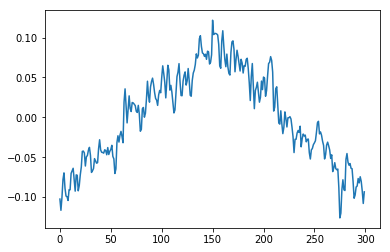

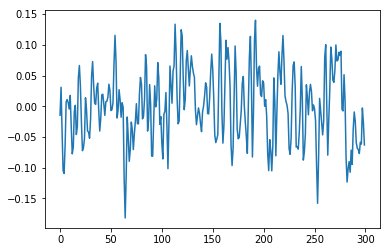

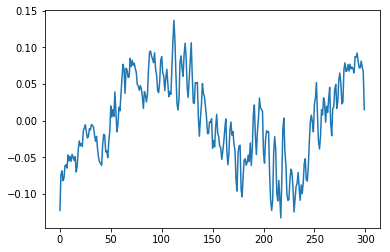

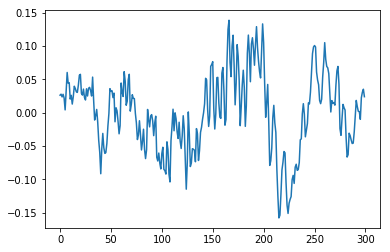

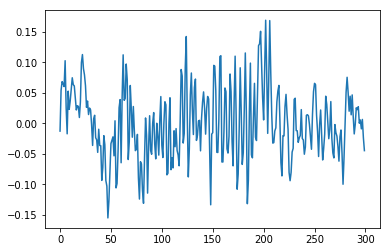

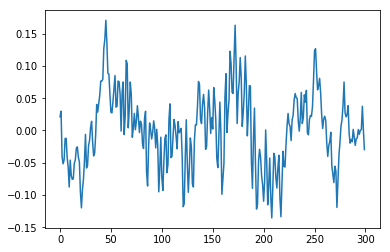

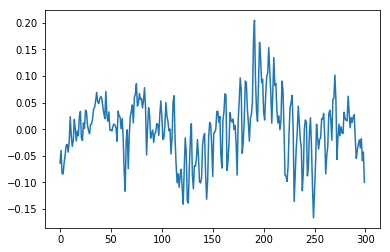

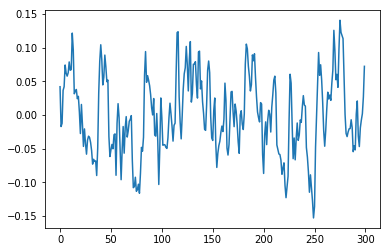

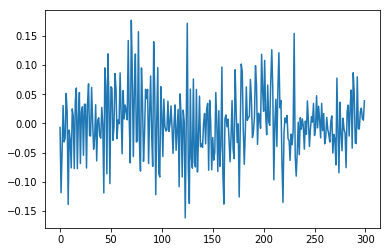

In [5]:
import matplotlib.pyplot as plt
from pandas import read_csv

components = read_csv(output_dir + '/mean_func/components.txt', index_col=None, delimiter='\t')

for comp in components.columns:
    plt.figure()
    plt.plot(components[comp])
    plt.show()
    plt.close()

## Final Denoising Workflow

In [27]:
#file handling nodes
selectfiles_template={'motion': output_dir + '/motion_parameters/{subject_id}/_run_num_{run_num}/rest_moco.nii.gz.par', 
                      'leadlagderivsmotion': output_dir + '/leadlagderivsmotion/{subject_id}/_run_num_{run_num}/derivsleadlag.txt',
                      'global_signal': output_dir + '/global_signal/{subject_id}/_run_num_{run_num}/global_signal.txt',
                      'func': output_dir + '/registered_func/{subject_id}/_run_num_{run_num}/norm_func.nii.gz',
                      'session': output_dir + '/session_noise_file/{subject_id}/_run_num_{run_num}/blurred_masked_file.nii.gz',
                      'wmcsf': output_dir + '/wmcsf_noise_file/{subject_id}/_run_num_{run_num}/blurred_masked_file.nii.gz',
                      'spike_matrix':output_dir + '/motion_spike_matrix/{subject_id}/_run_num_{run_num}/spike_matrix.txt',
                      'spike_timeseries':output_dir + '/motion_spike_timeseries/{subject_id}/_run_num_{run_num}/spike_timeseries.txt',
                      'mask': output_dir + '/brain_mask/{subject_id}/whole_brain_mask.nii.gz'}
selectfiles=Node(SelectFiles(selectfiles_template),name='selectfiles')
selectfiles.iterables=('run_num', ['0','1'])

In [28]:
def org_shared_noise(motion, leadlagderivsmotion, spike_matrix, global_signal):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from numpy import loadtxt, concatenate,ndim, expand_dims
    from pandas import DataFrame
    from os.path import abspath

    noise_list = []
    for file in [motion, leadlagderivsmotion, spike_matrix]:
        mo = loadtxt(file, dtype=float, comments=None)
        if ndim(mo)<2:
            mo = expand_dims(mo, axis=1)
        noise_list.append(mo)

    shared_noise_data = concatenate(noise_list,axis=1)

    col_names = ['noise_{0}'.format(a) for a in range(0,shared_noise_data.shape[1])] 

    shared_noise = DataFrame(shared_noise_data, columns=col_names)
    shared_noise['global_signal'] = loadtxt(global_signal, dtype=float, comments=None)
    shared_noise.to_csv('shared_noise.csv')
    shared_noise_file = abspath('shared_noise.csv')
    return(shared_noise_file)

def voxelwise_glm(func, shared_noise_file, mask, wmcsf, session):
    from os.path import abspath
    from numpy import zeros, dot, transpose, sum
    from numpy.linalg import pinv
    from pandas import read_csv, Series
    from nilearn.masking import apply_mask, unmask

    # import data into an array that is timepoints (rows) by voxel number (columns)
    shared_noise = read_csv(shared_noise_file, index_col=0)
    func_data = apply_mask(func, mask)
    #wmcsf_data = apply_mask(wmcsf, mask)
    session_data = apply_mask(session, mask)
    coefficients = zeros((shared_noise.shape[1]+2,func_data.shape[1]))
    resid_data = zeros(func_data.shape)

    # perform voxel-wise matrix inversion
    for x in range(0,func_data.shape[1]):
        #shared_noise['wmcsf'] = wmcsf_data[:,x]
        shared_noise['session'] = session_data[:,x]
        shared_noise['constant'] = 1
        noise_mat = shared_noise.to_numpy()
        y = func_data[:,x]
        inv_mat = pinv(noise_mat)
        coefficients[:,x] = dot(inv_mat,y)
        yhat=sum(transpose(coefficients[:,x])*noise_mat,axis=1)
        resid_data[:,x] = y - transpose(yhat)

    resid_image = unmask(resid_data, mask)
    resid_image.to_filename('residuals.nii.gz')

    coeff_image = unmask(coefficients, mask)
    coeff_image.to_filename('weights.nii.gz')
    sample_design_df = shared_noise.to_csv('last_noise_mat.csv')

    weights = abspath('weights.nii.gz')
    sample_design_df = abspath('last_noise_mat.csv')
    residuals = abspath('residuals.nii.gz')

    return(weights,sample_design_df, residuals)

def drop_high_motion_trs(in_file, brain_mask, timeseries_mask):
    from os.path import abspath
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn.masking import apply_mask, unmask
    import numpy as np
    
    spikes=np.genfromtxt(timeseries_mask).astype(int)
    vols_to_keep = spikes==0
    func_data = apply_mask(in_file,brain_mask)
    func_data = func_data[vols_to_keep]
    lomo_image = unmask(func_data,brain_mask)
    lomo_image.to_filename('lomo_func.nii.gz')
    out_file = abspath('lomo_func.nii.gz')
    
    return(out_file)

In [29]:
compile_noise_mat = Node(Function(input_names=['motion', 'leadlagderivsmotion', 'spike_matrix','global_signal'],
                                  output_names=['shared_noise_file'],
                                  function=org_shared_noise), 
                         name='compile_noise_mat')

denoise_func = Node(Function(input_names=['func','shared_noise_file','mask','wmcsf','session'], 
                             output_names=['weights','sample_design_df','residuals'],
                             function=voxelwise_glm),
                       name='denoise_func')

# band pass filtering- all rates are in Hz (1/TR)
bandpass = Node(Bandpass(highpass=highpass_freq,
                         lowpass=lowpass_freq, 
                         out_file='resids_bp.nii.gz'), 
                name='bandpass')

drop_himo = Node(Function(input_names=['in_file','brain_mask','timeseries_mask'], 
                          output_names=['out_file'], 
                          function=drop_high_motion_trs), 
                 name='drop_himo')

In [30]:
denoise_flow = Workflow(name='denoise_flow')
denoise_flow.connect([(subinfosource,selectfiles,[('subject_id','subject_id')]),
                      (selectfiles, denoise_func, [('mask','mask'),('func','func'),
                                                   ('wmcsf','wmcsf'),('session','session')]),
                      (selectfiles, compile_noise_mat, [('motion','motion'),
                                                        ('leadlagderivsmotion','leadlagderivsmotion'), 
                                                        ('global_signal','global_signal'),
                                                        ('spike_matrix','spike_matrix')]),
                      (selectfiles, drop_himo, [('mask','brain_mask'),('spike_timeseries','timeseries_mask')]),
                      (compile_noise_mat, denoise_func, [('shared_noise_file','shared_noise_file')]),
                      (denoise_func, bandpass, [('residuals','in_file')]), 
                      (bandpass, drop_himo, [('out_file','in_file')]),
                      
                      (bandpass, datasink, [('out_file','full_proc_func')]),
                      (drop_himo, datasink, [('out_file','lomo_proc_func')]),
                      (denoise_func, datasink, [('weights','denoising_weights'),
                                                ('sample_design_df','denoise_sample_design_df')])
                     ])
denoise_flow.base_dir = workflow_dir
#denoise_flow.write_graph(graph2use='flat')
denoise_flow.run('MultiProc', plugin_args={'n_procs': 4})


210421-17:15:31,299 nipype.workflow INFO:
	 Workflow denoise_flow settings: ['check', 'execution', 'logging', 'monitoring']
210421-17:15:31,377 nipype.workflow INFO:
	 Running in parallel.
210421-17:15:31,384 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
210421-17:15:31,473 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.selectfiles" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_1/selectfiles".210421-17:15:31,473 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.selectfiles" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_0/selectfiles".210421-17:15:31,474 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.selectfiles" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/selectfiles".

210421-17:15:31,477 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.selectfiles" in

	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/compile_noise_mat/_report
210421-17:15:33,947 nipype.workflow DEBUG:
	 Removing files: 
210421-17:15:33,951 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/compile_noise_mat/result_compile_noise_mat.pklz'
210421-17:15:33,957 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/compile_noise_mat/_report/report.rst"
210421-17:15:33,962 nipype.workflow INFO:
	 [Node] Finished "denoise_flow.compile_noise_mat".
210421-17:15:35,388 nipype.workflow INFO:
	 [Job 1] Completed (denoise_flow.compile_noise_mat).
210421-17:15:35,390 nipype.workflow INFO:
	 [Job 7] Completed (denoise_flow.compile_noise_mat).
210421-17:15:35,391 nipype.workflow INFO:
	 [Job 13] Completed (denoise_flow.compile_noise_mat).
210421-17:15:35,393 nipy

	 [Node] denoise_func - setting input session = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg4/_run_num_1/blurred_masked_file.nii.gz
210421-17:15:35,556 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_1/compile_noise_mat/result_compile_noise_mat.pklz210421-17:15:35,556 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_0/compile_noise_mat/result_compile_noise_mat.pklz
210421-17:15:35,560 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/compile_noise_mat/result_compile_noise_mat.pklz


210421-17:15:35,563 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/compile_noise_mat/result_compile_noise_mat.pklz210421-17:15:35,564 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded fr

210421-17:30:57,793 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * denoise_flow.bandpass
                       * denoise_flow.denoise_func
                       * denoise_flow.denoise_func
210421-17:30:57,895 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.bandpass" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/bandpass".
210421-17:30:57,898 nipype.workflow DEBUG:
	 [Node] Not cached "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/bandpass".
210421-17:30:57,900 nipype.workflow DEBUG:
	 [Node] Setting 1 connected inputs of node "bandpass" from 1 previous nodes.
210421-17:30:57,903 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/denoise_func/result_denoise_func.pklz
210421-17:30:57,977 n

	 Needed files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/drop_himo/lomo_func.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/drop_himo/_0xc5afbe6fcd9c643a507a350fc9b72938_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/drop_himo/_inputs.pklz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/drop_himo/_node.pklz
210421-17:33:30,405 nipype.workflow DEBUG:
	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/drop_himo/_report
210421-17:33:30,412 nipype.workflow DEBUG:
	 Removing files: 
210421-17:33:30,423 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_0/drop_himo/result_drop_himo.pklz'
210421-17:33:30,436 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Document

	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg3/_run_num_1/norm_func.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/global_signal/1196_Preg3/_run_num_1/global_signal.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/leadlagderivsmotion/1196_Preg3/_run_num_1/derivsleadlag.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask/1196_Preg3/whole_brain_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/1196_Preg3/_run_num_1/rest_moco.nii.gz.par;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg3/_run_num_1/blurred_masked_file.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_matrix/1196_Preg3/_run_num_1/spike_matrix.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_timeseries/1196_Preg3/_run_num_1/spike_timeseries.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/wmcsf_noise_file/1196_Preg3/_run_num_1/blurred_masked_f

	 Removing files: 
210421-17:33:36,442 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_1/datasink/result_datasink.pklz'
210421-17:33:36,447 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_1/datasink/_report/report.rst"
210421-17:33:36,451 nipype.workflow INFO:
	 [Node] Finished "denoise_flow.datasink".
210421-17:33:36,662 nipype.workflow DEBUG:
	 Needed files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_1/compile_noise_mat/shared_noise.csv;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_1/compile_noise_mat/_0x195a21f106516166191f923fd8f57414_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_1/compile_noise_mat/_inputs.pklz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_

210421-17:33:39,979 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.compile_noise_mat" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/compile_noise_mat".
210421-17:33:39,982 nipype.workflow DEBUG:
	 [Node] Not cached "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/compile_noise_mat".
210421-17:33:39,985 nipype.workflow DEBUG:
	 [Node] Setting 4 connected inputs of node "compile_noise_mat" from 1 previous nodes.
210421-17:33:39,988 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/selectfiles/result_selectfiles.pklz
210421-17:33:39,991 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-17:33:39,994 nipype.workflow DEBUG:
	 output: motion
210421-17:33:39,998 nipype.workflow DEBUG:
	 [Node] compile_noise_mat - setting input motion = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters

	 output: out_file
210421-17:36:08,128 nipype.workflow DEBUG:
	 [Node] drop_himo - setting input in_file = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_0/bandpass/resids_bp.nii.gz
210421-17:36:08,233 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_0/drop_himo
210421-17:36:08,237 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg5/_run_num_0/drop_himo/_report/report.rst"
210421-17:36:08,242 nipype.workflow INFO:
	 [Node] Running "drop_himo" ("nipype.interfaces.utility.wrappers.Function")
210421-17:36:09,999 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 13.60/14.40, Free processors: 0/4.
                     Currently running:
                       * denoise_flow.drop_himo
                       * denoise_flow.denoise_func
                       * de

	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_1/norm_func.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/global_signal/1196_Preg2/_run_num_1/global_signal.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/leadlagderivsmotion/1196_Preg2/_run_num_1/derivsleadlag.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask/1196_Preg2/whole_brain_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/1196_Preg2/_run_num_1/rest_moco.nii.gz.par;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg2/_run_num_1/blurred_masked_file.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_matrix/1196_Preg2/_run_num_1/spike_matrix.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_timeseries/1196_Preg2/_run_num_1/spike_timeseries.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/wmcsf_noise_file/1196_Preg2/_run_num_1/blurred_masked_f

	 [Node] denoise_func - setting input session = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg2/_run_num_1/blurred_masked_file.nii.gz
210421-17:37:02,128 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/compile_noise_mat/result_compile_noise_mat.pklz
210421-17:37:02,131 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-17:37:02,134 nipype.workflow DEBUG:
	 output: shared_noise_file
210421-17:37:02,138 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input shared_noise_file = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/compile_noise_mat/shared_noise.csv
210421-17:37:02,141 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/denoise_func
210421-17:37:02,145 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/

	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/denoise_func/result_denoise_func.pklz'
210421-17:55:34,801 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/denoise_func/_report/report.rst"
210421-17:55:34,829 nipype.workflow INFO:
	 [Node] Finished "denoise_flow.denoise_func".
210421-17:55:35,77 nipype.workflow INFO:
	 [Job 38] Completed (denoise_flow.denoise_func).
210421-17:55:35,79 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 8 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * denoise_flow.bandpass
                       * denoise_flow.denoise_func
                       * denoise_flow.denoise_func
210421-17:55:35,155 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.bandpass" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/

	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/drop_himo
210421-17:55:51,445 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/drop_himo/_report/report.rst"
210421-17:55:51,449 nipype.workflow INFO:
	 [Node] Running "drop_himo" ("nipype.interfaces.utility.wrappers.Function")
210421-17:55:53,91 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 7 jobs ready. Free memory (GB): 13.60/14.40, Free processors: 0/4.
                     Currently running:
                       * denoise_flow.drop_himo
                       * denoise_flow.bandpass
                       * denoise_flow.denoise_func
                       * denoise_flow.denoise_func
210421-17:56:36,2 nipype.workflow DEBUG:
	 Needed files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg4/_run_num_1/drop_himo/lomo_func.nii.gz;/Users/SEAlab/Docum

	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_Preg2/_run_num_0/norm_func.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/global_signal/1196_Preg2/_run_num_0/global_signal.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/leadlagderivsmotion/1196_Preg2/_run_num_0/derivsleadlag.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask/1196_Preg2/whole_brain_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/1196_Preg2/_run_num_0/rest_moco.nii.gz.par;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg2/_run_num_0/blurred_masked_file.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_matrix/1196_Preg2/_run_num_0/spike_matrix.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_timeseries/1196_Preg2/_run_num_0/spike_timeseries.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/wmcsf_noise_file/1196_Preg2/_run_num_0/blurred_masked_f

	 [Node] denoise_func - setting input session = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg2/_run_num_0/blurred_masked_file.nii.gz
210421-17:56:43,236 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/compile_noise_mat/result_compile_noise_mat.pklz
210421-17:56:43,255 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-17:56:43,260 nipype.workflow DEBUG:
	 output: shared_noise_file
210421-17:56:43,263 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input shared_noise_file = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/compile_noise_mat/shared_noise.csv
210421-17:56:43,267 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/denoise_func
210421-17:56:43,271 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/

	 key: full_proc_func files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/bandpass/resids_bp.nii.gz
210421-17:57:51,544 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_subject_id_1196_Preg2/_run_num_1/resids_bp.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_1196_Preg2/_run_num_1/resids_bp.nii.gz using '_subject_id_' -> '_'
210421-17:57:51,548 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_subject_id_1196_Preg2/_run_num_1/resids_bp.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_1196_Preg2/_run_num_1/resids_bp.nii.gz
210421-17:57:51,552 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_1/bandpass/resids_bp.nii.gz /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_1196_Preg2/_run_num_1/resids_bp.nii.gz
21

	 output: wmcsf
210421-17:57:59,279 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input wmcsf = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/wmcsf_noise_file/1196_Preg1/_run_num_0/blurred_masked_file.nii.gz
210421-17:57:59,282 nipype.workflow DEBUG:
	 output: session
210421-17:57:59,285 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input session = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_Preg1/_run_num_0/blurred_masked_file.nii.gz
210421-17:57:59,288 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg1/_run_num_0/compile_noise_mat/result_compile_noise_mat.pklz
210421-17:57:59,291 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-17:57:59,294 nipype.workflow DEBUG:
	 output: shared_noise_file
210421-17:57:59,298 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input shared_noise_file = /Users/SEAlab/Documents/PPM/Workflows/denoise_flo

	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_1/datasink/_report/report.rst"
210421-18:03:17,617 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210421-18:03:17,621 nipype.interface DEBUG:
	 key: denoising_weights files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_1/denoise_func/weights.nii.gz
210421-18:03:17,624 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_subject_id_1196_Preg3/_run_num_1/weights.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_1196_Preg3/_run_num_1/weights.nii.gz using '_subject_id_' -> '_'
210421-18:03:17,627 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_subject_id_1196_Preg3/_run_num_1/weights.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_1196

	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_1/compile_noise_mat/_report
210421-18:03:21,683 nipype.workflow DEBUG:
	 Removing files: 
210421-18:03:21,686 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_1/compile_noise_mat/result_compile_noise_mat.pklz'
210421-18:03:21,690 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_1/compile_noise_mat/_report/report.rst"
210421-18:03:21,694 nipype.workflow INFO:
	 [Node] Finished "denoise_flow.compile_noise_mat".
210421-18:03:23,487 nipype.workflow INFO:
	 [Job 61] Completed (denoise_flow.compile_noise_mat).
210421-18:03:23,490 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * denoise_flow.

	 [Node] Not cached "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/datasink".
210421-18:10:01,978 nipype.workflow DEBUG:
	 [Node] Setting 4 connected inputs of node "datasink" from 3 previous nodes.
210421-18:10:01,981 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/denoise_func/result_denoise_func.pklz
210421-18:10:01,984 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-18:10:01,986 nipype.workflow DEBUG:
	 output: weights
210421-18:10:01,989 nipype.workflow DEBUG:
	 [Node] datasink - setting input denoising_weights = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/denoise_func/weights.nii.gz
210421-18:10:01,991 nipype.workflow DEBUG:
	 output: sample_design_df
210421-18:10:01,994 nipype.workflow DEBUG:
	 [Node] datasink - setting input denoise_sample_design_df = /Users/SEAlab/Documents/PPM/Workflows/den

	 key: full_proc_func files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/bandpass/resids_bp.nii.gz
210421-18:10:02,128 nipype.interface DEBUG:
	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_subject_id_1196_Preg3/_run_num_0/resids_bp.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_1196_Preg3/_run_num_0/resids_bp.nii.gz using '_subject_id_' -> '_'
210421-18:10:02,131 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_subject_id_1196_Preg3/_run_num_0/resids_bp.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_1196_Preg3/_run_num_0/resids_bp.nii.gz
210421-18:10:02,134 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg3/_run_num_0/bandpass/resids_bp.nii.gz /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/full_proc_func/_1196_Preg3/_run_num_0/resids_bp.nii.gz
21

	 [Node] compile_noise_mat - setting input leadlagderivsmotion = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/leadlagderivsmotion/1196_PP2/_run_num_0/derivsleadlag.txt
210421-18:10:05,998 nipype.workflow DEBUG:
	 output: global_signal
210421-18:10:06,0 nipype.workflow DEBUG:
	 [Node] compile_noise_mat - setting input global_signal = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/global_signal/1196_PP2/_run_num_0/global_signal.txt
210421-18:10:06,3 nipype.workflow DEBUG:
	 output: spike_matrix
210421-18:10:06,6 nipype.workflow DEBUG:
	 [Node] compile_noise_mat - setting input spike_matrix = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_matrix/1196_PP2/_run_num_0/spike_matrix.txt
210421-18:10:06,10 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_0/compile_noise_mat
210421-18:10:06,13 nipype.workflow DEBUG:
	 [Node] Writing pre-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoi

	 Needed files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/drop_himo/lomo_func.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/drop_himo/_0x6087b194f3afc4090490e80339a3ec04_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/drop_himo/_inputs.pklz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/drop_himo/_node.pklz
210421-18:13:00,548 nipype.workflow DEBUG:
	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/drop_himo/_report
210421-18:13:00,554 nipype.workflow DEBUG:
	 Removing files: 
210421-18:13:00,559 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg2/_run_num_0/drop_himo/result_drop_himo.pklz'
210421-18:13:00,568 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Document

	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/selectfiles/result_selectfiles.pklz'
210421-18:13:04,555 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/selectfiles/_report/report.rst"
210421-18:13:04,558 nipype.workflow INFO:
	 [Node] Finished "denoise_flow.selectfiles".
210421-18:13:06,150 nipype.workflow INFO:
	 [Job 72] Completed (denoise_flow.selectfiles).
210421-18:13:06,153 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 2 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 1/4.
                     Currently running:
                       * denoise_flow.denoise_func
                       * denoise_flow.denoise_func
                       * denoise_flow.denoise_func
210421-18:13:06,201 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.compile_noise_mat" in "/Users/SEAlab/Documents/PPM/Workflows/denoise

	 [Node] drop_himo - setting input brain_mask = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask/1196_Preg1/whole_brain_mask.nii.gz
210421-18:16:30,576 nipype.workflow DEBUG:
	 output: spike_timeseries
210421-18:16:30,578 nipype.workflow DEBUG:
	 [Node] drop_himo - setting input timeseries_mask = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_timeseries/1196_Preg1/_run_num_0/spike_timeseries.txt
210421-18:16:30,581 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg1/_run_num_0/bandpass/result_bandpass.pklz
210421-18:16:30,584 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-18:16:30,587 nipype.workflow DEBUG:
	 output: out_file
210421-18:16:30,589 nipype.workflow DEBUG:
	 [Node] drop_himo - setting input in_file = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_Preg1/_run_num_0/bandpass/resids_bp.nii.gz
210421-18:16:30,623 nipype.utils DEBUG:
	 

	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210421-18:17:16,667 nipype.workflow DEBUG:
	 Needed files: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/registered_func/1196_PP1/_run_num_0/norm_func.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/global_signal/1196_PP1/_run_num_0/global_signal.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/leadlagderivsmotion/1196_PP1/_run_num_0/derivsleadlag.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask/1196_PP1/whole_brain_mask.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_parameters/1196_PP1/_run_num_0/rest_moco.nii.gz.par;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_PP1/_run_num_0/blurred_masked_file.nii.gz;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_matrix/1196_PP1/_run_num_0/spike_matrix.txt;/Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/motion_spike_timeseries/1196_PP1/_run_num_0/spike_timeseries.txt;/Users/SEAl

	 output: session
210421-18:17:20,583 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input session = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/session_noise_file/1196_PP1/_run_num_0/blurred_masked_file.nii.gz
210421-18:17:20,585 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/compile_noise_mat/result_compile_noise_mat.pklz
210421-18:17:20,588 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-18:17:20,591 nipype.workflow DEBUG:
	 output: shared_noise_file
210421-18:17:20,593 nipype.workflow DEBUG:
	 [Node] denoise_func - setting input shared_noise_file = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/compile_noise_mat/shared_noise.csv
210421-18:17:20,596 nipype.utils DEBUG:
	 Removing contents of /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/denoise_func
210421-18:17:20,632 nipype.workflow DEBUG

	 sub.str: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_subject_id_1196_PP2/_run_num_1/weights.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_1196_PP2/_run_num_1/weights.nii.gz using '_subject_id_' -> '_'
210421-18:21:24,809 nipype.interface INFO:
	 sub: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_subject_id_1196_PP2/_run_num_1/weights.nii.gz -> /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_1196_PP2/_run_num_1/weights.nii.gz
210421-18:21:24,812 nipype.interface DEBUG:
	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_1/denoise_func/weights.nii.gz /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_1196_PP2/_run_num_1/weights.nii.gz
210421-18:21:24,815 nipype.utils DEBUG:
	 /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/denoising_weights/_1196_PP2/_run_num_1/weights.nii.gz
210421-18:21:24,817 nipype.utils DEBUG:
	 Li

	 [Node] Setting-up "denoise_flow.drop_himo" in "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_0/drop_himo".
210421-18:24:08,857 nipype.workflow DEBUG:
	 [Node] Not cached "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_0/drop_himo".
210421-18:24:08,859 nipype.workflow DEBUG:
	 [Node] Setting 3 connected inputs of node "drop_himo" from 2 previous nodes.
210421-18:24:08,862 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP2/_run_num_0/selectfiles/result_selectfiles.pklz
210421-18:24:08,891 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
210421-18:24:08,894 nipype.workflow DEBUG:
	 output: mask
210421-18:24:08,897 nipype.workflow DEBUG:
	 [Node] drop_himo - setting input brain_mask = /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/brain_mask/1196_PP2/whole_brain_mask.nii.gz
210421-18:24:08,899 nipype.workflow DEBUG:
	 output: spike_

	 Needed files: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/residuals.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/last_noise_mat.csv;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/weights.nii.gz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/_0x9915328ad3f5b0da5b9dff30e553c282_unfinished.json;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/_inputs.pklz;/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/_node.pklz
210421-18:24:59,929 nipype.workflow DEBUG:
	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/_report
210421-18:24:59,933 nipype.workflow DEBUG:
	 Removing files: 
210421-18:24:59,936 nipype.workflow DEBUG:
	 Saving resul

3dBandpass -prefix resids_bp.nii.gz 0.008000 0.090000 /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/bandpass/residuals.nii.gz

210421-18:26:55,130 nipype.workflow DEBUG:
	 output: sample_design_df210421-18:26:55,131 nipype.interface DEBUG:
	 highpass_0.008

210421-18:26:55,133 nipype.workflow DEBUG:
	 [Node] datasink - setting input denoise_sample_design_df = /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/denoise_func/last_noise_mat.csv210421-18:26:55,134 nipype.interface DEBUG:
	 in_file_/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/bandpass/residuals.nii.gz

210421-18:26:55,136 nipype.utils DEBUG:
	 Loading pkl: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_1/drop_himo/result_drop_himo.pklz210421-18:26:55,137 nipype.interface DEBUG:
	 lowpass_0.09

210421-18:26:55,140 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results fi

	 Needed dirs: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/drop_himo/_report
210421-18:28:40,877 nipype.workflow DEBUG:
	 Removing files: 
210421-18:28:40,880 nipype.workflow DEBUG:
	 Saving results file: '/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/drop_himo/result_drop_himo.pklz'
210421-18:28:40,885 nipype.workflow DEBUG:
	 [Node] Writing post-exec report to "/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/drop_himo/_report/report.rst"
210421-18:28:40,889 nipype.workflow INFO:
	 [Node] Finished "denoise_flow.drop_himo".
210421-18:28:41,90 nipype.workflow INFO:
	 [Job 82] Completed (denoise_flow.drop_himo).
210421-18:28:41,93 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
210421-18:28:41,141 nipype.workflow INFO:
	 [Node] Setting-up "denoise_flow.datasink" in "/Users/SEAlab/Documents/PPM/Workflows/

	 copyfile: /Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/drop_himo/lomo_func.nii.gz /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/lomo_proc_func/_1196_PP1/_run_num_0/lomo_func.nii.gz
210421-18:28:41,318 nipype.utils DEBUG:
	 /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/lomo_proc_func/_1196_PP1/_run_num_0/lomo_func.nii.gz
210421-18:28:41,321 nipype.utils DEBUG:
	 Linking File: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/lomo_proc_func/_1196_PP1/_run_num_0/lomo_func.nii.gz->/Users/SEAlab/Documents/PPM/Workflows/denoise_flow/_subject_id_1196_PP1/_run_num_0/drop_himo/lomo_func.nii.gz
210421-18:28:41,325 nipype.utils DEBUG:
	 /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/lomo_proc_func/_1196_PP1/_run_num_0/lomo_func.nii.gz
210421-18:28:41,328 nipype.utils DEBUG:
	 File: /Users/SEAlab/Documents/PPM/fMRIproc/preprocessing/lomo_proc_func/_1196_PP1/_run_num_0/lomo_func.nii.gz already exists, not overwriting, copy:1
210421-18:28:41,331

RuntimeError: Workflow did not execute cleanly. Check log for details

In [3]:
# merge files according to acquisition condition (fixation/rest or mlp/movie)
from glob import glob
from os import mkdir
from nipype.interfaces.fsl import Merge

merge = Merge()
merge.inputs.dimension='t'
for sub in subject_ids: 
    files = glob(output_dir + '/lomo_proc_func/_{0}/*/lomo_func.nii.gz'.format(sub))
    merge.inputs.in_files = files
    merge.inputs.merged_file = output_dir + '/lomo_proc_func/_{0}/merged_func.nii.gz'.format(sub)
    merge.run()        